# Rinne Daily Dataset
## TE analysis

This script includes TE analysis for 3 cases:

1. Anomaly data series
2. Moving average at a ??? scale
3. Aggregated data.

There is also an optional Normalization procedure.

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
from scipy.signal import lfilter, butter
import matplotlib.image as mpimg
from matplotlib import rcParams
import pylab
import importlib

# Local modules
import TEpython3


# Anomaly, Moving average & Aggregation


## 1. Anomaly

In [3]:
# Read data table

table = pd.read_csv('Aggregated_Daily_for_DOY.csv',header = 0,index_col = 'Year_Month_Day',parse_dates = True, infer_datetime_format = True,low_memory=False)

print(table.shape)
table.head(5)

(3652, 81)


,T_air,Rh,R,T_-5cm,T_-10cm,T_-20cm,T_-35cm,T_-50cm,WT,NEE,...,P_30_day,P_91_day,P_183_day,P_365_day,H2O_7_day,H2O_14_day,H2O_30_day,H2O_91_day,H2O_183_day,H2O_365_day
Year_Month_Day,,,,,,,,,,,,,,,,,,,,,
2005-01-01,-1.39,89.8,18.60,-0.04,-0.4,-0.2,0.5,1.30,9.16,0.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-02,-0.30,98.4,4.74,0.06,-0.4,-0.2,0.5,1.30,9.07,0.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-03,-0.84,98.2,11.70,0.06,-0.4,-0.2,0.5,1.30,9.03,0.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,-2.58,99.9,11.20,0.04,-0.4,-0.2,0.5,1.30,8.66,0.26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,-2.76,100.0,7.75,0.02,-0.4,-0.2,0.5,1.28,8.81,0.23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# A function that generates the anomaly time series. 
# The function is similar to climate based data filling in notebook 2 (QC) step 3/5. 

def func(table):
    yearInt = min(table.index.year)
    yearMax = max(table.index.year)+1
    years = np.arange(yearInt,yearMax, 1)
    lenYear = np.count_nonzero(years)
    nameVar = table.columns
    numCol = len(nameVar)
    xmax = 366 # days in a year
    
    TableFinal = copy.deepcopy(table)
    MeanFinal = copy.deepcopy(table)
    for j in range(0,numCol): # variable being processed
        AnnualTable = np.ones([(yearMax-yearInt),xmax])*np.nan
  #      print(AnnualTable.shape)
        y4 = table[nameVar[j]].copy(deep=True)
        VarName = table.columns[j]

        for year in years: # years
            d = y4[y4.index.year==year].copy(deep=True) # The variable being processed, for the current year
 #           print(d.shape)
            AnnualTable[year-yearInt,0] = year #Assign index value
            AnnualTable[year-yearInt,(0):(d.shape[0])] = d.values
  #          AnnualTable[year-yearInt,(xmax - (d.shape[0]) ):(xmax)] = d.values # If the year does not start at Jan 1
            # 365 starts at 1 while 366 start at 2
        
        
        AnnualMean = (np.nanmean(AnnualTable,axis=0))
        AnnualAnomaly = AnnualTable - AnnualMean   # For a single variable
       # print(AnnualMean.shape)
       # print(AnnualAnomaly.shape)
        y5 = y4.copy(deep=True)*np.nan
        y6 = y5.copy(deep=True) #I will store the annual mean here in a way that makes it easy to plot against the data
        
        for year in years:
            d = y5[y5.index.year==year].copy(deep=True)
            ddim = d.shape[0]
            y5.loc[d.index] = AnnualAnomaly[year-yearInt,(0):(d.shape[0])]
#            y5.loc[d.index] = AnnualAnomaly[year-yearInt,(xmax - (d.shape[0]) ):(xmax)]
            y6.loc[d.index] = AnnualMean[(0):(d.shape[0])]
        #print(VarName,TableFinal.shape)
        TableFinal.loc[y5.index,VarName] = y5.loc[y5.index]
        MeanFinal.loc[y6.index,VarName] = y6.loc[y6.index]
    
    return TableFinal, MeanFinal;


In [5]:
AnoTable, MeanTable = func(table=table)
#AnoTable.loc[AnoTable.index.year==2001,AnoTable.columns[0]] # year 2001 the first months does not have data since it does not start at Jan 1
AnoTable.head(5)


C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice


,T_air,Rh,R,T_-5cm,T_-10cm,T_-20cm,T_-35cm,T_-50cm,WT,NEE,...,P_30_day,P_91_day,P_183_day,P_365_day,H2O_7_day,H2O_14_day,H2O_30_day,H2O_91_day,H2O_183_day,H2O_365_day
Year_Month_Day,,,,,,,,,,,,,,,,,,,,,
2005-01-01,2.3970,-0.550000,10.961,-0.533750,-0.375000,-0.548000,-0.731000,-1.276000,8.756000,-0.050000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-02,5.1430,7.110000,-4.196,-0.413750,-0.358000,-0.548000,-0.708000,-1.240000,8.790000,-0.067143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-03,4.5620,7.270000,2.287,-0.372500,-0.343000,-0.525000,-0.700000,-1.219000,8.970000,-0.025714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,3.0490,7.240000,2.269,-0.441250,-0.338000,-0.517000,-0.675000,-1.202000,9.083000,-0.108333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,4.8175,10.533333,-4.038,-0.388571,-0.306667,-0.487778,-0.637778,-1.231111,9.377778,-0.106667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Generate plots of anomaly generation from day-of-year mean

In [ ]:
count = 0
for column in AnoTable:
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize = [15,8])
    fig.suptitle(AnoTable.columns[count])
    ax1.plot(table[column], 'b-')
    ax1.plot(MeanTable[column], 'm-')
    ax2.plot(AnoTable[column], 'r-')
    count = count + 1

#### Now plot histograms of the anomaly

In [ ]:
count = 0
for column in AnoTable:
    pylab.figure()
    pylab.hist((AnoTable.loc[~np.isnan(AnoTable[column]), column]))
    pylab.title(table.columns[count])
    count = count + 1

#### Plot autocorrelation functions of the anomaly

In [10]:
def nanacf(X, maxlag=365): #Generates an autocorrelation function for X, ignoring missing variables. 
    nX = len(X)
    r = np.zeros(maxlag)
    sig_thr = np.zeros(maxlag)
    for ii in range(maxlag):
        if ii == 0:
            Y = X
            Z = X
        else:
            Y = X[:-ii].copy()
            Z = X[ii:].copy()
        Y[np.isnan(Z)]=np.nan
        Z[np.isnan(Y)]=np.nan
            
        r[ii] = np.corrcoef(Y[~np.isnan(Y)], Z[~np.isnan(Z)])[0,1]
        sig_thr[ii] = 3/np.sqrt(np.sum(~np.isnan(Y)))
 #   plt.plot(r)
 #   plt.xlabel('Lag')
 #   plt.ylabel('Autocorrelation')
    return r, sig_thr
    

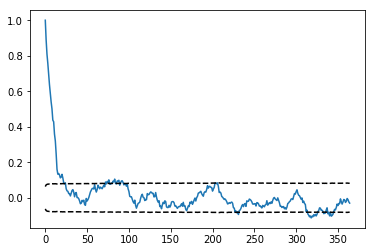

In [8]:
(trash, sigtrash)=nanacf(AnoTable['P_14_day'].values)
plt.plot(trash)
plt.plot(sigtrash, 'k--')
plt.plot(-sigtrash, 'k--')

In [10]:
count = 0
for column in AnoTable:
   # plt.figure()
    (r, sig_thr) = nanacf(AnoTable.loc[:,column].values) 
    #plt.plot(r)
    #plt.plot(sig_thr, 'k--')
    #plt.plot(-sig_thr, 'k--')
    #plt.xlabel('lag')
    #plt.ylabel('autocorrelation')
    #plt.title(table.columns[count])
    count = count + 1
    above_thr = r-sig_thr
    not_corr = np.where(above_thr<0)
    if np.min(np.size(not_corr))>0:
        
        per = not_corr[0][0]
    else:
        per = 999
    #print(np.size(per))
    if per <= 18: #Print out variables that have a period deemed acceptable for avoiding pseudoreplication (albeit subjective)
        print(column)
        print(per)

Rh
R
T_-5cm
T_-10cm
T_-20cm
P
T_-5cm_7_day
T_-10cm_7_day
T_-10cm_14_day
P_7_day


In [273]:
not_corr = np.array([1])
np.min(np.size(not_corr))

1

#### Observations
Reco, NEE, GPP, and Methane flux have distributions where most of the data is near the mean, and there are a few extreme outliers. May want to transform to better emphasize changes near the mean and increase the entropy of the anomaly dataset. This can be done without regard to what the final values of the transformed dataset are, as all that matters is the binning. Do a square root transform that preserves the sign of the original anomaly. 

In [7]:
def HistSqrtTransform(arr, plot_on=0, plot_title=''): #Input is an array, which may contain NaNs and zeros
    transformed = np.zeros(len(arr)) #initialize
    transformed = np.sqrt(np.abs(arr))*np.sign(arr)
   
    if plot_on:
        plt.hist(transformed[~np.isnan(transformed)])
        plt.title(plot_title)
    return transformed;

Now add new entries in the table for transformed values.

C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sign
  This is separate from the ipykernel package so we can avoid doing imports until


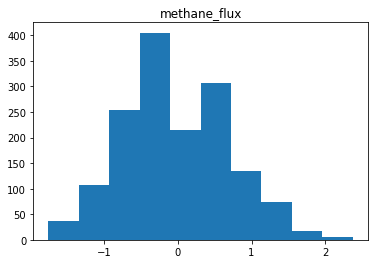

In [124]:
#AnoTable['sqrt_Reco'] = HistSqrtTransform(AnoTable['Reco'], 1, 'Reco')
#plt.figure()
#AnoTable['sqrt_NEE'] = HistSqrtTransform(AnoTable['NEE'], 1, 'NEE')
#plt.figure()
#AnoTable['sqrt_GPP'] = HistSqrtTransform(AnoTable['GPP'], 1, 'GPP')
#plt.figure()
AnoTable['sqrt_methane_flux'] = HistSqrtTransform(AnoTable['methane_flux'], 1, 'methane_flux');

That looks better!

In [125]:
AnoTable.head()

,T_air,Rh,R,T_-5cm,T_-10cm,T_-20cm,T_-35cm,T_-50cm,WT,NEE,...,GPP_91_day,GPP_183_day,GPP_365_day,P_7_day,P_14_day,P_30_day,P_91_day,P_183_day,P_365_day,sqrt_methane_flux
Year_Month_Day,,,,,,,,,,,,,,,,,,,,,
2005-01-01,2.3970,-0.550000,10.961,-0.533750,-0.375000,-0.548000,-0.731000,-1.276000,8.756000,-0.050000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-02,5.1430,7.110000,-4.196,-0.413750,-0.358000,-0.548000,-0.708000,-1.240000,8.790000,-0.067143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-03,4.5620,7.270000,2.287,-0.372500,-0.343000,-0.525000,-0.700000,-1.219000,8.970000,-0.025714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,3.0490,7.240000,2.269,-0.441250,-0.338000,-0.517000,-0.675000,-1.202000,9.083000,-0.108333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,4.8175,10.533333,-4.038,-0.388571,-0.306667,-0.487778,-0.637778,-1.231111,9.377778,-0.106667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Nontransformed, t-1

In [8]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,13), 14:numVr+1]# ,10)] transformed, np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([13]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

['DateTime' 'methane_flux' 'T_air' 'Rh' 'R' 'T_-5cm' 'T_-10cm' 'T_-20cm'
 'T_-35cm' 'T_-50cm' 'WT' 'NEE' 'Reco' 'GPP' 'P' 'H2O' 'T_air_7_day'
 'T_air_14_day' 'T_air_30_day' 'T_air_91_day' 'T_air_183_day'
 'T_air_365_day' 'Rh_7_day' 'Rh_14_day' 'Rh_30_day' 'Rh_91_day'
 'Rh_183_day' 'Rh_365_day' 'R_7_day' 'R_14_day' 'R_30_day' 'R_91_day'
 'R_183_day' 'R_365_day' 'T_-5cm_7_day' 'T_-5cm_14_day' 'T_-5cm_30_day'
 'T_-5cm_91_day' 'T_-5cm_183_day' 'T_-5cm_365_day' 'T_-10cm_7_day'
 'T_-10cm_14_day' 'T_-10cm_30_day' 'T_-10cm_91_day' 'T_-10cm_183_day'
 'T_-10cm_365_day' 'WT_7_day' 'WT_14_day' 'WT_30_day' 'WT_91_day'
 'WT_183_day' 'WT_365_day' 'NEE_7_day' 'NEE_14_day' 'NEE_30_day'
 'NEE_91_day' 'NEE_183_day' 'NEE_365_day' 'Reco_7_day' 'Reco_14_day'
 'Reco_30_day' 'Reco_91_day' 'Reco_183_day' 'Reco_365_day' 'GPP_7_day'
 'GPP_14_day' 'GPP_30_day' 'GPP_91_day' 'GPP_183_day' 'GPP_365_day'
 'P_7_day' 'P_14_day' 'P_30_day' 'P_91_day' 'P_183_day' 'P_365_day'
 'H2O_7_day' 'H2O_14_day' 'H2O_30_day' 'H2O_91

In [15]:
#SCRATCH
def PickSampleInterval(X, maxlag=365, alpha=0.05): #Dynamically selects the appropriate interval for sampling the data, based on the autocorrelation function. Nans are OK. Alpha is the significance level for assessing the significance of the autocorrelation function.
    nX = len(X)
    r = np.zeros(maxlag)
    sig_thr = np.zeros(maxlag)
    for ii in range(maxlag):
        if ii == 0:
            Y = X
            Z = X
        else:
            Y = X[:-ii].copy()
            Z = X[ii:].copy()
        Y[np.isnan(Z)]=np.nan
        Z[np.isnan(Y)]=np.nan
            
        r[ii] = np.corrcoef(Y[~np.isnan(Y)], Z[~np.isnan(Z)])[0,1]
        sig_thr[ii] = norm.ppf(1-alpha/2)/np.sqrt(np.sum(~np.isnan(Y)))
 #   plt.plot(r)
 #   plt.xlabel('Lag')
 #   plt.ylabel('Autocorrelation')
    above_thr = r-sig_thr
    not_corr = np.where(above_thr<0)
    if np.min(np.size(not_corr))>0:
        
        per = not_corr[0][0] # "per" is the period. The data should be sampled once per period.
    else:
        per = maxlag
    return per

In [83]:
# Applying TE on the anomaly data
importlib.reload(TEpython4)

sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython4.RunNewTE2VarsSer2(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365,shift=sf)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 0 40
1 0 0 41
2 0 0 47
3 0 0 42
4 0 0 42
5 0 0 36
6 0 0 36
7 0 0 35
8 0 0 38
9 0 0 39
10 0 0 34
11 0 0 28
12 0 0 35
13 0 0 37
14 0 0 36
15 0 0 40
16 0 0 44
17 0 0 46
18 0 0 37
19 0 0 43
20 0 0 41
21 0 0 41
22 0 0 41
23 0 0 38
24 0 0 37
25 0 0 41
26 0 0 47
27 0 0 43
28 0 0 42
29 0 0 33
30 0 0 34
31 0 0 37
32 0 0 37
33 0 0 39
34 0 0 35
35 0 0 30
36 0 0 38
37 0 0 38
38 0 0 35
39 0 0 39
40 0 0 47
41 0 0 48
42 0 0 36
43 0 0 45
44 0 0 41
45 0 0 41
46 0 0 41
47 0 0 39
48 0 0 36
49 0 0 41
50 0 0 46
51 0 0 41
52 0 0 39
53 0 0 35
54 0 0 35
55 0 0 33
56 0 0 35
57 0 0 37
58 0 0 33
59 0 0 27
60 0 0 33
61 0 0 34
62 0 0 34
63 0 0 38
64 0 0 45
65 0 0 46
66 0 0 35
67 0 0 45
68 0 0 42
69 0 0 43
70 0 0 42
71 0 0 37
72 0 0 36
73 0 0 41
74 0 0 45
75 0 0 39
76 0 0 38
77 0 0 33
78 0 0 35
79 0 0 34
80 0 0 36
81 0 0 38
82 0 0 34
83 0 0 29
84 0 0 33
85 0 0 35
86 0 0 34
87 0 0 39
88 0 0 45
89 0 0 4

C:\Users\Laurel Larsen\Dropbox\Fulbright\Research\Code_templates\TEpython4.py:892: RuntimeWarning: invalid value encountered in greater_equal
  TgTcrit = np.argwhere(T >= Tcrit)  # np.argwhere(np.array([5,6,9,18]) > np.array([3,9,2,9]))


Source node  1 Rh :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 1 72
1 0 1 74
2 0 1 67
3 0 1 65
4 0 1 62
5 0 1 52
6 0 1 53
7 0 1 55
8 0 1 54
9 0 1 56
10 0 1 56
11 0 1 61
12 0 1 60
13 0 1 66
14 0 1 61
15 0 1 62
16 0 1 74
17 0 1 67
18 0 1 64
19 0 1 61
20 0 1 53
21 0 1 55
22 0 1 57
23 0 1 58
24 0 1 57
25 0 1 57
26 0 1 61
27 0 1 60
28 0 1 65
29 0 1 64
30 0 1 63
31 0 1 75
32 0 1 67
33 0 1 64
34 0 1 61
35 0 1 53
36 0 1 53
37 0 1 58
38 0 1 59
39 0 1 56
40 0 1 56
41 0 1 59
42 0 1 58
43 0 1 61
44 0 1 58
45 0 1 57
46 0 1 71
47 0 1 65
48 0 1 62
49 0 1 59
50 0 1 52
51 0 1 50
52 0 1 52
53 0 1 56
54 0 1 57
55 0 1 56
56 0 1 59
57 0 1 55
58 0 1 61
59 0 1 58
60 0 1 59
61 0 1 72
62 0 1 64
63 0 1 62
64 0 1 60
65 0 1 54
66 0 1 55
67 0 1 54
68 0 1 56
69 0 1 60
70 0 1 58
71 0 1 59
72 0 1 56
73 0 1 63
74 0 1 64
75 0 1 63
76 0 1 75
77 0 1 65
78 0 1 62
79 0 1 59
80 0 1 55
81 0 1 54
82 0 1 54
83 0 1 56
84 0 1 56
85 0 1 56
86 0 1 62
87 0 1 56
88 0 1 64
89 0 1 63
90 0 1 63
91 0 1 75
92 0 1 63
93 0 1 61
94 0

357 0 2 105
358 0 2 108
359 0 2 112
360 0 2 118
361 0 2 120
362 0 2 115
363 0 2 120
364 0 2 129
Source node  3 T_-5cm :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 3 68
1 0 3 67
2 0 3 60
3 0 3 55
4 0 3 54
5 0 3 48
6 0 3 49
7 0 3 53
8 0 3 56
9 0 3 53
10 0 3 53
11 0 3 55
12 0 3 51
13 0 3 56
14 0 3 54
15 0 3 54
16 0 3 67
17 0 3 59
18 0 3 53
19 0 3 53
20 0 3 48
21 0 3 49
22 0 3 51
23 0 3 55
24 0 3 52
25 0 3 52
26 0 3 54
27 0 3 50
28 0 3 55
29 0 3 54
30 0 3 54
31 0 3 68
32 0 3 60
33 0 3 54
34 0 3 54
35 0 3 49
36 0 3 49
37 0 3 51
38 0 3 55
39 0 3 53
40 0 3 52
41 0 3 53
42 0 3 49
43 0 3 53
44 0 3 51
45 0 3 52
46 0 3 67
47 0 3 60
48 0 3 54
49 0 3 54
50 0 3 49
51 0 3 49
52 0 3 51
53 0 3 55
54 0 3 53
55 0 3 52
56 0 3 55
57 0 3 49
58 0 3 54
59 0 3 51
60 0 3 52
61 0 3 66
62 0 3 58
63 0 3 52
64 0 3 52
65 0 3 50
66 0 3 51
67 0 3 51
68 0 3 55
69 0 3 54
70 0 3 53
71 0 3 56
72 0 3 49
73 0 3 55
74 0 3 54
75 0 3 53
76 0 3 67
77 0 3 57
78 0 3 52
79 0 3 52
80 0 3 49
81 0 3 47
82 0 3 49
83 0 3 54
84 0

40 0 5 62
41 0 5 65
42 0 5 67
43 0 5 65
44 0 5 62
45 0 5 57
46 0 5 59
47 0 5 51
48 0 5 55
49 0 5 57
50 0 5 56
51 0 5 52
52 0 5 51
53 0 5 58
54 0 5 62
55 0 5 58
56 0 5 67
57 0 5 62
58 0 5 62
59 0 5 65
60 0 5 62
61 0 5 60
62 0 5 58
63 0 5 61
64 0 5 52
65 0 5 56
66 0 5 57
67 0 5 57
68 0 5 52
69 0 5 51
70 0 5 57
71 0 5 59
72 0 5 56
73 0 5 67
74 0 5 63
75 0 5 65
76 0 5 68
77 0 5 65
78 0 5 61
79 0 5 61
80 0 5 64
81 0 5 55
82 0 5 59
83 0 5 57
84 0 5 57
85 0 5 50
86 0 5 48
87 0 5 54
88 0 5 56
89 0 5 53
90 0 5 63
91 0 5 61
92 0 5 63
93 0 5 68
94 0 5 68
95 0 5 61
96 0 5 59
97 0 5 62
98 0 5 52
99 0 5 55
100 0 5 56
101 0 5 54
102 0 5 49
103 0 5 48
104 0 5 56
105 0 5 59
106 0 5 55
107 0 5 67
108 0 5 61
109 0 5 61
110 0 5 64
111 0 5 65
112 0 5 63
113 0 5 58
114 0 5 59
115 0 5 51
116 0 5 55
117 0 5 55
118 0 5 53
119 0 5 49
120 0 5 47
121 0 5 55
122 0 5 60
123 0 5 57
124 0 5 70
125 0 5 66
126 0 5 63
127 0 5 64
128 0 5 65
129 0 5 63
130 0 5 59
131 0 5 59
132 0 5 52
133 0 5 56
134 0 5 58
135 0 5 56
136 

C:\Users\Laurel Larsen\Dropbox\Fulbright\Research\Code_templates\TEpython4.py:418: RuntimeWarning: invalid value encountered in double_scalars
  T = (T1+T2-T3-T4)/Tn # Knuth formulation of transfer entropy


 0 7 2
40 0 7 1
41 0 7 2
42 0 7 3
43 0 7 5
44 0 7 4
45 0 7 1
46 0 7 0
47 0 7 2
48 0 7 2
49 0 7 2
50 0 7 2
51 0 7 0
52 0 7 1
53 0 7 0
54 0 7 3
55 0 7 2
56 0 7 0
57 0 7 1
58 0 7 2
59 0 7 2
60 0 7 1
61 0 7 1
62 0 7 3
63 0 7 1
64 0 7 1
65 0 7 2
66 0 7 1
67 0 7 1
68 0 7 3
69 0 7 2
70 0 7 2
71 0 7 1
72 0 7 1
73 0 7 0
74 0 7 1
75 0 7 3
76 0 7 3
77 0 7 2
78 0 7 1
79 0 7 2
80 0 7 1
81 0 7 1
82 0 7 1
83 0 7 3
84 0 7 2
85 0 7 1
86 0 7 0
87 0 7 0
88 0 7 0
89 0 7 0
90 0 7 1
91 0 7 0
92 0 7 1
93 0 7 3
94 0 7 4
95 0 7 4
96 0 7 3
97 0 7 3
98 0 7 2
99 0 7 1
100 0 7 2
101 0 7 0
102 0 7 2
103 0 7 1
104 0 7 1
105 0 7 1
106 0 7 1
107 0 7 1
108 0 7 1
109 0 7 1
110 0 7 0
111 0 7 1
112 0 7 2
113 0 7 3
114 0 7 2
115 0 7 2
116 0 7 2
117 0 7 1
118 0 7 1
119 0 7 2
120 0 7 1
121 0 7 2
122 0 7 2
123 0 7 2
124 0 7 3
125 0 7 3
126 0 7 3
127 0 7 2
128 0 7 1
129 0 7 2
130 0 7 2
131 0 7 1
132 0 7 1
133 0 7 1
134 0 7 2
135 0 7 2
136 0 7 2
137 0 7 0
138 0 7 0
139 0 7 1
140 0 7 2
141 0 7 2
142 0 7 0
143 0 7 1
144 0 7 1
145

C:\Users\Laurel Larsen\Dropbox\Fulbright\Research\Code_templates\TEpython4.py:418: RuntimeWarning: divide by zero encountered in double_scalars
  T = (T1+T2-T3-T4)/Tn # Knuth formulation of transfer entropy


 8 4
81 0 8 3
82 0 8 2
83 0 8 2
84 0 8 2
85 0 8 2
86 0 8 3
87 0 8 3
88 0 8 2
89 0 8 2
90 0 8 1
91 0 8 2
92 0 8 3
93 0 8 3
94 0 8 4
95 0 8 3
96 0 8 2
97 0 8 3
98 0 8 3
99 0 8 2
100 0 8 2
101 0 8 1
102 0 8 1
103 0 8 0
104 0 8 0
105 0 8 2
106 0 8 2
107 0 8 0
108 0 8 0
109 0 8 2
110 0 8 3
111 0 8 2
112 0 8 1
113 0 8 2
114 0 8 2
115 0 8 2
116 0 8 1
117 0 8 1
118 0 8 3
119 0 8 2
120 0 8 0
121 0 8 1
122 0 8 0
123 0 8 0
124 0 8 1
125 0 8 1
126 0 8 1
127 0 8 1
128 0 8 3
129 0 8 3
130 0 8 4
131 0 8 2
132 0 8 1
133 0 8 1
134 0 8 2
135 0 8 3
136 0 8 4
137 0 8 4
138 0 8 3
139 0 8 4
140 0 8 5
141 0 8 3
142 0 8 2
143 0 8 2
144 0 8 2
145 0 8 5
146 0 8 4
147 0 8 1
148 0 8 2
149 0 8 2
150 0 8 4
151 0 8 1
152 0 8 1
153 0 8 1
154 0 8 0
155 0 8 1
156 0 8 1
157 0 8 4
158 0 8 3
159 0 8 1
160 0 8 2
161 0 8 4
162 0 8 3
163 0 8 3
164 0 8 2
165 0 8 2
166 0 8 2
167 0 8 4
168 0 8 3
169 0 8 3
170 0 8 4
171 0 8 4
172 0 8 3
173 0 8 2
174 0 8 3
175 0 8 2
176 0 8 3
177 0 8 3
178 0 8 4
179 0 8 3
180 0 8 2
181 0 8 3
182 

157 0 10 25
158 0 10 23
159 0 10 22
160 0 10 30
161 0 10 28
162 0 10 29
163 0 10 27
164 0 10 28
165 0 10 24
166 0 10 24
167 0 10 30
168 0 10 23
169 0 10 25
170 0 10 29
171 0 10 24
172 0 10 26
173 0 10 24
174 0 10 25
175 0 10 24
176 0 10 26
177 0 10 31
178 0 10 25
179 0 10 32
180 0 10 26
181 0 10 25
182 0 10 27
183 0 10 22
184 0 10 24
185 0 10 25
186 0 10 24
187 0 10 22
188 0 10 24
189 0 10 25
190 0 10 21
191 0 10 21
192 0 10 29
193 0 10 27
194 0 10 27
195 0 10 25
196 0 10 25
197 0 10 23
198 0 10 25
199 0 10 32
200 0 10 26
201 0 10 26
202 0 10 29
203 0 10 23
204 0 10 24
205 0 10 24
206 0 10 24
207 0 10 21
208 0 10 22
209 0 10 28
210 0 10 24
211 0 10 31
212 0 10 24
213 0 10 23
214 0 10 25
215 0 10 19
216 0 10 22
217 0 10 23
218 0 10 22
219 0 10 21
220 0 10 24
221 0 10 24
222 0 10 19
223 0 10 20
224 0 10 26
225 0 10 26
226 0 10 28
227 0 10 26
228 0 10 23
229 0 10 24
230 0 10 26
231 0 10 30
232 0 10 26
233 0 10 26
234 0 10 28
235 0 10 23
236 0 10 24
237 0 10 24
238 0 10 24
239 0 10 20
240 

113 0 12 355
114 0 12 362
115 0 12 362
116 0 12 355
117 0 12 356
118 0 12 354
119 0 12 357
120 0 12 352
121 0 12 365
122 0 12 355
123 0 12 350
124 0 12 338
125 0 12 339
126 0 12 334
127 0 12 349
128 0 12 350
129 0 12 361
130 0 12 360
131 0 12 367
132 0 12 356
133 0 12 376
134 0 12 368
135 0 12 377
136 0 12 367
137 0 12 364
138 0 12 372
139 0 12 383
140 0 12 376
141 0 12 372
142 0 12 379
143 0 12 376
144 0 12 368
145 0 12 370
146 0 12 367
147 0 12 374
148 0 12 372
149 0 12 361
150 0 12 359
151 0 12 366
152 0 12 373
153 0 12 390
154 0 12 385
155 0 12 381
156 0 12 380
157 0 12 382
158 0 12 378
159 0 12 391
160 0 12 379
161 0 12 393
162 0 12 385
163 0 12 378
164 0 12 378
165 0 12 378
166 0 12 361
167 0 12 368
168 0 12 361
169 0 12 374
170 0 12 378
171 0 12 389
172 0 12 388
173 0 12 379
174 0 12 373
175 0 12 381
176 0 12 373
177 0 12 373
178 0 12 374
179 0 12 379
180 0 12 375
181 0 12 376
182 0 12 373
183 0 12 388
184 0 12 379
185 0 12 396
186 0 12 375
187 0 12 374
188 0 12 365
189 0 12 383

79 0 14 31
80 0 14 34
81 0 14 28
82 0 14 37
83 0 14 37
84 0 14 31
85 0 14 24
86 0 14 24
87 0 14 35
88 0 14 36
89 0 14 42
90 0 14 35
91 0 14 33
92 0 14 35
93 0 14 35
94 0 14 31
95 0 14 30
96 0 14 34
97 0 14 25
98 0 14 25
99 0 14 35
100 0 14 41
101 0 14 43
102 0 14 42
103 0 14 42
104 0 14 32
105 0 14 32
106 0 14 33
107 0 14 29
108 0 14 37
109 0 14 33
110 0 14 28
111 0 14 24
112 0 14 23
113 0 14 32
114 0 14 34
115 0 14 44
116 0 14 36
117 0 14 35
118 0 14 34
119 0 14 34
120 0 14 32
121 0 14 32
122 0 14 38
123 0 14 28
124 0 14 28
125 0 14 39
126 0 14 44
127 0 14 43
128 0 14 42
129 0 14 44
130 0 14 33
131 0 14 31
132 0 14 35
133 0 14 30
134 0 14 39
135 0 14 38
136 0 14 32
137 0 14 29
138 0 14 25
139 0 14 32
140 0 14 34
141 0 14 41
142 0 14 35
143 0 14 37
144 0 14 38
145 0 14 35
146 0 14 35
147 0 14 36
148 0 14 40
149 0 14 31
150 0 14 33
151 0 14 44
152 0 14 50
153 0 14 47
154 0 14 42
155 0 14 44
156 0 14 33
157 0 14 31
158 0 14 32
159 0 14 30
160 0 14 39
161 0 14 38
162 0 14 34
163 0 14 30
1

36 0 16 27
37 0 16 25
38 0 16 26
39 0 16 21
40 0 16 20
41 0 16 20
42 0 16 25
43 0 16 26
44 0 16 22
45 0 16 20
46 0 16 22
47 0 16 21
48 0 16 23
49 0 16 19
50 0 16 24
51 0 16 20
52 0 16 25
53 0 16 28
54 0 16 28
55 0 16 23
56 0 16 26
57 0 16 21
58 0 16 23
59 0 16 26
60 0 16 23
61 0 16 25
62 0 16 23
63 0 16 25
64 0 16 26
65 0 16 26
66 0 16 33
67 0 16 31
68 0 16 22
69 0 16 26
70 0 16 25
71 0 16 30
72 0 16 24
73 0 16 26
74 0 16 22
75 0 16 22
76 0 16 22
77 0 16 23
78 0 16 25
79 0 16 23
80 0 16 23
81 0 16 22
82 0 16 19
83 0 16 24
84 0 16 21
85 0 16 25
86 0 16 22
87 0 16 23
88 0 16 27
89 0 16 26
90 0 16 21
91 0 16 25
92 0 16 21
93 0 16 23
94 0 16 26
95 0 16 25
96 0 16 27
97 0 16 23
98 0 16 25
99 0 16 28
100 0 16 27
101 0 16 32
102 0 16 31
103 0 16 24
104 0 16 24
105 0 16 23
106 0 16 29
107 0 16 24
108 0 16 26
109 0 16 20
110 0 16 20
111 0 16 21
112 0 16 23
113 0 16 23
114 0 16 20
115 0 16 21
116 0 16 23
117 0 16 20
118 0 16 26
119 0 16 23
120 0 16 27
121 0 16 24
122 0 16 26
123 0 16 30
124 0 16

33 0 18 3
34 0 18 4
35 0 18 6
36 0 18 6
37 0 18 5
38 0 18 3
39 0 18 4
40 0 18 5
41 0 18 5
42 0 18 3
43 0 18 3
44 0 18 4
45 0 18 4
46 0 18 5
47 0 18 5
48 0 18 5
49 0 18 4
50 0 18 3
51 0 18 5
52 0 18 6
53 0 18 3
54 0 18 2
55 0 18 4
56 0 18 4
57 0 18 4
58 0 18 4
59 0 18 6
60 0 18 7
61 0 18 6
62 0 18 5
63 0 18 4
64 0 18 5
65 0 18 4
66 0 18 4
67 0 18 3
68 0 18 3
69 0 18 5
70 0 18 4
71 0 18 3
72 0 18 4
73 0 18 4
74 0 18 3
75 0 18 3
76 0 18 6
77 0 18 5
78 0 18 6
79 0 18 6
80 0 18 4
81 0 18 2
82 0 18 3
83 0 18 5
84 0 18 7
85 0 18 7
86 0 18 6
87 0 18 7
88 0 18 5
89 0 18 1
90 0 18 2
91 0 18 2
92 0 18 1
93 0 18 2
94 0 18 2
95 0 18 3
96 0 18 2
97 0 18 0
98 0 18 1
99 0 18 3
100 0 18 2
101 0 18 3
102 0 18 4
103 0 18 3
104 0 18 2
105 0 18 4
106 0 18 3
107 0 18 1
108 0 18 2
109 0 18 4
110 0 18 4
111 0 18 4
112 0 18 3
113 0 18 6
114 0 18 6
115 0 18 4
116 0 18 4
117 0 18 3
118 0 18 4
119 0 18 3
120 0 18 4
121 0 18 4
122 0 18 5
123 0 18 5
124 0 18 6
125 0 18 4
126 0 18 4
127 0 18 6
128 0 18 7
129 0 18 4


C:\Users\Laurel Larsen\Dropbox\Fulbright\Research\Code_templates\TEpython4.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  I = ( (-sum(p1gt0*np.log2(p1gt0)) - sum(p2gt0*log2p2gt0) ) + (sum(pgt0*np.log2(pgt0)))*np.log2(nbins[0])/np.log2(nbins[1]))/Hy


0 0 19 0
1 0 19 0
2 0 19 0
3 0 19 1
4 0 19 1
5 0 19 0
6 0 19 0
7 0 19 1
8 0 19 2
9 0 19 2
10 0 19 1
11 0 19 3
12 0 19 1
13 0 19 1
14 0 19 2
15 0 19 2
16 0 19 1
17 0 19 2
18 0 19 0
19 0 19 0
20 0 19 0
21 0 19 0
22 0 19 0
23 0 19 0
24 0 19 0
25 0 19 0
26 0 19 1
27 0 19 2
28 0 19 1
29 0 19 2
30 0 19 1
31 0 19 2
32 0 19 1
33 0 19 0
34 0 19 0
35 0 19 0
36 0 19 0
37 0 19 1
38 0 19 2
39 0 19 0
40 0 19 1
41 0 19 0
42 0 19 0
43 0 19 0
44 0 19 0
45 0 19 0
46 0 19 0
47 0 19 0
48 0 19 1
49 0 19 0
50 0 19 0
51 0 19 0
52 0 19 0
53 0 19 0
54 0 19 0
55 0 19 1
56 0 19 1
57 0 19 1
58 0 19 0
59 0 19 0
60 0 19 0
61 0 19 0
62 0 19 1
63 0 19 2
64 0 19 2
65 0 19 2
66 0 19 3
67 0 19 3
68 0 19 3
69 0 19 2
70 0 19 1
71 0 19 1
72 0 19 2
73 0 19 1
74 0 19 1
75 0 19 1
76 0 19 1
77 0 19 2
78 0 19 1
79 0 19 2
80 0 19 1
81 0 19 2
82 0 19 2
83 0 19 1
84 0 19 1
85 0 19 1
86 0 19 2
87 0 19 0
88 0 19 2
89 0 19 0
90 0 19 0
91 0 19 1
92 0 19 0
93 0 19 0
94 0 19 1
95 0 19 1
96 0 19 1
97 0 19 3
98 0 19 3
99 0 19 2
100 0 19 0

39 0 21 4
40 0 21 7
41 0 21 8
42 0 21 6
43 0 21 6
44 0 21 5
45 0 21 6
46 0 21 6
47 0 21 4
48 0 21 5
49 0 21 5
50 0 21 7
51 0 21 5
52 0 21 3
53 0 21 2
54 0 21 2
55 0 21 3
56 0 21 5
57 0 21 8
58 0 21 7
59 0 21 6
60 0 21 4
61 0 21 4
62 0 21 5
63 0 21 5
64 0 21 3
65 0 21 3
66 0 21 6
67 0 21 6
68 0 21 4
69 0 21 5
70 0 21 5
71 0 21 6
72 0 21 6
73 0 21 5
74 0 21 3
75 0 21 5
76 0 21 6
77 0 21 7
78 0 21 6
79 0 21 7
80 0 21 6
81 0 21 5
82 0 21 3
83 0 21 4
84 0 21 4
85 0 21 5
86 0 21 6
87 0 21 6
88 0 21 3
89 0 21 6
90 0 21 6
91 0 21 4
92 0 21 4
93 0 21 6
94 0 21 6
95 0 21 5
96 0 21 6
97 0 21 5
98 0 21 4
99 0 21 4
100 0 21 4
101 0 21 4
102 0 21 3
103 0 21 4
104 0 21 3
105 0 21 3
106 0 21 2
107 0 21 2
108 0 21 1
109 0 21 2
110 0 21 3
111 0 21 1
112 0 21 1
113 0 21 1
114 0 21 2
115 0 21 4
116 0 21 4
117 0 21 3
118 0 21 3
119 0 21 3
120 0 21 2
121 0 21 3
122 0 21 2
123 0 21 3
124 0 21 6
125 0 21 2
126 0 21 3
127 0 21 4
128 0 21 4
129 0 21 3
130 0 21 5
131 0 21 5
132 0 21 4
133 0 21 2
134 0 21 3
135 0

78 0 23 3
79 0 23 2
80 0 23 2
81 0 23 4
82 0 23 4
83 0 23 3
84 0 23 3
85 0 23 5
86 0 23 4
87 0 23 3
88 0 23 2
89 0 23 1
90 0 23 1
91 0 23 3
92 0 23 3
93 0 23 2
94 0 23 4
95 0 23 4
96 0 23 3
97 0 23 2
98 0 23 2
99 0 23 3
100 0 23 4
101 0 23 3
102 0 23 2
103 0 23 1
104 0 23 2
105 0 23 4
106 0 23 3
107 0 23 4
108 0 23 3
109 0 23 2
110 0 23 2
111 0 23 4
112 0 23 6
113 0 23 3
114 0 23 3
115 0 23 5
116 0 23 5
117 0 23 3
118 0 23 3
119 0 23 4
120 0 23 5
121 0 23 4
122 0 23 2
123 0 23 3
124 0 23 4
125 0 23 4
126 0 23 3
127 0 23 3
128 0 23 4
129 0 23 6
130 0 23 4
131 0 23 4
132 0 23 3
133 0 23 4
134 0 23 4
135 0 23 5
136 0 23 4
137 0 23 4
138 0 23 4
139 0 23 4
140 0 23 5
141 0 23 4
142 0 23 4
143 0 23 3
144 0 23 3
145 0 23 4
146 0 23 2
147 0 23 3
148 0 23 2
149 0 23 4
150 0 23 4
151 0 23 4
152 0 23 4
153 0 23 5
154 0 23 3
155 0 23 4
156 0 23 4
157 0 23 4
158 0 23 4
159 0 23 3
160 0 23 3
161 0 23 3
162 0 23 4
163 0 23 3
164 0 23 4
165 0 23 3
166 0 23 4
167 0 23 4
168 0 23 4
169 0 23 5
170 0 23 4

110 0 25 0
111 0 25 0
112 0 25 3
113 0 25 4
114 0 25 4
115 0 25 4
116 0 25 3
117 0 25 3
118 0 25 2
119 0 25 2
120 0 25 1
121 0 25 2
122 0 25 2
123 0 25 2
124 0 25 2
125 0 25 2
126 0 25 2
127 0 25 2
128 0 25 3
129 0 25 3
130 0 25 1
131 0 25 1
132 0 25 2
133 0 25 2
134 0 25 2
135 0 25 2
136 0 25 1
137 0 25 3
138 0 25 3
139 0 25 4
140 0 25 4
141 0 25 3
142 0 25 3
143 0 25 4
144 0 25 2
145 0 25 2
146 0 25 2
147 0 25 4
148 0 25 1
149 0 25 2
150 0 25 5
151 0 25 4
152 0 25 5
153 0 25 3
154 0 25 1
155 0 25 1
156 0 25 3
157 0 25 1
158 0 25 2
159 0 25 0
160 0 25 1
161 0 25 3
162 0 25 2
163 0 25 3
164 0 25 4
165 0 25 3
166 0 25 3
167 0 25 5
168 0 25 5
169 0 25 3
170 0 25 4
171 0 25 5
172 0 25 5
173 0 25 3
174 0 25 2
175 0 25 3
176 0 25 2
177 0 25 3
178 0 25 2
179 0 25 5
180 0 25 3
181 0 25 2
182 0 25 3
183 0 25 2
184 0 25 3
185 0 25 3
186 0 25 4
187 0 25 2
188 0 25 2
189 0 25 3
190 0 25 4
191 0 25 4
192 0 25 5
193 0 25 5
194 0 25 5
195 0 25 3
196 0 25 3
197 0 25 2
198 0 25 2
199 0 25 3
200 0 25 3

107 0 27 44
108 0 27 38
109 0 27 41
110 0 27 42
111 0 27 39
112 0 27 41
113 0 27 42
114 0 27 35
115 0 27 36
116 0 27 41
117 0 27 41
118 0 27 44
119 0 27 42
120 0 27 38
121 0 27 34
122 0 27 35
123 0 27 33
124 0 27 34
125 0 27 42
126 0 27 36
127 0 27 32
128 0 27 35
129 0 27 35
130 0 27 36
131 0 27 44
132 0 27 50
133 0 27 48
134 0 27 44
135 0 27 48
136 0 27 43
137 0 27 38
138 0 27 41
139 0 27 41
140 0 27 38
141 0 27 40
142 0 27 42
143 0 27 35
144 0 27 36
145 0 27 40
146 0 27 40
147 0 27 44
148 0 27 42
149 0 27 38
150 0 27 34
151 0 27 34
152 0 27 33
153 0 27 34
154 0 27 42
155 0 27 36
156 0 27 32
157 0 27 35
158 0 27 34
159 0 27 35
160 0 27 43
161 0 27 49
162 0 27 47
163 0 27 43
164 0 27 47
165 0 27 42
166 0 27 38
167 0 27 41
168 0 27 41
169 0 27 38
170 0 27 40
171 0 27 42
172 0 27 34
173 0 27 35
174 0 27 39
175 0 27 39
176 0 27 43
177 0 27 41
178 0 27 37
179 0 27 34
180 0 27 34
181 0 27 32
182 0 27 34
183 0 27 42
184 0 27 36
185 0 27 32
186 0 27 35
187 0 27 34
188 0 27 35
189 0 27 43
190 

88 0 29 2
89 0 29 0
90 0 29 0
91 0 29 1
92 0 29 0
93 0 29 1
94 0 29 2
95 0 29 1
96 0 29 1
97 0 29 4
98 0 29 3
99 0 29 2
100 0 29 0
101 0 29 0
102 0 29 2
103 0 29 2
104 0 29 0
105 0 29 0
106 0 29 3
107 0 29 5
108 0 29 3
109 0 29 4
110 0 29 3
111 0 29 3
112 0 29 5
113 0 29 2
114 0 29 2
115 0 29 3
116 0 29 4
117 0 29 4
118 0 29 4
119 0 29 2
120 0 29 3
121 0 29 5
122 0 29 3
123 0 29 3
124 0 29 2
125 0 29 3
126 0 29 3
127 0 29 3
128 0 29 3
129 0 29 2
130 0 29 2
131 0 29 3
132 0 29 5
133 0 29 5
134 0 29 6
135 0 29 6
136 0 29 5
137 0 29 4
138 0 29 5
139 0 29 4
140 0 29 4
141 0 29 3
142 0 29 2
143 0 29 4
144 0 29 5
145 0 29 3
146 0 29 6
147 0 29 6
148 0 29 5
149 0 29 4
150 0 29 5
151 0 29 5
152 0 29 6
153 0 29 7
154 0 29 6
155 0 29 4
156 0 29 4
157 0 29 5
158 0 29 4
159 0 29 3
160 0 29 5
161 0 29 2
162 0 29 2
163 0 29 2
164 0 29 1
165 0 29 3
166 0 29 5
167 0 29 5
168 0 29 4
169 0 29 4
170 0 29 4
171 0 29 4
172 0 29 5
173 0 29 6
174 0 29 4
175 0 29 3
176 0 29 4
177 0 29 5
178 0 29 6
179 0 29 4


133 0 31 5
134 0 31 6
135 0 31 6
136 0 31 5
137 0 31 4
138 0 31 5
139 0 31 4
140 0 31 4
141 0 31 3
142 0 31 2
143 0 31 4
144 0 31 5
145 0 31 3
146 0 31 6
147 0 31 6
148 0 31 5
149 0 31 4
150 0 31 5
151 0 31 5
152 0 31 6
153 0 31 7
154 0 31 6
155 0 31 4
156 0 31 4
157 0 31 5
158 0 31 4
159 0 31 3
160 0 31 5
161 0 31 2
162 0 31 2
163 0 31 2
164 0 31 1
165 0 31 3
166 0 31 5
167 0 31 5
168 0 31 4
169 0 31 4
170 0 31 4
171 0 31 4
172 0 31 5
173 0 31 6
174 0 31 4
175 0 31 3
176 0 31 4
177 0 31 5
178 0 31 6
179 0 31 4
180 0 31 5
181 0 31 4
182 0 31 4
183 0 31 5
184 0 31 5
185 0 31 6
186 0 31 7
187 0 31 5
188 0 31 3
189 0 31 2
190 0 31 4
191 0 31 4
192 0 31 4
193 0 31 5
194 0 31 5
195 0 31 5
196 0 31 3
197 0 31 4
198 0 31 5
199 0 31 6
200 0 31 5
201 0 31 5
202 0 31 5
203 0 31 4
204 0 31 4
205 0 31 3
206 0 31 3
207 0 31 2
208 0 31 2
209 0 31 3
210 0 31 5
211 0 31 5
212 0 31 5
213 0 31 5
214 0 31 3
215 0 31 3
216 0 31 3
217 0 31 4
218 0 31 5
219 0 31 2
220 0 31 2
221 0 31 1
222 0 31 0
223 0 31 3

147 0 33 38
148 0 33 46
149 0 33 40
150 0 33 36
151 0 33 35
152 0 33 34
153 0 33 39
154 0 33 36
155 0 33 38
156 0 33 50
157 0 33 45
158 0 33 40
159 0 33 41
160 0 33 33
161 0 33 38
162 0 33 40
163 0 33 35
164 0 33 33
165 0 33 34
166 0 33 37
167 0 33 39
168 0 33 45
169 0 33 39
170 0 33 37
171 0 33 37
172 0 33 35
173 0 33 36
174 0 33 32
175 0 33 35
176 0 33 47
177 0 33 42
178 0 33 39
179 0 33 40
180 0 33 33
181 0 33 36
182 0 33 39
183 0 33 37
184 0 33 34
185 0 33 36
186 0 33 39
187 0 33 42
188 0 33 47
189 0 33 38
190 0 33 34
191 0 33 36
192 0 33 34
193 0 33 36
194 0 33 32
195 0 33 36
196 0 33 48
197 0 33 46
198 0 33 42
199 0 33 43
200 0 33 37
201 0 33 37
202 0 33 39
203 0 33 37
204 0 33 34
205 0 33 35
206 0 33 39
207 0 33 42
208 0 33 47
209 0 33 38
210 0 33 35
211 0 33 38
212 0 33 37
213 0 33 37
214 0 33 33
215 0 33 37
216 0 33 50
217 0 33 46
218 0 33 43
219 0 33 44
220 0 33 39
221 0 33 41
222 0 33 41
223 0 33 39
224 0 33 35
225 0 33 37
226 0 33 40
227 0 33 42
228 0 33 48
229 0 33 37
230 

133 0 35 8
134 0 35 8
135 0 35 5
136 0 35 4
137 0 35 4
138 0 35 9
139 0 35 8
140 0 35 8
141 0 35 9
142 0 35 10
143 0 35 8
144 0 35 9
145 0 35 9
146 0 35 8
147 0 35 9
148 0 35 7
149 0 35 8
150 0 35 8
151 0 35 4
152 0 35 6
153 0 35 6
154 0 35 8
155 0 35 8
156 0 35 9
157 0 35 10
158 0 35 6
159 0 35 3
160 0 35 7
161 0 35 7
162 0 35 6
163 0 35 6
164 0 35 9
165 0 35 7
166 0 35 8
167 0 35 5
168 0 35 6
169 0 35 6
170 0 35 6
171 0 35 5
172 0 35 5
173 0 35 7
174 0 35 5
175 0 35 4
176 0 35 4
177 0 35 7
178 0 35 5
179 0 35 3
180 0 35 5
181 0 35 5
182 0 35 5
183 0 35 8
184 0 35 7
185 0 35 4
186 0 35 6
187 0 35 5
188 0 35 4
189 0 35 5
190 0 35 8
191 0 35 7
192 0 35 8
193 0 35 5
194 0 35 6
195 0 35 6
196 0 35 6
197 0 35 8
198 0 35 7
199 0 35 7
200 0 35 6
201 0 35 7
202 0 35 7
203 0 35 8
204 0 35 7
205 0 35 8
206 0 35 8
207 0 35 8
208 0 35 7
209 0 35 9
210 0 35 8
211 0 35 8
212 0 35 9
213 0 35 10
214 0 35 8
215 0 35 9
216 0 35 10
217 0 35 7
218 0 35 7
219 0 35 7
220 0 35 7
221 0 35 9
222 0 35 8
223 0 

154 0 37 3
155 0 37 2
156 0 37 2
157 0 37 2
158 0 37 2
159 0 37 1
160 0 37 1
161 0 37 0
162 0 37 0
163 0 37 0
164 0 37 4
165 0 37 3
166 0 37 3
167 0 37 3
168 0 37 2
169 0 37 1
170 0 37 2
171 0 37 4
172 0 37 4
173 0 37 2
174 0 37 1
175 0 37 3
176 0 37 1
177 0 37 0
178 0 37 0
179 0 37 2
180 0 37 3
181 0 37 1
182 0 37 1
183 0 37 1
184 0 37 1
185 0 37 2
186 0 37 2
187 0 37 2
188 0 37 4
189 0 37 1
190 0 37 1
191 0 37 3
192 0 37 4
193 0 37 2
194 0 37 2
195 0 37 1
196 0 37 1
197 0 37 1
198 0 37 1
199 0 37 1
200 0 37 1
201 0 37 2
202 0 37 2
203 0 37 2
204 0 37 1
205 0 37 0
206 0 37 0
207 0 37 0
208 0 37 0
209 0 37 1
210 0 37 2
211 0 37 2
212 0 37 2
213 0 37 2
214 0 37 2
215 0 37 2
216 0 37 2
217 0 37 2
218 0 37 2
219 0 37 2
220 0 37 2
221 0 37 1
222 0 37 1
223 0 37 0
224 0 37 0
225 0 37 0
226 0 37 0
227 0 37 0
228 0 37 0
229 0 37 2
230 0 37 0
231 0 37 0
232 0 37 2
233 0 37 0
234 0 37 0
235 0 37 1
236 0 37 2
237 0 37 2
238 0 37 2
239 0 37 2
240 0 37 1
241 0 37 2
242 0 37 3
243 0 37 2
244 0 37 1

147 0 39 64
148 0 39 64
149 0 39 55
150 0 39 50
151 0 39 51
152 0 39 56
153 0 39 57
154 0 39 56
155 0 39 54
156 0 39 52
157 0 39 57
158 0 39 55
159 0 39 50
160 0 39 53
161 0 39 47
162 0 39 50
163 0 39 57
164 0 39 53
165 0 39 60
166 0 39 61
167 0 39 51
168 0 39 46
169 0 39 47
170 0 39 52
171 0 39 54
172 0 39 55
173 0 39 54
174 0 39 48
175 0 39 53
176 0 39 53
177 0 39 49
178 0 39 51
179 0 39 45
180 0 39 49
181 0 39 57
182 0 39 52
183 0 39 58
184 0 39 59
185 0 39 51
186 0 39 45
187 0 39 46
188 0 39 51
189 0 39 54
190 0 39 54
191 0 39 55
192 0 39 48
193 0 39 55
194 0 39 55
195 0 39 47
196 0 39 50
197 0 39 47
198 0 39 50
199 0 39 59
200 0 39 54
201 0 39 60
202 0 39 62
203 0 39 54
204 0 39 46
205 0 39 48
206 0 39 53
207 0 39 56
208 0 39 52
209 0 39 52
210 0 39 48
211 0 39 55
212 0 39 54
213 0 39 47
214 0 39 51
215 0 39 49
216 0 39 49
217 0 39 56
218 0 39 53
219 0 39 59
220 0 39 63
221 0 39 53
222 0 39 47
223 0 39 47
224 0 39 51
225 0 39 55
226 0 39 51
227 0 39 49
228 0 39 48
229 0 39 55
230 

109 0 41 9
110 0 41 9
111 0 41 9
112 0 41 8
113 0 41 9
114 0 41 10
115 0 41 10
116 0 41 9
117 0 41 9
118 0 41 9
119 0 41 11
120 0 41 11
121 0 41 9
122 0 41 7
123 0 41 4
124 0 41 6
125 0 41 9
126 0 41 8
127 0 41 9
128 0 41 11
129 0 41 9
130 0 41 9
131 0 41 15
132 0 41 17
133 0 41 16
134 0 41 12
135 0 41 11
136 0 41 12
137 0 41 12
138 0 41 9
139 0 41 11
140 0 41 12
141 0 41 13
142 0 41 12
143 0 41 9
144 0 41 11
145 0 41 11
146 0 41 11
147 0 41 10
148 0 41 10
149 0 41 12
150 0 41 13
151 0 41 9
152 0 41 9
153 0 41 9
154 0 41 10
155 0 41 9
156 0 41 9
157 0 41 8
158 0 41 11
159 0 41 11
160 0 41 10
161 0 41 12
162 0 41 10
163 0 41 6
164 0 41 10
165 0 41 9
166 0 41 9
167 0 41 13
168 0 41 10
169 0 41 7
170 0 41 8
171 0 41 11
172 0 41 8
173 0 41 6
174 0 41 5
175 0 41 6
176 0 41 9
177 0 41 10
178 0 41 5
179 0 41 4
180 0 41 7
181 0 41 8
182 0 41 9
183 0 41 11
184 0 41 10
185 0 41 8
186 0 41 9
187 0 41 6
188 0 41 5
189 0 41 5
190 0 41 7
191 0 41 9
192 0 41 10
193 0 41 10
194 0 41 9
195 0 41 7
196 0

153 0 43 7
154 0 43 6
155 0 43 4
156 0 43 4
157 0 43 5
158 0 43 4
159 0 43 3
160 0 43 5
161 0 43 2
162 0 43 2
163 0 43 2
164 0 43 1
165 0 43 3
166 0 43 5
167 0 43 5
168 0 43 4
169 0 43 4
170 0 43 4
171 0 43 4
172 0 43 5
173 0 43 6
174 0 43 4
175 0 43 3
176 0 43 4
177 0 43 5
178 0 43 6
179 0 43 4
180 0 43 5
181 0 43 4
182 0 43 4
183 0 43 5
184 0 43 5
185 0 43 6
186 0 43 7
187 0 43 5
188 0 43 3
189 0 43 2
190 0 43 4
191 0 43 4
192 0 43 4
193 0 43 5
194 0 43 5
195 0 43 5
196 0 43 3
197 0 43 4
198 0 43 5
199 0 43 6
200 0 43 5
201 0 43 5
202 0 43 5
203 0 43 4
204 0 43 4
205 0 43 3
206 0 43 3
207 0 43 2
208 0 43 2
209 0 43 3
210 0 43 5
211 0 43 5
212 0 43 5
213 0 43 5
214 0 43 3
215 0 43 3
216 0 43 3
217 0 43 4
218 0 43 5
219 0 43 2
220 0 43 2
221 0 43 1
222 0 43 0
223 0 43 3
224 0 43 2
225 0 43 1
226 0 43 5
227 0 43 5
228 0 43 4
229 0 43 4
230 0 43 4
231 0 43 4
232 0 43 4
233 0 43 3
234 0 43 2
235 0 43 2
236 0 43 3
237 0 43 1
238 0 43 1
239 0 43 0
240 0 43 2
241 0 43 4
242 0 43 1
243 0 43 0

188 0 45 1
189 0 45 3
190 0 45 3
191 0 45 2
192 0 45 1
193 0 45 2
194 0 45 2
195 0 45 2
196 0 45 2
197 0 45 3
198 0 45 3
199 0 45 3
200 0 45 2
201 0 45 2
202 0 45 1
203 0 45 3
204 0 45 2
205 0 45 2
206 0 45 1
207 0 45 1
208 0 45 1
209 0 45 1
210 0 45 2
211 0 45 1
212 0 45 0
213 0 45 0
214 0 45 1
215 0 45 1
216 0 45 2
217 0 45 2
218 0 45 3
219 0 45 2
220 0 45 2
221 0 45 2
222 0 45 1
223 0 45 2
224 0 45 3
225 0 45 3
226 0 45 1
227 0 45 2
228 0 45 2
229 0 45 2
230 0 45 1
231 0 45 1
232 0 45 1
233 0 45 1
234 0 45 1
235 0 45 1
236 0 45 2
237 0 45 2
238 0 45 2
239 0 45 2
240 0 45 3
241 0 45 3
242 0 45 3
243 0 45 3
244 0 45 2
245 0 45 2
246 0 45 2
247 0 45 3
248 0 45 2
249 0 45 1
250 0 45 2
251 0 45 1
252 0 45 0
253 0 45 1
254 0 45 0
255 0 45 2
256 0 45 2
257 0 45 2
258 0 45 2
259 0 45 2
260 0 45 1
261 0 45 2
262 0 45 3
263 0 45 2
264 0 45 1
265 0 45 1
266 0 45 1
267 0 45 2
268 0 45 1
269 0 45 2
270 0 45 1
271 0 45 1
272 0 45 2
273 0 45 0
274 0 45 2
275 0 45 3
276 0 45 3
277 0 45 3
278 0 45 3

221 0 47 4
222 0 47 3
223 0 47 2
224 0 47 2
225 0 47 2
226 0 47 2
227 0 47 4
228 0 47 4
229 0 47 4
230 0 47 5
231 0 47 2
232 0 47 2
233 0 47 3
234 0 47 3
235 0 47 5
236 0 47 3
237 0 47 2
238 0 47 2
239 0 47 1
240 0 47 0
241 0 47 2
242 0 47 2
243 0 47 2
244 0 47 4
245 0 47 4
246 0 47 4
247 0 47 3
248 0 47 3
249 0 47 2
250 0 47 3
251 0 47 3
252 0 47 4
253 0 47 3
254 0 47 4
255 0 47 5
256 0 47 4
257 0 47 3
258 0 47 4
259 0 47 5
260 0 47 4
261 0 47 4
262 0 47 3
263 0 47 2
264 0 47 2
265 0 47 2
266 0 47 3
267 0 47 1
268 0 47 1
269 0 47 2
270 0 47 3
271 0 47 4
272 0 47 2
273 0 47 3
274 0 47 5
275 0 47 2
276 0 47 3
277 0 47 3
278 0 47 5
279 0 47 5
280 0 47 2
281 0 47 3
282 0 47 6
283 0 47 4
284 0 47 5
285 0 47 5
286 0 47 5
287 0 47 2
288 0 47 1
289 0 47 2
290 0 47 0
291 0 47 4
292 0 47 2
293 0 47 2
294 0 47 1
295 0 47 0
296 0 47 1
297 0 47 4
298 0 47 3
299 0 47 1
300 0 47 1
301 0 47 3
302 0 47 3
303 0 47 4
304 0 47 2
305 0 47 2
306 0 47 3
307 0 47 4
308 0 47 4
309 0 47 5
310 0 47 5
311 0 47 4

271 0 49 3
272 0 49 2
273 0 49 1
274 0 49 2
275 0 49 3
276 0 49 1
277 0 49 2
278 0 49 4
279 0 49 5
280 0 49 4
281 0 49 2
282 0 49 1
283 0 49 2
284 0 49 2
285 0 49 2
286 0 49 3
287 0 49 2
288 0 49 2
289 0 49 2
290 0 49 2
291 0 49 2
292 0 49 1
293 0 49 3
294 0 49 1
295 0 49 0
296 0 49 0
297 0 49 2
298 0 49 2
299 0 49 2
300 0 49 2
301 0 49 3
302 0 49 2
303 0 49 2
304 0 49 3
305 0 49 3
306 0 49 4
307 0 49 4
308 0 49 3
309 0 49 3
310 0 49 1
311 0 49 3
312 0 49 1
313 0 49 2
314 0 49 3
315 0 49 2
316 0 49 2
317 0 49 3
318 0 49 3
319 0 49 2
320 0 49 2
321 0 49 3
322 0 49 4
323 0 49 5
324 0 49 4
325 0 49 3
326 0 49 2
327 0 49 2
328 0 49 4
329 0 49 4
330 0 49 2
331 0 49 2
332 0 49 2
333 0 49 3
334 0 49 3
335 0 49 3
336 0 49 3
337 0 49 3
338 0 49 2
339 0 49 1
340 0 49 1
341 0 49 2
342 0 49 1
343 0 49 2
344 0 49 1
345 0 49 1
346 0 49 2
347 0 49 3
348 0 49 3
349 0 49 1
350 0 49 1
351 0 49 2
352 0 49 3
353 0 49 3
354 0 49 3
355 0 49 2
356 0 49 2
357 0 49 2
358 0 49 1
359 0 49 1
360 0 49 2
361 0 49 2

256 0 51 15
257 0 51 11
258 0 51 9
259 0 51 9
260 0 51 10
261 0 51 8
262 0 51 9
263 0 51 12
264 0 51 10
265 0 51 11
266 0 51 13
267 0 51 13
268 0 51 11
269 0 51 13
270 0 51 13
271 0 51 13
272 0 51 15
273 0 51 16
274 0 51 14
275 0 51 14
276 0 51 13
277 0 51 16
278 0 51 9
279 0 51 12
280 0 51 9
281 0 51 8
282 0 51 10
283 0 51 9
284 0 51 8
285 0 51 11
286 0 51 14
287 0 51 10
288 0 51 9
289 0 51 11
290 0 51 13
291 0 51 11
292 0 51 11
293 0 51 11
294 0 51 11
295 0 51 14
296 0 51 12
297 0 51 11
298 0 51 10
299 0 51 10
300 0 51 12
301 0 51 15
302 0 51 13
303 0 51 8
304 0 51 8
305 0 51 9
306 0 51 11
307 0 51 10
308 0 51 10
309 0 51 10
310 0 51 8
311 0 51 10
312 0 51 10
313 0 51 11
314 0 51 11
315 0 51 13
316 0 51 10
317 0 51 11
318 0 51 11
319 0 51 13
320 0 51 11
321 0 51 15
322 0 51 15
323 0 51 13
324 0 51 14
325 0 51 15
326 0 51 11
327 0 51 10
328 0 51 9
329 0 51 10
330 0 51 9
331 0 51 12
332 0 51 13
333 0 51 10
334 0 51 10
335 0 51 14
336 0 51 12
337 0 51 11
338 0 51 12
339 0 51 12
340 0 51

243 0 53 8
244 0 53 5
245 0 53 6
246 0 53 9
247 0 53 11
248 0 53 6
249 0 53 7
250 0 53 6
251 0 53 9
252 0 53 8
253 0 53 7
254 0 53 8
255 0 53 7
256 0 53 7
257 0 53 4
258 0 53 6
259 0 53 6
260 0 53 7
261 0 53 8
262 0 53 8
263 0 53 9
264 0 53 9
265 0 53 8
266 0 53 5
267 0 53 6
268 0 53 7
269 0 53 7
270 0 53 8
271 0 53 6
272 0 53 6
273 0 53 5
274 0 53 6
275 0 53 8
276 0 53 5
277 0 53 7
278 0 53 6
279 0 53 5
280 0 53 7
281 0 53 7
282 0 53 6
283 0 53 6
284 0 53 6
285 0 53 4
286 0 53 3
287 0 53 3
288 0 53 4
289 0 53 5
290 0 53 6
291 0 53 9
292 0 53 6
293 0 53 7
294 0 53 7
295 0 53 7
296 0 53 6
297 0 53 7
298 0 53 5
299 0 53 3
300 0 53 7
301 0 53 7
302 0 53 8
303 0 53 8
304 0 53 5
305 0 53 7
306 0 53 6
307 0 53 7
308 0 53 6
309 0 53 9
310 0 53 9
311 0 53 9
312 0 53 7
313 0 53 8
314 0 53 8
315 0 53 7
316 0 53 7
317 0 53 8
318 0 53 7
319 0 53 8
320 0 53 10
321 0 53 8
322 0 53 8
323 0 53 11
324 0 53 9
325 0 53 8
326 0 53 8
327 0 53 7
328 0 53 8
329 0 53 7
330 0 53 3
331 0 53 4
332 0 53 9
333 0 5

282 0 55 2
283 0 55 2
284 0 55 2
285 0 55 1
286 0 55 2
287 0 55 1
288 0 55 1
289 0 55 1
290 0 55 1
291 0 55 1
292 0 55 0
293 0 55 1
294 0 55 0
295 0 55 0
296 0 55 0
297 0 55 1
298 0 55 1
299 0 55 2
300 0 55 2
301 0 55 1
302 0 55 1
303 0 55 1
304 0 55 2
305 0 55 1
306 0 55 1
307 0 55 1
308 0 55 2
309 0 55 2
310 0 55 1
311 0 55 2
312 0 55 0
313 0 55 0
314 0 55 2
315 0 55 2
316 0 55 1
317 0 55 1
318 0 55 1
319 0 55 1
320 0 55 1
321 0 55 2
322 0 55 2
323 0 55 2
324 0 55 2
325 0 55 1
326 0 55 1
327 0 55 1
328 0 55 1
329 0 55 2
330 0 55 1
331 0 55 1
332 0 55 2
333 0 55 2
334 0 55 2
335 0 55 2
336 0 55 2
337 0 55 2
338 0 55 2
339 0 55 1
340 0 55 1
341 0 55 2
342 0 55 1
343 0 55 1
344 0 55 1
345 0 55 1
346 0 55 2
347 0 55 2
348 0 55 2
349 0 55 1
350 0 55 1
351 0 55 1
352 0 55 1
353 0 55 1
354 0 55 2
355 0 55 2
356 0 55 2
357 0 55 2
358 0 55 1
359 0 55 1
360 0 55 2
361 0 55 2
362 0 55 1
363 0 55 1
364 0 55 1
Source node  57 Reco_7_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 56 10
1 

299 0 57 2
300 0 57 5
301 0 57 6
302 0 57 6
303 0 57 6
304 0 57 5
305 0 57 4
306 0 57 4
307 0 57 6
308 0 57 5
309 0 57 6
310 0 57 5
311 0 57 5
312 0 57 5
313 0 57 6
314 0 57 4
315 0 57 5
316 0 57 8
317 0 57 6
318 0 57 6
319 0 57 6
320 0 57 6
321 0 57 7
322 0 57 7
323 0 57 3
324 0 57 4
325 0 57 4
326 0 57 5
327 0 57 7
328 0 57 9
329 0 57 8
330 0 57 5
331 0 57 7
332 0 57 6
333 0 57 8
334 0 57 5
335 0 57 6
336 0 57 7
337 0 57 9
338 0 57 10
339 0 57 8
340 0 57 8
341 0 57 7
342 0 57 6
343 0 57 9
344 0 57 10
345 0 57 10
346 0 57 8
347 0 57 9
348 0 57 10
349 0 57 11
350 0 57 10
351 0 57 7
352 0 57 6
353 0 57 5
354 0 57 6
355 0 57 7
356 0 57 6
357 0 57 6
358 0 57 7
359 0 57 8
360 0 57 7
361 0 57 7
362 0 57 10
363 0 57 7
364 0 57 4
Source node  59 Reco_30_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 58 5
1 0 58 5
2 0 58 8
3 0 58 6
4 0 58 6
5 0 58 8
6 0 58 9
7 0 58 10
8 0 58 10
9 0 58 7
10 0 58 6
11 0 58 8
12 0 58 9
13 0 58 11
14 0 58 7
15 0 58 8
16 0 58 5
17 0 58 10
18 0 58 11
19 0 5

333 0 59 4
334 0 59 4
335 0 59 5
336 0 59 6
337 0 59 6
338 0 59 5
339 0 59 5
340 0 59 4
341 0 59 3
342 0 59 3
343 0 59 5
344 0 59 5
345 0 59 6
346 0 59 5
347 0 59 5
348 0 59 7
349 0 59 3
350 0 59 4
351 0 59 5
352 0 59 7
353 0 59 5
354 0 59 5
355 0 59 6
356 0 59 6
357 0 59 7
358 0 59 5
359 0 59 5
360 0 59 3
361 0 59 2
362 0 59 4
363 0 59 6
364 0 59 5
Source node  61 Reco_183_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 60 5
1 0 60 5
2 0 60 3
3 0 60 3
4 0 60 5
5 0 60 5
6 0 60 5
7 0 60 4
8 0 60 3
9 0 60 5
10 0 60 5
11 0 60 5
12 0 60 3
13 0 60 5
14 0 60 4
15 0 60 2
16 0 60 2
17 0 60 2
18 0 60 3
19 0 60 2
20 0 60 2
21 0 60 2
22 0 60 2
23 0 60 6
24 0 60 4
25 0 60 3
26 0 60 2
27 0 60 3
28 0 60 5
29 0 60 4
30 0 60 4
31 0 60 5
32 0 60 7
33 0 60 7
34 0 60 4
35 0 60 5
36 0 60 5
37 0 60 5
38 0 60 6
39 0 60 7
40 0 60 5
41 0 60 5
42 0 60 4
43 0 60 3
44 0 60 3
45 0 60 3
46 0 60 5
47 0 60 5
48 0 60 6
49 0 60 7
50 0 60 6
51 0 60 7
52 0 60 6
53 0 60 6
54 0 60 5
55 0 60 5
56 0 60 5
57 0 60 4
5

356 0 61 0
357 0 61 1
358 0 61 0
359 0 61 0
360 0 61 0
361 0 61 2
362 0 61 1
363 0 61 1
364 0 61 1
Source node  63 GPP_7_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 62 15
1 0 62 15
2 0 62 10
3 0 62 9
4 0 62 9
5 0 62 8
6 0 62 9
7 0 62 7
8 0 62 10
9 0 62 11
10 0 62 10
11 0 62 13
12 0 62 11
13 0 62 12
14 0 62 14
15 0 62 12
16 0 62 13
17 0 62 13
18 0 62 11
19 0 62 9
20 0 62 7
21 0 62 11
22 0 62 11
23 0 62 10
24 0 62 11
25 0 62 11
26 0 62 11
27 0 62 11
28 0 62 9
29 0 62 9
30 0 62 9
31 0 62 10
32 0 62 10
33 0 62 8
34 0 62 11
35 0 62 11
36 0 62 12
37 0 62 13
38 0 62 15
39 0 62 14
40 0 62 11
41 0 62 8
42 0 62 9
43 0 62 12
44 0 62 13
45 0 62 15
46 0 62 17
47 0 62 15
48 0 62 17
49 0 62 17
50 0 62 12
51 0 62 14
52 0 62 12
53 0 62 7
54 0 62 6
55 0 62 9
56 0 62 12
57 0 62 14
58 0 62 18
59 0 62 13
60 0 62 11
61 0 62 11
62 0 62 11
63 0 62 14
64 0 62 8
65 0 62 6
66 0 62 5
67 0 62 9
68 0 62 13
69 0 62 11
70 0 62 10
71 0 62 14
72 0 62 16
73 0 62 14
74 0 62 9
75 0 62 13
76 0 62 16
77 0 62 13


347 0 63 7
348 0 63 10
349 0 63 7
350 0 63 9
351 0 63 10
352 0 63 5
353 0 63 7
354 0 63 7
355 0 63 6
356 0 63 7
357 0 63 6
358 0 63 8
359 0 63 9
360 0 63 11
361 0 63 11
362 0 63 9
363 0 63 8
364 0 63 7
Source node  65 GPP_30_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 64 12
1 0 64 13
2 0 64 12
3 0 64 11
4 0 64 12
5 0 64 8
6 0 64 9
7 0 64 12
8 0 64 8
9 0 64 8
10 0 64 9
11 0 64 10
12 0 64 12
13 0 64 10
14 0 64 11
15 0 64 13
16 0 64 13
17 0 64 16
18 0 64 11
19 0 64 16
20 0 64 10
21 0 64 11
22 0 64 15
23 0 64 13
24 0 64 9
25 0 64 9
26 0 64 11
27 0 64 9
28 0 64 9
29 0 64 9
30 0 64 10
31 0 64 9
32 0 64 12
33 0 64 12
34 0 64 10
35 0 64 7
36 0 64 8
37 0 64 12
38 0 64 14
39 0 64 18
40 0 64 14
41 0 64 11
42 0 64 9
43 0 64 10
44 0 64 12
45 0 64 12
46 0 64 7
47 0 64 7
48 0 64 9
49 0 64 12
50 0 64 12
51 0 64 13
52 0 64 13
53 0 64 10
54 0 64 9
55 0 64 9
56 0 64 9
57 0 64 10
58 0 64 9
59 0 64 9
60 0 64 11
61 0 64 10
62 0 64 7
63 0 64 9
64 0 64 13
65 0 64 13
66 0 64 12
67 0 64 13
68 0 64 1

361 0 65 14
362 0 65 7
363 0 65 6
364 0 65 10
Source node  67 GPP_183_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 66 1
1 0 66 1
2 0 66 0
3 0 66 1
4 0 66 1
5 0 66 0
6 0 66 0
7 0 66 1
8 0 66 2
9 0 66 2
10 0 66 1
11 0 66 3
12 0 66 1
13 0 66 1
14 0 66 2
15 0 66 2
16 0 66 1
17 0 66 2
18 0 66 0
19 0 66 0
20 0 66 0
21 0 66 0
22 0 66 0
23 0 66 0
24 0 66 0
25 0 66 0
26 0 66 1
27 0 66 2
28 0 66 1
29 0 66 2
30 0 66 1
31 0 66 2
32 0 66 1
33 0 66 0
34 0 66 0
35 0 66 0
36 0 66 0
37 0 66 1
38 0 66 2
39 0 66 0
40 0 66 1
41 0 66 0
42 0 66 0
43 0 66 0
44 0 66 0
45 0 66 0
46 0 66 0
47 0 66 0
48 0 66 1
49 0 66 0
50 0 66 0
51 0 66 0
52 0 66 0
53 0 66 0
54 0 66 0
55 0 66 1
56 0 66 1
57 0 66 1
58 0 66 0
59 0 66 0
60 0 66 0
61 0 66 0
62 0 66 1
63 0 66 2
64 0 66 2
65 0 66 2
66 0 66 3
67 0 66 3
68 0 66 3
69 0 66 3
70 0 66 2
71 0 66 2
72 0 66 3
73 0 66 2
74 0 66 2
75 0 66 1
76 0 66 1
77 0 66 2
78 0 66 1
79 0 66 2
80 0 66 1
81 0 66 2
82 0 66 2
83 0 66 1
84 0 66 1
85 0 66 1
86 0 66 2
87 0 66 0
88 0 66 

42 0 68 45
43 0 68 53
44 0 68 45
45 0 68 41
46 0 68 49
47 0 68 44
48 0 68 47
49 0 68 40
50 0 68 39
51 0 68 41
52 0 68 44
53 0 68 44
54 0 68 40
55 0 68 44
56 0 68 44
57 0 68 43
58 0 68 45
59 0 68 45
60 0 68 46
61 0 68 55
62 0 68 47
63 0 68 46
64 0 68 45
65 0 68 38
66 0 68 39
67 0 68 45
68 0 68 42
69 0 68 44
70 0 68 42
71 0 68 42
72 0 68 48
73 0 68 55
74 0 68 51
75 0 68 46
76 0 68 51
77 0 68 50
78 0 68 45
79 0 68 39
80 0 68 37
81 0 68 40
82 0 68 43
83 0 68 39
84 0 68 37
85 0 68 36
86 0 68 44
87 0 68 47
88 0 68 50
89 0 68 48
90 0 68 43
91 0 68 50
92 0 68 46
93 0 68 44
94 0 68 38
95 0 68 23
96 0 68 26
97 0 68 39
98 0 68 41
99 0 68 41
100 0 68 39
101 0 68 49
102 0 68 51
103 0 68 49
104 0 68 38
105 0 68 40
106 0 68 50
107 0 68 49
108 0 68 47
109 0 68 43
110 0 68 41
111 0 68 42
112 0 68 43
113 0 68 41
114 0 68 44
115 0 68 45
116 0 68 47
117 0 68 42
118 0 68 49
119 0 68 47
120 0 68 45
121 0 68 58
122 0 68 49
123 0 68 50
124 0 68 43
125 0 68 34
126 0 68 37
127 0 68 42
128 0 68 46
129 0 68 42
13

0 0 70 19
1 0 70 21
2 0 70 20
3 0 70 16
4 0 70 14
5 0 70 14
6 0 70 13
7 0 70 12
8 0 70 19
9 0 70 16
10 0 70 13
11 0 70 16
12 0 70 17
13 0 70 14
14 0 70 13
15 0 70 17
16 0 70 22
17 0 70 22
18 0 70 20
19 0 70 19
20 0 70 17
21 0 70 18
22 0 70 16
23 0 70 14
24 0 70 13
25 0 70 17
26 0 70 21
27 0 70 22
28 0 70 25
29 0 70 20
30 0 70 19
31 0 70 20
32 0 70 15
33 0 70 16
34 0 70 17
35 0 70 19
36 0 70 19
37 0 70 15
38 0 70 19
39 0 70 21
40 0 70 15
41 0 70 19
42 0 70 18
43 0 70 15
44 0 70 13
45 0 70 16
46 0 70 17
47 0 70 18
48 0 70 19
49 0 70 16
50 0 70 14
51 0 70 16
52 0 70 18
53 0 70 16
54 0 70 17
55 0 70 20
56 0 70 24
57 0 70 23
58 0 70 19
59 0 70 16
60 0 70 17
61 0 70 16
62 0 70 20
63 0 70 19
64 0 70 20
65 0 70 19
66 0 70 21
67 0 70 27
68 0 70 28
69 0 70 24
70 0 70 21
71 0 70 20
72 0 70 20
73 0 70 26
74 0 70 24
75 0 70 21
76 0 70 21
77 0 70 20
78 0 70 20
79 0 70 20
80 0 70 16
81 0 70 22
82 0 70 21
83 0 70 16
84 0 70 13
85 0 70 14
86 0 70 13
87 0 70 13
88 0 70 19
89 0 70 17
90 0 70 12
91 0 70 1

Source node  73 P_183_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 72 6
1 0 72 5
2 0 72 4
3 0 72 4
4 0 72 5
5 0 72 5
6 0 72 4
7 0 72 3
8 0 72 2
9 0 72 1
10 0 72 2
11 0 72 1
12 0 72 0
13 0 72 2
14 0 72 1
15 0 72 2
16 0 72 6
17 0 72 4
18 0 72 2
19 0 72 0
20 0 72 4
21 0 72 4
22 0 72 2
23 0 72 4
24 0 72 8
25 0 72 6
26 0 72 6
27 0 72 3
28 0 72 5
29 0 72 6
30 0 72 4
31 0 72 4
32 0 72 4
33 0 72 5
34 0 72 6
35 0 72 6
36 0 72 6
37 0 72 5
38 0 72 4
39 0 72 4
40 0 72 3
41 0 72 4
42 0 72 5
43 0 72 2
44 0 72 2
45 0 72 3
46 0 72 3
47 0 72 3
48 0 72 5
49 0 72 4
50 0 72 3
51 0 72 2
52 0 72 3
53 0 72 3
54 0 72 4
55 0 72 6
56 0 72 5
57 0 72 5
58 0 72 6
59 0 72 2
60 0 72 2
61 0 72 4
62 0 72 4
63 0 72 1
64 0 72 2
65 0 72 3
66 0 72 1
67 0 72 2
68 0 72 4
69 0 72 2
70 0 72 5
71 0 72 4
72 0 72 6
73 0 72 6
74 0 72 5
75 0 72 7
76 0 72 6
77 0 72 4
78 0 72 3
79 0 72 5
80 0 72 3
81 0 72 4
82 0 72 4
83 0 72 6
84 0 72 5
85 0 72 4
86 0 72 5
87 0 72 3
88 0 72 2
89 0 72 3
90 0 72 2
91 0 72 5
92 0 72 5
93 0 7

38 0 74 17
39 0 74 21
40 0 74 19
41 0 74 19
42 0 74 23
43 0 74 20
44 0 74 19
45 0 74 20
46 0 74 17
47 0 74 20
48 0 74 22
49 0 74 16
50 0 74 18
51 0 74 21
52 0 74 22
53 0 74 17
54 0 74 12
55 0 74 14
56 0 74 16
57 0 74 15
58 0 74 13
59 0 74 19
60 0 74 21
61 0 74 19
62 0 74 17
63 0 74 15
64 0 74 19
65 0 74 20
66 0 74 23
67 0 74 24
68 0 74 17
69 0 74 18
70 0 74 26
71 0 74 27
72 0 74 25
73 0 74 22
74 0 74 18
75 0 74 19
76 0 74 19
77 0 74 14
78 0 74 10
79 0 74 10
80 0 74 16
81 0 74 15
82 0 74 17
83 0 74 16
84 0 74 16
85 0 74 19
86 0 74 19
87 0 74 19
88 0 74 22
89 0 74 20
90 0 74 17
91 0 74 21
92 0 74 17
93 0 74 18
94 0 74 20
95 0 74 18
96 0 74 20
97 0 74 19
98 0 74 14
99 0 74 16
100 0 74 20
101 0 74 21
102 0 74 15
103 0 74 12
104 0 74 14
105 0 74 15
106 0 74 12
107 0 74 12
108 0 74 18
109 0 74 20
110 0 74 18
111 0 74 18
112 0 74 16
113 0 74 18
114 0 74 16
115 0 74 18
116 0 74 21
117 0 74 16
118 0 74 17
119 0 74 23
120 0 74 24
121 0 74 21
122 0 74 23
123 0 74 20
124 0 74 16
125 0 74 15
126 0 

0 0 76 19
1 0 76 18
2 0 76 15
3 0 76 16
4 0 76 16
5 0 76 16
6 0 76 13
7 0 76 12
8 0 76 16
9 0 76 15
10 0 76 14
11 0 76 17
12 0 76 14
13 0 76 12
14 0 76 17
15 0 76 14
16 0 76 14
17 0 76 14
18 0 76 16
19 0 76 12
20 0 76 10
21 0 76 20
22 0 76 22
23 0 76 18
24 0 76 18
25 0 76 16
26 0 76 15
27 0 76 15
28 0 76 21
29 0 76 16
30 0 76 18
31 0 76 19
32 0 76 16
33 0 76 16
34 0 76 12
35 0 76 14
36 0 76 15
37 0 76 14
38 0 76 12
39 0 76 9
40 0 76 10
41 0 76 12
42 0 76 10
43 0 76 14
44 0 76 18
45 0 76 15
46 0 76 15
47 0 76 12
48 0 76 16
49 0 76 17
50 0 76 19
51 0 76 21
52 0 76 17
53 0 76 13
54 0 76 12
55 0 76 13
56 0 76 11
57 0 76 12
58 0 76 12
59 0 76 9
60 0 76 9
61 0 76 11
62 0 76 16
63 0 76 15
64 0 76 15
65 0 76 15
66 0 76 15
67 0 76 14
68 0 76 14
69 0 76 16
70 0 76 14
71 0 76 13
72 0 76 9
73 0 76 14
74 0 76 14
75 0 76 14
76 0 76 18
77 0 76 13
78 0 76 12
79 0 76 14
80 0 76 12
81 0 76 14
82 0 76 15
83 0 76 15
84 0 76 9
85 0 76 10
86 0 76 17
87 0 76 19
88 0 76 17
89 0 76 17
90 0 76 15
91 0 76 15
92 

Source node  79 H2O_183_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 78 6
1 0 78 5
2 0 78 6
3 0 78 8
4 0 78 7
5 0 78 5
6 0 78 4
7 0 78 2
8 0 78 4
9 0 78 3
10 0 78 4
11 0 78 4
12 0 78 4
13 0 78 7
14 0 78 6
15 0 78 5
16 0 78 5
17 0 78 5
18 0 78 4
19 0 78 2
20 0 78 4
21 0 78 4
22 0 78 5
23 0 78 5
24 0 78 4
25 0 78 2
26 0 78 4
27 0 78 3
28 0 78 4
29 0 78 5
30 0 78 8
31 0 78 7
32 0 78 5
33 0 78 1
34 0 78 2
35 0 78 2
36 0 78 3
37 0 78 2
38 0 78 3
39 0 78 4
40 0 78 5
41 0 78 2
42 0 78 2
43 0 78 4
44 0 78 3
45 0 78 5
46 0 78 5
47 0 78 5
48 0 78 5
49 0 78 4
50 0 78 4
51 0 78 3
52 0 78 3
53 0 78 3
54 0 78 5
55 0 78 4
56 0 78 3
57 0 78 3
58 0 78 3
59 0 78 4
60 0 78 3
61 0 78 5
62 0 78 6
63 0 78 5
64 0 78 3
65 0 78 4
66 0 78 5
67 0 78 4
68 0 78 4
69 0 78 2
70 0 78 3
71 0 78 6
72 0 78 7
73 0 78 6
74 0 78 7
75 0 78 7
76 0 78 5
77 0 78 3
78 0 78 6
79 0 78 4
80 0 78 3
81 0 78 5
82 0 78 5
83 0 78 7
84 0 78 6
85 0 78 7
86 0 78 7
87 0 78 4
88 0 78 5
89 0 78 5
90 0 78 4
91 0 78 4
92 0 78 4
93 0

C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: All-NaN slice encountered


IndexError: index 0 is out of bounds for axis 0 with size 0

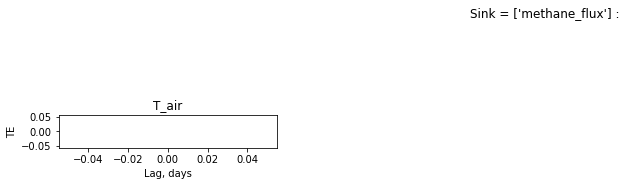

In [84]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[SourN[i]]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### Transformed, t-1

In [ ]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,10), np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([18]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

In [ ]:
# Applying TE on the anomaly data
#importlib.reload(TEpython3)

sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer2(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365,shift=sf)

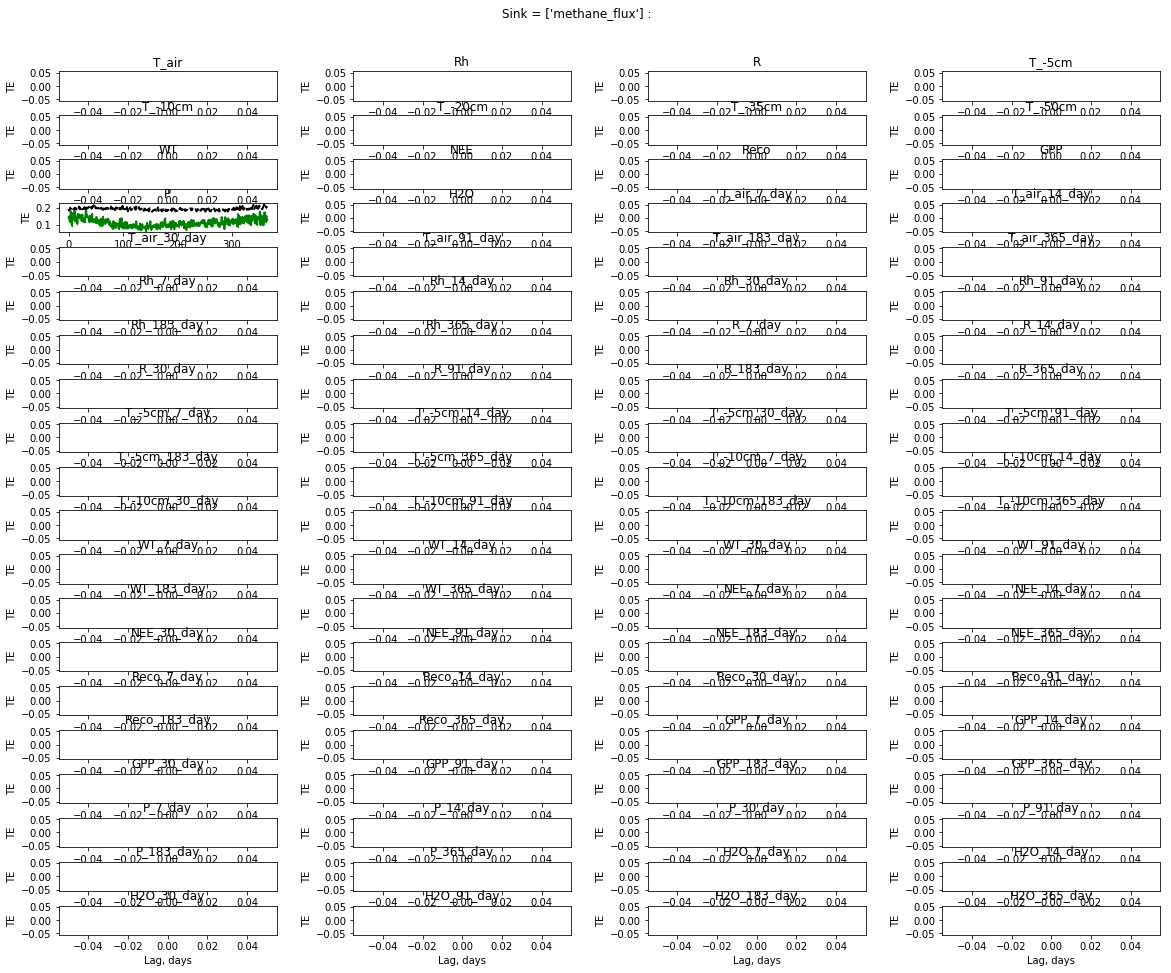

In [89]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[SourN[i]]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    if np.sum(~np.isnan(AboveCritic[i,:])):
        LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### Transformed, t-tau

In [ ]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,10), np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([18]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

In [ ]:
# Applying TE on the anomaly data
importlib.reload(TEpython3)

#sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365)

In [ ]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title((LabelC[SourN[i]]))
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### Non transformed, t-tau

In [129]:
# Adjust input for TE 
Table = copy.deepcopy(AnoTable)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,13), 14:numVr]
SinN = np.array([13]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

['DateTime' 'methane_flux' 'T_air' 'Rh' 'R' 'T_-5cm' 'T_-10cm' 'T_-20cm'
 'T_-35cm' 'T_-50cm' 'WT' 'NEE' 'Reco' 'GPP' 'P' 'T_air_7_day'
 'T_air_14_day' 'T_air_30_day' 'T_air_91_day' 'T_air_183_day'
 'T_air_365_day' 'Rh_7_day' 'Rh_14_day' 'Rh_30_day' 'Rh_91_day'
 'Rh_183_day' 'Rh_365_day' 'R_7_day' 'R_14_day' 'R_30_day' 'R_91_day'
 'R_183_day' 'R_365_day' 'T_-5cm_7_day' 'T_-5cm_14_day' 'T_-5cm_30_day'
 'T_-5cm_91_day' 'T_-5cm_183_day' 'T_-5cm_365_day' 'T_-10cm_7_day'
 'T_-10cm_14_day' 'T_-10cm_30_day' 'T_-10cm_91_day' 'T_-10cm_183_day'
 'T_-10cm_365_day' 'WT_7_day' 'WT_14_day' 'WT_30_day' 'WT_91_day'
 'WT_183_day' 'WT_365_day' 'NEE_7_day' 'NEE_14_day' 'NEE_30_day'
 'NEE_91_day' 'NEE_183_day' 'NEE_365_day' 'Reco_7_day' 'Reco_14_day'
 'Reco_30_day' 'Reco_91_day' 'Reco_183_day' 'Reco_365_day' 'GPP_7_day'
 'GPP_14_day' 'GPP_30_day' 'GPP_91_day' 'GPP_183_day' 'GPP_365_day'
 'P_7_day' 'P_14_day' 'P_30_day' 'P_91_day' 'P_183_day' 'P_365_day']


In [130]:
# Applying TE on the anomaly data
importlib.reload(TEpython3)

#sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=365)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 0 0
50 0 0
51 0 0
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 0 0
60 0 0
61 0 0
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 0 0
69 0 0
70 0 0
71 0 0
72 0 0
73 0 0
74 0 0
75 0 0
76 0 0
77 0 0
78 0 0
79 0 0
80 0 0
81 0 0
82 0 0
83 0 0
84 0 0
85 0 0
86 0 0
87 0 0
88 0 0
89 0 0
90 0 0
91 0 0
92 0 0
93 0 0
94 0 0
95 0 0
96 0 0
97 0 0
98 0 0
99 0 0
100 0 0
101 0 0
102 0 0
103 0 0
104 0 0
105 0 0
106 0 0
107 0 0
108 0 0
109 0 0
110 0 0
111 0 0
112 0 0
113 0 0
114 0 0
115 0 0
116 0 0
117 0 0
118 0 0
119 0 0
120 0 0
121 0 0
122 0 0
123 0 0
124 0 

305 0 2
306 0 2
307 0 2
308 0 2
309 0 2
310 0 2
311 0 2
312 0 2
313 0 2
314 0 2
315 0 2
316 0 2
317 0 2
318 0 2
319 0 2
320 0 2
321 0 2
322 0 2
323 0 2
324 0 2
325 0 2
326 0 2
327 0 2
328 0 2
329 0 2
330 0 2
331 0 2
332 0 2
333 0 2
334 0 2
335 0 2
336 0 2
337 0 2
338 0 2
339 0 2
340 0 2
341 0 2
342 0 2
343 0 2
344 0 2
345 0 2
346 0 2
347 0 2
348 0 2
349 0 2
350 0 2
351 0 2
352 0 2
353 0 2
354 0 2
355 0 2
356 0 2
357 0 2
358 0 2
359 0 2
360 0 2
361 0 2
362 0 2
363 0 2
364 0 2
Source node  3 T_-5cm :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 3
1 0 3
2 0 3
3 0 3
4 0 3
5 0 3
6 0 3
7 0 3
8 0 3
9 0 3
10 0 3
11 0 3
12 0 3
13 0 3
14 0 3
15 0 3
16 0 3
17 0 3
18 0 3
19 0 3
20 0 3
21 0 3
22 0 3
23 0 3
24 0 3
25 0 3
26 0 3
27 0 3
28 0 3
29 0 3
30 0 3
31 0 3
32 0 3
33 0 3
34 0 3
35 0 3
36 0 3
37 0 3
38 0 3
39 0 3
40 0 3
41 0 3
42 0 3
43 0 3
44 0 3
45 0 3
46 0 3
47 0 3
48 0 3
49 0 3
50 0 3
51 0 3
52 0 3
53 0 3
54 0 3
55 0 3
56 0 3
57 0 3
58 0 3
59 0 3
60 0 3
61 0 3
62 0 3
63 0 3
64 0 3
65 0 

250 0 5
251 0 5
252 0 5
253 0 5
254 0 5
255 0 5
256 0 5
257 0 5
258 0 5
259 0 5
260 0 5
261 0 5
262 0 5
263 0 5
264 0 5
265 0 5
266 0 5
267 0 5
268 0 5
269 0 5
270 0 5
271 0 5
272 0 5
273 0 5
274 0 5
275 0 5
276 0 5
277 0 5
278 0 5
279 0 5
280 0 5
281 0 5
282 0 5
283 0 5
284 0 5
285 0 5
286 0 5
287 0 5
288 0 5
289 0 5
290 0 5
291 0 5
292 0 5
293 0 5
294 0 5
295 0 5
296 0 5
297 0 5
298 0 5
299 0 5
300 0 5
301 0 5
302 0 5
303 0 5
304 0 5
305 0 5
306 0 5
307 0 5
308 0 5
309 0 5
310 0 5
311 0 5
312 0 5
313 0 5
314 0 5
315 0 5
316 0 5
317 0 5
318 0 5
319 0 5
320 0 5
321 0 5
322 0 5
323 0 5
324 0 5
325 0 5
326 0 5
327 0 5
328 0 5
329 0 5
330 0 5
331 0 5
332 0 5
333 0 5
334 0 5
335 0 5
336 0 5
337 0 5
338 0 5
339 0 5
340 0 5
341 0 5
342 0 5
343 0 5
344 0 5
345 0 5
346 0 5
347 0 5
348 0 5
349 0 5
350 0 5
351 0 5
352 0 5
353 0 5
354 0 5
355 0 5
356 0 5
357 0 5
358 0 5
359 0 5
360 0 5
361 0 5
362 0 5
363 0 5
364 0 5
Source node  6 T_-35cm :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 6
1 0

196 0 8
197 0 8
198 0 8
199 0 8
200 0 8
201 0 8
202 0 8
203 0 8
204 0 8
205 0 8
206 0 8
207 0 8
208 0 8
209 0 8
210 0 8
211 0 8
212 0 8
213 0 8
214 0 8
215 0 8
216 0 8
217 0 8
218 0 8
219 0 8
220 0 8
221 0 8
222 0 8
223 0 8
224 0 8
225 0 8
226 0 8
227 0 8
228 0 8
229 0 8
230 0 8
231 0 8
232 0 8
233 0 8
234 0 8
235 0 8
236 0 8
237 0 8
238 0 8
239 0 8
240 0 8
241 0 8
242 0 8
243 0 8
244 0 8
245 0 8
246 0 8
247 0 8
248 0 8
249 0 8
250 0 8
251 0 8
252 0 8
253 0 8
254 0 8
255 0 8
256 0 8
257 0 8
258 0 8
259 0 8
260 0 8
261 0 8
262 0 8
263 0 8
264 0 8
265 0 8
266 0 8
267 0 8
268 0 8
269 0 8
270 0 8
271 0 8
272 0 8
273 0 8
274 0 8
275 0 8
276 0 8
277 0 8
278 0 8
279 0 8
280 0 8
281 0 8
282 0 8
283 0 8
284 0 8
285 0 8
286 0 8
287 0 8
288 0 8
289 0 8
290 0 8
291 0 8
292 0 8
293 0 8
294 0 8
295 0 8
296 0 8
297 0 8
298 0 8
299 0 8
300 0 8
301 0 8
302 0 8
303 0 8
304 0 8
305 0 8
306 0 8
307 0 8
308 0 8
309 0 8
310 0 8
311 0 8
312 0 8
313 0 8
314 0 8
315 0 8
316 0 8
317 0 8
318 0 8
319 0 8
320 0 8


83 0 11
84 0 11
85 0 11
86 0 11
87 0 11
88 0 11
89 0 11
90 0 11
91 0 11
92 0 11
93 0 11
94 0 11
95 0 11
96 0 11
97 0 11
98 0 11
99 0 11
100 0 11
101 0 11
102 0 11
103 0 11
104 0 11
105 0 11
106 0 11
107 0 11
108 0 11
109 0 11
110 0 11
111 0 11
112 0 11
113 0 11
114 0 11
115 0 11
116 0 11
117 0 11
118 0 11
119 0 11
120 0 11
121 0 11
122 0 11
123 0 11
124 0 11
125 0 11
126 0 11
127 0 11
128 0 11
129 0 11
130 0 11
131 0 11
132 0 11
133 0 11
134 0 11
135 0 11
136 0 11
137 0 11
138 0 11
139 0 11
140 0 11
141 0 11
142 0 11
143 0 11
144 0 11
145 0 11
146 0 11
147 0 11
148 0 11
149 0 11
150 0 11
151 0 11
152 0 11
153 0 11
154 0 11
155 0 11
156 0 11
157 0 11
158 0 11
159 0 11
160 0 11
161 0 11
162 0 11
163 0 11
164 0 11
165 0 11
166 0 11
167 0 11
168 0 11
169 0 11
170 0 11
171 0 11
172 0 11
173 0 11
174 0 11
175 0 11
176 0 11
177 0 11
178 0 11
179 0 11
180 0 11
181 0 11
182 0 11
183 0 11
184 0 11
185 0 11
186 0 11
187 0 11
188 0 11
189 0 11
190 0 11
191 0 11
192 0 11
193 0 11
194 0 11
195 0 11


274 0 13
275 0 13
276 0 13
277 0 13
278 0 13
279 0 13
280 0 13
281 0 13
282 0 13
283 0 13
284 0 13
285 0 13
286 0 13
287 0 13
288 0 13
289 0 13
290 0 13
291 0 13
292 0 13
293 0 13
294 0 13
295 0 13
296 0 13
297 0 13
298 0 13
299 0 13
300 0 13
301 0 13
302 0 13
303 0 13
304 0 13
305 0 13
306 0 13
307 0 13
308 0 13
309 0 13
310 0 13
311 0 13
312 0 13
313 0 13
314 0 13
315 0 13
316 0 13
317 0 13
318 0 13
319 0 13
320 0 13
321 0 13
322 0 13
323 0 13
324 0 13
325 0 13
326 0 13
327 0 13
328 0 13
329 0 13
330 0 13
331 0 13
332 0 13
333 0 13
334 0 13
335 0 13
336 0 13
337 0 13
338 0 13
339 0 13
340 0 13
341 0 13
342 0 13
343 0 13
344 0 13
345 0 13
346 0 13
347 0 13
348 0 13
349 0 13
350 0 13
351 0 13
352 0 13
353 0 13
354 0 13
355 0 13
356 0 13
357 0 13
358 0 13
359 0 13
360 0 13
361 0 13
362 0 13
363 0 13
364 0 13
Source node  15 T_air_14_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 14
1 0 14
2 0 14
3 0 14
4 0 14
5 0 14
6 0 14
7 0 14
8 0 14
9 0 14
10 0 14
11 0 14
12 0 14
13 0 14
14

102 0 16
103 0 16
104 0 16
105 0 16
106 0 16
107 0 16
108 0 16
109 0 16
110 0 16
111 0 16
112 0 16
113 0 16
114 0 16
115 0 16
116 0 16
117 0 16
118 0 16
119 0 16
120 0 16
121 0 16
122 0 16
123 0 16
124 0 16
125 0 16
126 0 16
127 0 16
128 0 16
129 0 16
130 0 16
131 0 16
132 0 16
133 0 16
134 0 16
135 0 16
136 0 16
137 0 16
138 0 16
139 0 16
140 0 16
141 0 16
142 0 16
143 0 16
144 0 16
145 0 16
146 0 16
147 0 16
148 0 16
149 0 16
150 0 16
151 0 16
152 0 16
153 0 16
154 0 16
155 0 16
156 0 16
157 0 16
158 0 16
159 0 16
160 0 16
161 0 16
162 0 16
163 0 16
164 0 16
165 0 16
166 0 16
167 0 16
168 0 16
169 0 16
170 0 16
171 0 16
172 0 16
173 0 16
174 0 16
175 0 16
176 0 16
177 0 16
178 0 16
179 0 16
180 0 16
181 0 16
182 0 16
183 0 16
184 0 16
185 0 16
186 0 16
187 0 16
188 0 16
189 0 16
190 0 16
191 0 16
192 0 16
193 0 16
194 0 16
195 0 16
196 0 16
197 0 16
198 0 16
199 0 16
200 0 16
201 0 16
202 0 16
203 0 16
204 0 16
205 0 16
206 0 16
207 0 16
208 0 16
209 0 16
210 0 16
211 0 16
212 0 16
2

291 0 18
292 0 18
293 0 18
294 0 18
295 0 18
296 0 18
297 0 18
298 0 18
299 0 18
300 0 18
301 0 18
302 0 18
303 0 18
304 0 18
305 0 18
306 0 18
307 0 18
308 0 18
309 0 18
310 0 18
311 0 18
312 0 18
313 0 18
314 0 18
315 0 18
316 0 18
317 0 18
318 0 18
319 0 18
320 0 18
321 0 18
322 0 18
323 0 18
324 0 18
325 0 18
326 0 18
327 0 18
328 0 18
329 0 18
330 0 18
331 0 18
332 0 18
333 0 18
334 0 18
335 0 18
336 0 18
337 0 18
338 0 18
339 0 18
340 0 18
341 0 18
342 0 18
343 0 18
344 0 18
345 0 18
346 0 18
347 0 18
348 0 18
349 0 18
350 0 18
351 0 18
352 0 18
353 0 18
354 0 18
355 0 18
356 0 18
357 0 18
358 0 18
359 0 18
360 0 18
361 0 18
362 0 18
363 0 18
364 0 18
Source node  20 Rh_7_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 19
1 0 19
2 0 19
3 0 19
4 0 19
5 0 19
6 0 19
7 0 19
8 0 19
9 0 19
10 0 19
11 0 19
12 0 19
13 0 19
14 0 19
15 0 19
16 0 19
17 0 19
18 0 19
19 0 19
20 0 19
21 0 19
22 0 19
23 0 19
24 0 19
25 0 19
26 0 19
27 0 19
28 0 19
29 0 19
30 0 19
31 0 19
32 0 19
33 0 19

119 0 21
120 0 21
121 0 21
122 0 21
123 0 21
124 0 21
125 0 21
126 0 21
127 0 21
128 0 21
129 0 21
130 0 21
131 0 21
132 0 21
133 0 21
134 0 21
135 0 21
136 0 21
137 0 21
138 0 21
139 0 21
140 0 21
141 0 21
142 0 21
143 0 21
144 0 21
145 0 21
146 0 21
147 0 21
148 0 21
149 0 21
150 0 21
151 0 21
152 0 21
153 0 21
154 0 21
155 0 21
156 0 21
157 0 21
158 0 21
159 0 21
160 0 21
161 0 21
162 0 21
163 0 21
164 0 21
165 0 21
166 0 21
167 0 21
168 0 21
169 0 21
170 0 21
171 0 21
172 0 21
173 0 21
174 0 21
175 0 21
176 0 21
177 0 21
178 0 21
179 0 21
180 0 21
181 0 21
182 0 21
183 0 21
184 0 21
185 0 21
186 0 21
187 0 21
188 0 21
189 0 21
190 0 21
191 0 21
192 0 21
193 0 21
194 0 21
195 0 21
196 0 21
197 0 21
198 0 21
199 0 21
200 0 21
201 0 21
202 0 21
203 0 21
204 0 21
205 0 21
206 0 21
207 0 21
208 0 21
209 0 21
210 0 21
211 0 21
212 0 21
213 0 21
214 0 21
215 0 21
216 0 21
217 0 21
218 0 21
219 0 21
220 0 21
221 0 21
222 0 21
223 0 21
224 0 21
225 0 21
226 0 21
227 0 21
228 0 21
229 0 21
2

309 0 23
310 0 23
311 0 23
312 0 23
313 0 23
314 0 23
315 0 23
316 0 23
317 0 23
318 0 23
319 0 23
320 0 23
321 0 23
322 0 23
323 0 23
324 0 23
325 0 23
326 0 23
327 0 23
328 0 23
329 0 23
330 0 23
331 0 23
332 0 23
333 0 23
334 0 23
335 0 23
336 0 23
337 0 23
338 0 23
339 0 23
340 0 23
341 0 23
342 0 23
343 0 23
344 0 23
345 0 23
346 0 23
347 0 23
348 0 23
349 0 23
350 0 23
351 0 23
352 0 23
353 0 23
354 0 23
355 0 23
356 0 23
357 0 23
358 0 23
359 0 23
360 0 23
361 0 23
362 0 23
363 0 23
364 0 23
Source node  25 Rh_365_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 24
1 0 24
2 0 24
3 0 24
4 0 24
5 0 24
6 0 24
7 0 24
8 0 24
9 0 24
10 0 24
11 0 24
12 0 24
13 0 24
14 0 24
15 0 24
16 0 24
17 0 24
18 0 24
19 0 24
20 0 24
21 0 24
22 0 24
23 0 24
24 0 24
25 0 24
26 0 24
27 0 24
28 0 24
29 0 24
30 0 24
31 0 24
32 0 24
33 0 24
34 0 24
35 0 24
36 0 24
37 0 24
38 0 24
39 0 24
40 0 24
41 0 24
42 0 24
43 0 24
44 0 24
45 0 24
46 0 24
47 0 24
48 0 24
49 0 24
50 0 24
51 0 24
52 0 24
53 0 24

137 0 26
138 0 26
139 0 26
140 0 26
141 0 26
142 0 26
143 0 26
144 0 26
145 0 26
146 0 26
147 0 26
148 0 26
149 0 26
150 0 26
151 0 26
152 0 26
153 0 26
154 0 26
155 0 26
156 0 26
157 0 26
158 0 26
159 0 26
160 0 26
161 0 26
162 0 26
163 0 26
164 0 26
165 0 26
166 0 26
167 0 26
168 0 26
169 0 26
170 0 26
171 0 26
172 0 26
173 0 26
174 0 26
175 0 26
176 0 26
177 0 26
178 0 26
179 0 26
180 0 26
181 0 26
182 0 26
183 0 26
184 0 26
185 0 26
186 0 26
187 0 26
188 0 26
189 0 26
190 0 26
191 0 26
192 0 26
193 0 26
194 0 26
195 0 26
196 0 26
197 0 26
198 0 26
199 0 26
200 0 26
201 0 26
202 0 26
203 0 26
204 0 26
205 0 26
206 0 26
207 0 26
208 0 26
209 0 26
210 0 26
211 0 26
212 0 26
213 0 26
214 0 26
215 0 26
216 0 26
217 0 26
218 0 26
219 0 26
220 0 26
221 0 26
222 0 26
223 0 26
224 0 26
225 0 26
226 0 26
227 0 26
228 0 26
229 0 26
230 0 26
231 0 26
232 0 26
233 0 26
234 0 26
235 0 26
236 0 26
237 0 26
238 0 26
239 0 26
240 0 26
241 0 26
242 0 26
243 0 26
244 0 26
245 0 26
246 0 26
247 0 26
2

327 0 28
328 0 28
329 0 28
330 0 28
331 0 28
332 0 28
333 0 28
334 0 28
335 0 28
336 0 28
337 0 28
338 0 28
339 0 28
340 0 28
341 0 28
342 0 28
343 0 28
344 0 28
345 0 28
346 0 28
347 0 28
348 0 28
349 0 28
350 0 28
351 0 28
352 0 28
353 0 28
354 0 28
355 0 28
356 0 28
357 0 28
358 0 28
359 0 28
360 0 28
361 0 28
362 0 28
363 0 28
364 0 28
Source node  30 R_183_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 29
1 0 29
2 0 29
3 0 29
4 0 29
5 0 29
6 0 29
7 0 29
8 0 29
9 0 29
10 0 29
11 0 29
12 0 29
13 0 29
14 0 29
15 0 29
16 0 29
17 0 29
18 0 29
19 0 29
20 0 29
21 0 29
22 0 29
23 0 29
24 0 29
25 0 29
26 0 29
27 0 29
28 0 29
29 0 29
30 0 29
31 0 29
32 0 29
33 0 29
34 0 29
35 0 29
36 0 29
37 0 29
38 0 29
39 0 29
40 0 29
41 0 29
42 0 29
43 0 29
44 0 29
45 0 29
46 0 29
47 0 29
48 0 29
49 0 29
50 0 29
51 0 29
52 0 29
53 0 29
54 0 29
55 0 29
56 0 29
57 0 29
58 0 29
59 0 29
60 0 29
61 0 29
62 0 29
63 0 29
64 0 29
65 0 29
66 0 29
67 0 29
68 0 29
69 0 29
70 0 29
71 0 29
72 0 29
73 0 29
74

154 0 31
155 0 31
156 0 31
157 0 31
158 0 31
159 0 31
160 0 31
161 0 31
162 0 31
163 0 31
164 0 31
165 0 31
166 0 31
167 0 31
168 0 31
169 0 31
170 0 31
171 0 31
172 0 31
173 0 31
174 0 31
175 0 31
176 0 31
177 0 31
178 0 31
179 0 31
180 0 31
181 0 31
182 0 31
183 0 31
184 0 31
185 0 31
186 0 31
187 0 31
188 0 31
189 0 31
190 0 31
191 0 31
192 0 31
193 0 31
194 0 31
195 0 31
196 0 31
197 0 31
198 0 31
199 0 31
200 0 31
201 0 31
202 0 31
203 0 31
204 0 31
205 0 31
206 0 31
207 0 31
208 0 31
209 0 31
210 0 31
211 0 31
212 0 31
213 0 31
214 0 31
215 0 31
216 0 31
217 0 31
218 0 31
219 0 31
220 0 31
221 0 31
222 0 31
223 0 31
224 0 31
225 0 31
226 0 31
227 0 31
228 0 31
229 0 31
230 0 31
231 0 31
232 0 31
233 0 31
234 0 31
235 0 31
236 0 31
237 0 31
238 0 31
239 0 31
240 0 31
241 0 31
242 0 31
243 0 31
244 0 31
245 0 31
246 0 31
247 0 31
248 0 31
249 0 31
250 0 31
251 0 31
252 0 31
253 0 31
254 0 31
255 0 31
256 0 31
257 0 31
258 0 31
259 0 31
260 0 31
261 0 31
262 0 31
263 0 31
264 0 31
2

342 0 33
343 0 33
344 0 33
345 0 33
346 0 33
347 0 33
348 0 33
349 0 33
350 0 33
351 0 33
352 0 33
353 0 33
354 0 33
355 0 33
356 0 33
357 0 33
358 0 33
359 0 33
360 0 33
361 0 33
362 0 33
363 0 33
364 0 33
Source node  35 T_-5cm_91_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 34
1 0 34
2 0 34
3 0 34
4 0 34
5 0 34
6 0 34
7 0 34
8 0 34
9 0 34
10 0 34
11 0 34
12 0 34
13 0 34
14 0 34
15 0 34
16 0 34
17 0 34
18 0 34
19 0 34
20 0 34
21 0 34
22 0 34
23 0 34
24 0 34
25 0 34
26 0 34
27 0 34
28 0 34
29 0 34
30 0 34
31 0 34
32 0 34
33 0 34
34 0 34
35 0 34
36 0 34
37 0 34
38 0 34
39 0 34
40 0 34
41 0 34
42 0 34
43 0 34
44 0 34
45 0 34
46 0 34
47 0 34
48 0 34
49 0 34
50 0 34
51 0 34
52 0 34
53 0 34
54 0 34
55 0 34
56 0 34
57 0 34
58 0 34
59 0 34
60 0 34
61 0 34
62 0 34
63 0 34
64 0 34
65 0 34
66 0 34
67 0 34
68 0 34
69 0 34
70 0 34
71 0 34
72 0 34
73 0 34
74 0 34
75 0 34
76 0 34
77 0 34
78 0 34
79 0 34
80 0 34
81 0 34
82 0 34
83 0 34
84 0 34
85 0 34
86 0 34
87 0 34
88 0 34
89 0 34
90 0 

169 0 36
170 0 36
171 0 36
172 0 36
173 0 36
174 0 36
175 0 36
176 0 36
177 0 36
178 0 36
179 0 36
180 0 36
181 0 36
182 0 36
183 0 36
184 0 36
185 0 36
186 0 36
187 0 36
188 0 36
189 0 36
190 0 36
191 0 36
192 0 36
193 0 36
194 0 36
195 0 36
196 0 36
197 0 36
198 0 36
199 0 36
200 0 36
201 0 36
202 0 36
203 0 36
204 0 36
205 0 36
206 0 36
207 0 36
208 0 36
209 0 36
210 0 36
211 0 36
212 0 36
213 0 36
214 0 36
215 0 36
216 0 36
217 0 36
218 0 36
219 0 36
220 0 36
221 0 36
222 0 36
223 0 36
224 0 36
225 0 36
226 0 36
227 0 36
228 0 36
229 0 36
230 0 36
231 0 36
232 0 36
233 0 36
234 0 36
235 0 36
236 0 36
237 0 36
238 0 36
239 0 36
240 0 36
241 0 36
242 0 36
243 0 36
244 0 36
245 0 36
246 0 36
247 0 36
248 0 36
249 0 36
250 0 36
251 0 36
252 0 36
253 0 36
254 0 36
255 0 36
256 0 36
257 0 36
258 0 36
259 0 36
260 0 36
261 0 36
262 0 36
263 0 36
264 0 36
265 0 36
266 0 36
267 0 36
268 0 36
269 0 36
270 0 36
271 0 36
272 0 36
273 0 36
274 0 36
275 0 36
276 0 36
277 0 36
278 0 36
279 0 36
2

358 0 38
359 0 38
360 0 38
361 0 38
362 0 38
363 0 38
364 0 38
Source node  40 T_-10cm_30_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 39
1 0 39
2 0 39
3 0 39
4 0 39
5 0 39
6 0 39
7 0 39
8 0 39
9 0 39
10 0 39
11 0 39
12 0 39
13 0 39
14 0 39
15 0 39
16 0 39
17 0 39
18 0 39
19 0 39
20 0 39
21 0 39
22 0 39
23 0 39
24 0 39
25 0 39
26 0 39
27 0 39
28 0 39
29 0 39
30 0 39
31 0 39
32 0 39
33 0 39
34 0 39
35 0 39
36 0 39
37 0 39
38 0 39
39 0 39
40 0 39
41 0 39
42 0 39
43 0 39
44 0 39
45 0 39
46 0 39
47 0 39
48 0 39
49 0 39
50 0 39
51 0 39
52 0 39
53 0 39
54 0 39
55 0 39
56 0 39
57 0 39
58 0 39
59 0 39
60 0 39
61 0 39
62 0 39
63 0 39
64 0 39
65 0 39
66 0 39
67 0 39
68 0 39
69 0 39
70 0 39
71 0 39
72 0 39
73 0 39
74 0 39
75 0 39
76 0 39
77 0 39
78 0 39
79 0 39
80 0 39
81 0 39
82 0 39
83 0 39
84 0 39
85 0 39
86 0 39
87 0 39
88 0 39
89 0 39
90 0 39
91 0 39
92 0 39
93 0 39
94 0 39
95 0 39
96 0 39
97 0 39
98 0 39
99 0 39
100 0 39
101 0 39
102 0 39
103 0 39
104 0 39
105 0 39
106 0 39
107 0

185 0 41
186 0 41
187 0 41
188 0 41
189 0 41
190 0 41
191 0 41
192 0 41
193 0 41
194 0 41
195 0 41
196 0 41
197 0 41
198 0 41
199 0 41
200 0 41
201 0 41
202 0 41
203 0 41
204 0 41
205 0 41
206 0 41
207 0 41
208 0 41
209 0 41
210 0 41
211 0 41
212 0 41
213 0 41
214 0 41
215 0 41
216 0 41
217 0 41
218 0 41
219 0 41
220 0 41
221 0 41
222 0 41
223 0 41
224 0 41
225 0 41
226 0 41
227 0 41
228 0 41
229 0 41
230 0 41
231 0 41
232 0 41
233 0 41
234 0 41
235 0 41
236 0 41
237 0 41
238 0 41
239 0 41
240 0 41
241 0 41
242 0 41
243 0 41
244 0 41
245 0 41
246 0 41
247 0 41
248 0 41
249 0 41
250 0 41
251 0 41
252 0 41
253 0 41
254 0 41
255 0 41
256 0 41
257 0 41
258 0 41
259 0 41
260 0 41
261 0 41
262 0 41
263 0 41
264 0 41
265 0 41
266 0 41
267 0 41
268 0 41
269 0 41
270 0 41
271 0 41
272 0 41
273 0 41
274 0 41
275 0 41
276 0 41
277 0 41
278 0 41
279 0 41
280 0 41
281 0 41
282 0 41
283 0 41
284 0 41
285 0 41
286 0 41
287 0 41
288 0 41
289 0 41
290 0 41
291 0 41
292 0 41
293 0 41
294 0 41
295 0 41
2

0 0 44
1 0 44
2 0 44
3 0 44
4 0 44
5 0 44
6 0 44
7 0 44
8 0 44
9 0 44
10 0 44
11 0 44
12 0 44
13 0 44
14 0 44
15 0 44
16 0 44
17 0 44
18 0 44
19 0 44
20 0 44
21 0 44
22 0 44
23 0 44
24 0 44
25 0 44
26 0 44
27 0 44
28 0 44
29 0 44
30 0 44
31 0 44
32 0 44
33 0 44
34 0 44
35 0 44
36 0 44
37 0 44
38 0 44
39 0 44
40 0 44
41 0 44
42 0 44
43 0 44
44 0 44
45 0 44
46 0 44
47 0 44
48 0 44
49 0 44
50 0 44
51 0 44
52 0 44
53 0 44
54 0 44
55 0 44
56 0 44
57 0 44
58 0 44
59 0 44
60 0 44
61 0 44
62 0 44
63 0 44
64 0 44
65 0 44
66 0 44
67 0 44
68 0 44
69 0 44
70 0 44
71 0 44
72 0 44
73 0 44
74 0 44
75 0 44
76 0 44
77 0 44
78 0 44
79 0 44
80 0 44
81 0 44
82 0 44
83 0 44
84 0 44
85 0 44
86 0 44
87 0 44
88 0 44
89 0 44
90 0 44
91 0 44
92 0 44
93 0 44
94 0 44
95 0 44
96 0 44
97 0 44
98 0 44
99 0 44
100 0 44
101 0 44
102 0 44
103 0 44
104 0 44
105 0 44
106 0 44
107 0 44
108 0 44
109 0 44
110 0 44
111 0 44
112 0 44
113 0 44
114 0 44
115 0 44
116 0 44
117 0 44
118 0 44
119 0 44
120 0 44
121 0 44
122 0 44
123

202 0 46
203 0 46
204 0 46
205 0 46
206 0 46
207 0 46
208 0 46
209 0 46
210 0 46
211 0 46
212 0 46
213 0 46
214 0 46
215 0 46
216 0 46
217 0 46
218 0 46
219 0 46
220 0 46
221 0 46
222 0 46
223 0 46
224 0 46
225 0 46
226 0 46
227 0 46
228 0 46
229 0 46
230 0 46
231 0 46
232 0 46
233 0 46
234 0 46
235 0 46
236 0 46
237 0 46
238 0 46
239 0 46
240 0 46
241 0 46
242 0 46
243 0 46
244 0 46
245 0 46
246 0 46
247 0 46
248 0 46
249 0 46
250 0 46
251 0 46
252 0 46
253 0 46
254 0 46
255 0 46
256 0 46
257 0 46
258 0 46
259 0 46
260 0 46
261 0 46
262 0 46
263 0 46
264 0 46
265 0 46
266 0 46
267 0 46
268 0 46
269 0 46
270 0 46
271 0 46
272 0 46
273 0 46
274 0 46
275 0 46
276 0 46
277 0 46
278 0 46
279 0 46
280 0 46
281 0 46
282 0 46
283 0 46
284 0 46
285 0 46
286 0 46
287 0 46
288 0 46
289 0 46
290 0 46
291 0 46
292 0 46
293 0 46
294 0 46
295 0 46
296 0 46
297 0 46
298 0 46
299 0 46
300 0 46
301 0 46
302 0 46
303 0 46
304 0 46
305 0 46
306 0 46
307 0 46
308 0 46
309 0 46
310 0 46
311 0 46
312 0 46
3

22 0 49
23 0 49
24 0 49
25 0 49
26 0 49
27 0 49
28 0 49
29 0 49
30 0 49
31 0 49
32 0 49
33 0 49
34 0 49
35 0 49
36 0 49
37 0 49
38 0 49
39 0 49
40 0 49
41 0 49
42 0 49
43 0 49
44 0 49
45 0 49
46 0 49
47 0 49
48 0 49
49 0 49
50 0 49
51 0 49
52 0 49
53 0 49
54 0 49
55 0 49
56 0 49
57 0 49
58 0 49
59 0 49
60 0 49
61 0 49
62 0 49
63 0 49
64 0 49
65 0 49
66 0 49
67 0 49
68 0 49
69 0 49
70 0 49
71 0 49
72 0 49
73 0 49
74 0 49
75 0 49
76 0 49
77 0 49
78 0 49
79 0 49
80 0 49
81 0 49
82 0 49
83 0 49
84 0 49
85 0 49
86 0 49
87 0 49
88 0 49
89 0 49
90 0 49
91 0 49
92 0 49
93 0 49
94 0 49
95 0 49
96 0 49
97 0 49
98 0 49
99 0 49
100 0 49
101 0 49
102 0 49
103 0 49
104 0 49
105 0 49
106 0 49
107 0 49
108 0 49
109 0 49
110 0 49
111 0 49
112 0 49
113 0 49
114 0 49
115 0 49
116 0 49
117 0 49
118 0 49
119 0 49
120 0 49
121 0 49
122 0 49
123 0 49
124 0 49
125 0 49
126 0 49
127 0 49
128 0 49
129 0 49
130 0 49
131 0 49
132 0 49
133 0 49
134 0 49
135 0 49
136 0 49
137 0 49
138 0 49
139 0 49
140 0 49
141 0 4

219 0 51
220 0 51
221 0 51
222 0 51
223 0 51
224 0 51
225 0 51
226 0 51
227 0 51
228 0 51
229 0 51
230 0 51
231 0 51
232 0 51
233 0 51
234 0 51
235 0 51
236 0 51
237 0 51
238 0 51
239 0 51
240 0 51
241 0 51
242 0 51
243 0 51
244 0 51
245 0 51
246 0 51
247 0 51
248 0 51
249 0 51
250 0 51
251 0 51
252 0 51
253 0 51
254 0 51
255 0 51
256 0 51
257 0 51
258 0 51
259 0 51
260 0 51
261 0 51
262 0 51
263 0 51
264 0 51
265 0 51
266 0 51
267 0 51
268 0 51
269 0 51
270 0 51
271 0 51
272 0 51
273 0 51
274 0 51
275 0 51
276 0 51
277 0 51
278 0 51
279 0 51
280 0 51
281 0 51
282 0 51
283 0 51
284 0 51
285 0 51
286 0 51
287 0 51
288 0 51
289 0 51
290 0 51
291 0 51
292 0 51
293 0 51
294 0 51
295 0 51
296 0 51
297 0 51
298 0 51
299 0 51
300 0 51
301 0 51
302 0 51
303 0 51
304 0 51
305 0 51
306 0 51
307 0 51
308 0 51
309 0 51
310 0 51
311 0 51
312 0 51
313 0 51
314 0 51
315 0 51
316 0 51
317 0 51
318 0 51
319 0 51
320 0 51
321 0 51
322 0 51
323 0 51
324 0 51
325 0 51
326 0 51
327 0 51
328 0 51
329 0 51
3

40 0 54
41 0 54
42 0 54
43 0 54
44 0 54
45 0 54
46 0 54
47 0 54
48 0 54
49 0 54
50 0 54
51 0 54
52 0 54
53 0 54
54 0 54
55 0 54
56 0 54
57 0 54
58 0 54
59 0 54
60 0 54
61 0 54
62 0 54
63 0 54
64 0 54
65 0 54
66 0 54
67 0 54
68 0 54
69 0 54
70 0 54
71 0 54
72 0 54
73 0 54
74 0 54
75 0 54
76 0 54
77 0 54
78 0 54
79 0 54
80 0 54
81 0 54
82 0 54
83 0 54
84 0 54
85 0 54
86 0 54
87 0 54
88 0 54
89 0 54
90 0 54
91 0 54
92 0 54
93 0 54
94 0 54
95 0 54
96 0 54
97 0 54
98 0 54
99 0 54
100 0 54
101 0 54
102 0 54
103 0 54
104 0 54
105 0 54
106 0 54
107 0 54
108 0 54
109 0 54
110 0 54
111 0 54
112 0 54
113 0 54
114 0 54
115 0 54
116 0 54
117 0 54
118 0 54
119 0 54
120 0 54
121 0 54
122 0 54
123 0 54
124 0 54
125 0 54
126 0 54
127 0 54
128 0 54
129 0 54
130 0 54
131 0 54
132 0 54
133 0 54
134 0 54
135 0 54
136 0 54
137 0 54
138 0 54
139 0 54
140 0 54
141 0 54
142 0 54
143 0 54
144 0 54
145 0 54
146 0 54
147 0 54
148 0 54
149 0 54
150 0 54
151 0 54
152 0 54
153 0 54
154 0 54
155 0 54
156 0 54
157 0 5

235 0 56
236 0 56
237 0 56
238 0 56
239 0 56
240 0 56
241 0 56
242 0 56
243 0 56
244 0 56
245 0 56
246 0 56
247 0 56
248 0 56
249 0 56
250 0 56
251 0 56
252 0 56
253 0 56
254 0 56
255 0 56
256 0 56
257 0 56
258 0 56
259 0 56
260 0 56
261 0 56
262 0 56
263 0 56
264 0 56
265 0 56
266 0 56
267 0 56
268 0 56
269 0 56
270 0 56
271 0 56
272 0 56
273 0 56
274 0 56
275 0 56
276 0 56
277 0 56
278 0 56
279 0 56
280 0 56
281 0 56
282 0 56
283 0 56
284 0 56
285 0 56
286 0 56
287 0 56
288 0 56
289 0 56
290 0 56
291 0 56
292 0 56
293 0 56
294 0 56
295 0 56
296 0 56
297 0 56
298 0 56
299 0 56
300 0 56
301 0 56
302 0 56
303 0 56
304 0 56
305 0 56
306 0 56
307 0 56
308 0 56
309 0 56
310 0 56
311 0 56
312 0 56
313 0 56
314 0 56
315 0 56
316 0 56
317 0 56
318 0 56
319 0 56
320 0 56
321 0 56
322 0 56
323 0 56
324 0 56
325 0 56
326 0 56
327 0 56
328 0 56
329 0 56
330 0 56
331 0 56
332 0 56
333 0 56
334 0 56
335 0 56
336 0 56
337 0 56
338 0 56
339 0 56
340 0 56
341 0 56
342 0 56
343 0 56
344 0 56
345 0 56
3

57 0 59
58 0 59
59 0 59
60 0 59
61 0 59
62 0 59
63 0 59
64 0 59
65 0 59
66 0 59
67 0 59
68 0 59
69 0 59
70 0 59
71 0 59
72 0 59
73 0 59
74 0 59
75 0 59
76 0 59
77 0 59
78 0 59
79 0 59
80 0 59
81 0 59
82 0 59
83 0 59
84 0 59
85 0 59
86 0 59
87 0 59
88 0 59
89 0 59
90 0 59
91 0 59
92 0 59
93 0 59
94 0 59
95 0 59
96 0 59
97 0 59
98 0 59
99 0 59
100 0 59
101 0 59
102 0 59
103 0 59
104 0 59
105 0 59
106 0 59
107 0 59
108 0 59
109 0 59
110 0 59
111 0 59
112 0 59
113 0 59
114 0 59
115 0 59
116 0 59
117 0 59
118 0 59
119 0 59
120 0 59
121 0 59
122 0 59
123 0 59
124 0 59
125 0 59
126 0 59
127 0 59
128 0 59
129 0 59
130 0 59
131 0 59
132 0 59
133 0 59
134 0 59
135 0 59
136 0 59
137 0 59
138 0 59
139 0 59
140 0 59
141 0 59
142 0 59
143 0 59
144 0 59
145 0 59
146 0 59
147 0 59
148 0 59
149 0 59
150 0 59
151 0 59
152 0 59
153 0 59
154 0 59
155 0 59
156 0 59
157 0 59
158 0 59
159 0 59
160 0 59
161 0 59
162 0 59
163 0 59
164 0 59
165 0 59
166 0 59
167 0 59
168 0 59
169 0 59
170 0 59
171 0 59
172 0 59

251 0 61
252 0 61
253 0 61
254 0 61
255 0 61
256 0 61
257 0 61
258 0 61
259 0 61
260 0 61
261 0 61
262 0 61
263 0 61
264 0 61
265 0 61
266 0 61
267 0 61
268 0 61
269 0 61
270 0 61
271 0 61
272 0 61
273 0 61
274 0 61
275 0 61
276 0 61
277 0 61
278 0 61
279 0 61
280 0 61
281 0 61
282 0 61
283 0 61
284 0 61
285 0 61
286 0 61
287 0 61
288 0 61
289 0 61
290 0 61
291 0 61
292 0 61
293 0 61
294 0 61
295 0 61
296 0 61
297 0 61
298 0 61
299 0 61
300 0 61
301 0 61
302 0 61
303 0 61
304 0 61
305 0 61
306 0 61
307 0 61
308 0 61
309 0 61
310 0 61
311 0 61
312 0 61
313 0 61
314 0 61
315 0 61
316 0 61
317 0 61
318 0 61
319 0 61
320 0 61
321 0 61
322 0 61
323 0 61
324 0 61
325 0 61
326 0 61
327 0 61
328 0 61
329 0 61
330 0 61
331 0 61
332 0 61
333 0 61
334 0 61
335 0 61
336 0 61
337 0 61
338 0 61
339 0 61
340 0 61
341 0 61
342 0 61
343 0 61
344 0 61
345 0 61
346 0 61
347 0 61
348 0 61
349 0 61
350 0 61
351 0 61
352 0 61
353 0 61
354 0 61
355 0 61
356 0 61
357 0 61
358 0 61
359 0 61
360 0 61
361 0 61
3

76 0 64
77 0 64
78 0 64
79 0 64
80 0 64
81 0 64
82 0 64
83 0 64
84 0 64
85 0 64
86 0 64
87 0 64
88 0 64
89 0 64
90 0 64
91 0 64
92 0 64
93 0 64
94 0 64
95 0 64
96 0 64
97 0 64
98 0 64
99 0 64
100 0 64
101 0 64
102 0 64
103 0 64
104 0 64
105 0 64
106 0 64
107 0 64
108 0 64
109 0 64
110 0 64
111 0 64
112 0 64
113 0 64
114 0 64
115 0 64
116 0 64
117 0 64
118 0 64
119 0 64
120 0 64
121 0 64
122 0 64
123 0 64
124 0 64
125 0 64
126 0 64
127 0 64
128 0 64
129 0 64
130 0 64
131 0 64
132 0 64
133 0 64
134 0 64
135 0 64
136 0 64
137 0 64
138 0 64
139 0 64
140 0 64
141 0 64
142 0 64
143 0 64
144 0 64
145 0 64
146 0 64
147 0 64
148 0 64
149 0 64
150 0 64
151 0 64
152 0 64
153 0 64
154 0 64
155 0 64
156 0 64
157 0 64
158 0 64
159 0 64
160 0 64
161 0 64
162 0 64
163 0 64
164 0 64
165 0 64
166 0 64
167 0 64
168 0 64
169 0 64
170 0 64
171 0 64
172 0 64
173 0 64
174 0 64
175 0 64
176 0 64
177 0 64
178 0 64
179 0 64
180 0 64
181 0 64
182 0 64
183 0 64
184 0 64
185 0 64
186 0 64
187 0 64
188 0 64
189 0 6

267 0 66
268 0 66
269 0 66
270 0 66
271 0 66
272 0 66
273 0 66
274 0 66
275 0 66
276 0 66
277 0 66
278 0 66
279 0 66
280 0 66
281 0 66
282 0 66
283 0 66
284 0 66
285 0 66
286 0 66
287 0 66
288 0 66
289 0 66
290 0 66
291 0 66
292 0 66
293 0 66
294 0 66
295 0 66
296 0 66
297 0 66
298 0 66
299 0 66
300 0 66
301 0 66
302 0 66
303 0 66
304 0 66
305 0 66
306 0 66
307 0 66
308 0 66
309 0 66
310 0 66
311 0 66
312 0 66
313 0 66
314 0 66
315 0 66
316 0 66
317 0 66
318 0 66
319 0 66
320 0 66
321 0 66
322 0 66
323 0 66
324 0 66
325 0 66
326 0 66
327 0 66
328 0 66
329 0 66
330 0 66
331 0 66
332 0 66
333 0 66
334 0 66
335 0 66
336 0 66
337 0 66
338 0 66
339 0 66
340 0 66
341 0 66
342 0 66
343 0 66
344 0 66
345 0 66
346 0 66
347 0 66
348 0 66
349 0 66
350 0 66
351 0 66
352 0 66
353 0 66
354 0 66
355 0 66
356 0 66
357 0 66
358 0 66
359 0 66
360 0 66
361 0 66
362 0 66
363 0 66
364 0 66
Source node  68 P_7_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 67
1 0 67
2 0 67
3 0 67
4 0 67
5 0 67
6 0 

95 0 69
96 0 69
97 0 69
98 0 69
99 0 69
100 0 69
101 0 69
102 0 69
103 0 69
104 0 69
105 0 69
106 0 69
107 0 69
108 0 69
109 0 69
110 0 69
111 0 69
112 0 69
113 0 69
114 0 69
115 0 69
116 0 69
117 0 69
118 0 69
119 0 69
120 0 69
121 0 69
122 0 69
123 0 69
124 0 69
125 0 69
126 0 69
127 0 69
128 0 69
129 0 69
130 0 69
131 0 69
132 0 69
133 0 69
134 0 69
135 0 69
136 0 69
137 0 69
138 0 69
139 0 69
140 0 69
141 0 69
142 0 69
143 0 69
144 0 69
145 0 69
146 0 69
147 0 69
148 0 69
149 0 69
150 0 69
151 0 69
152 0 69
153 0 69
154 0 69
155 0 69
156 0 69
157 0 69
158 0 69
159 0 69
160 0 69
161 0 69
162 0 69
163 0 69
164 0 69
165 0 69
166 0 69
167 0 69
168 0 69
169 0 69
170 0 69
171 0 69
172 0 69
173 0 69
174 0 69
175 0 69
176 0 69
177 0 69
178 0 69
179 0 69
180 0 69
181 0 69
182 0 69
183 0 69
184 0 69
185 0 69
186 0 69
187 0 69
188 0 69
189 0 69
190 0 69
191 0 69
192 0 69
193 0 69
194 0 69
195 0 69
196 0 69
197 0 69
198 0 69
199 0 69
200 0 69
201 0 69
202 0 69
203 0 69
204 0 69
205 0 69
206 0 

284 0 71
285 0 71
286 0 71
287 0 71
288 0 71
289 0 71
290 0 71
291 0 71
292 0 71
293 0 71
294 0 71
295 0 71
296 0 71
297 0 71
298 0 71
299 0 71
300 0 71
301 0 71
302 0 71
303 0 71
304 0 71
305 0 71
306 0 71
307 0 71
308 0 71
309 0 71
310 0 71
311 0 71
312 0 71
313 0 71
314 0 71
315 0 71
316 0 71
317 0 71
318 0 71
319 0 71
320 0 71
321 0 71
322 0 71
323 0 71
324 0 71
325 0 71
326 0 71
327 0 71
328 0 71
329 0 71
330 0 71
331 0 71
332 0 71
333 0 71
334 0 71
335 0 71
336 0 71
337 0 71
338 0 71
339 0 71
340 0 71
341 0 71
342 0 71
343 0 71
344 0 71
345 0 71
346 0 71
347 0 71
348 0 71
349 0 71
350 0 71
351 0 71
352 0 71
353 0 71
354 0 71
355 0 71
356 0 71
357 0 71
358 0 71
359 0 71
360 0 71
361 0 71
362 0 71
363 0 71
364 0 71
Source node  73 P_365_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 72
1 0 72
2 0 72
3 0 72
4 0 72
5 0 72
6 0 72
7 0 72
8 0 72
9 0 72
10 0 72
11 0 72
12 0 72
13 0 72
14 0 72
15 0 72
16 0 72
17 0 72
18 0 72
19 0 72
20 0 72
21 0 72
22 0 72
23 0 72
24 0 72
25 0 72

In [ ]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 365

n = Tcube_store.shape[1]
plt.figure(figsize=[18,15])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
ACLabels = [] #Initialize an empty list that will contain the source variables for each row of AboveCritic
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    
    ACLabels.append(LabelC[SourN[i]])
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title(ACLabels[i])
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

## Observations and Notes

 - I have now run this in four different ways (1) Untransformed inputs, t-lag; (2) Transformed inputs, t-lag; (3) Untransformed inputs, t-1; and (4) Transformed inputs, t-1. These computations were run out to a lag of 365 days, and the Monte Carlo shuffling has only been done 100 times (change to 1000 for "final" runs). 
 
 - Conditioning on t-1 instead of t-lag results in no patterns of significance differentiable from chance. This makes sense, as the slow, low-frequency deviation from DOY average is not likely to be explained by other variables more than simply knowing the daily variable's anomaly at the last time step.
 - When you condition on t-tau, many variables become significant, up to time lags of about 60 days. Surprisingly, water table seemed particularly important here. 
 - Patterns of significance are stronger for untransformed data than transformed data. That is, large fluctuations away from the norm are more readily explainable by looking at other variables than small fluctuations. 
 
#### To do
 - Plot WT vs methane flux at lag of 5-50 or so days. Maybe also T at 50 cm depth. 

### Plots for non-transformed data (which emphasize extreme behavior)

In [ ]:
# Plot WT vs methane flux
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['WT'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('WT')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1


Very high methane fluxes only tend to occur when water table is average to above average (but not hugely above average), with a delay of 20-45 or so days. Very low fluxes tend to occur when water table is below average, with similar lag. 

In [ ]:
# Plot WT vs T_-50cm
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['T_-50cm'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('T_-50cm')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

For temperature at -50 cm, very high values only when temperature near average around 20 days ago. Very low values only when temparature is well above or below average.  Does this reflect water table dynamics?

In [ ]:
# Plot WT vs NEE
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['NEE'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('NEE')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

With a 20-day lag or so, as NEE becomes more positive, methane flux declines. Maybe this is because more aerobic respiration means less methanogenesis, combined with less GPP resulting in less substrate for methanogenesis.

In [ ]:
# Plot WT vs GPP
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['GPP'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('GPP')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

This shows a positive relationship between GPP and methane flux, strongest around a lag of 10-15 days.

In [ ]:
# Plot WT vs Reco
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['Reco'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('Reco')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

I don't see much of anything here. CH4 flux anomalies may be driven more by GPP anomalies than respiration.

In [ ]:
# Plot WT vs Rh
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['Rh'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('Rh')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

It seems that only variables consistently above the threshold (rather than above/below in a noisy fashion) have intelligible relationships (with the exception of GPP, which is flirting with the threshold but shows a relationship apparent in the scatterplots for the lags plotted).

### Plots for transformed variables

In [ ]:
# Plot WT vs methane flux
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['sqrt_methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['WT'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('WT')
    axs[count1, count2].set_ylabel('Lagged sqrt methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

The dynamic of higher WT, higher methane flux really seems to pop here, in almost a threshold fashion. Strongest at lag of 20-25 days.

In [ ]:
# Plot R vs methane flux
lag = np.arange(5, 55, 5)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    y = np.array(AnoTable.iloc[n:]['sqrt_methane_flux'])
    x = np.array(AnoTable.iloc[:-n]['R'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('R')
    axs[count1, count2].set_ylabel('Lagged sqrt methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

In [ ]:
plt.plot(AnoTable['WT'], AnoTable['T_-50cm'], '.')
plt.xlabel('WT')
plt.ylabel('T_-50cm')

In [ ]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[SourN]
minV = np.nanmin(AboveCritic)
maxV = np.nanmax(AboveCritic)

fig = plt.figure(1,figsize = (20,50)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='viridis', aspect=10) #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,15)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(ticksX)
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of anomaly series at Lag (days)',y=1.1)
plt.xlabel('TE at Lag (days)')

In [ ]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[7,5])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr)," ")
plt.title('Mutual Information')
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime).T,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

### 3. Moving average

In [3]:
# Read data table

table2 = pd.read_csv('Aggregated_Daily_for_MA.csv',header = 0,index_col = 'Year_Month_Day',parse_dates = True, infer_datetime_format = True,low_memory=False)

print(table2.shape)
table2.head(5)

(3652, 81)


,T_air,Rh,R,T_-5cm,T_-10cm,T_-20cm,T_-35cm,T_-50cm,WT,NEE,...,P_4_day,P_5_day,P_6_day,P_7_day,H2O_2_day,H2O_3_day,H2O_4_day,H2O_5_day,H2O_6_day,H2O_7_day
Year_Month_Day,,,,,,,,,,,,,,,,,,,,,
2005-01-01,-1.39,89.8,18.60,-0.04,-0.4,-0.2,0.5,1.30,9.16,0.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-02,-0.30,98.4,4.74,0.06,-0.4,-0.2,0.5,1.30,9.07,0.21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-03,-0.84,98.2,11.70,0.06,-0.4,-0.2,0.5,1.30,9.03,0.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,-2.58,99.9,11.20,0.04,-0.4,-0.2,0.5,1.30,8.66,0.26,...,2.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,-2.76,100.0,7.75,0.02,-0.4,-0.2,0.5,1.28,8.81,0.23,...,3.90,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
def fastshift(arr, num, fill_value=np.nan): #Fast shift of elements within array (from https://stackoverflow.com/questions/30399534/shift-elements-in-a-numpy-array)
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [5]:
def nanMA(df, win, ploton): #df = input dataframe, win = window of rolling mean (centered on datapoint). Win should be an odd number
    valid_entries = ~np.isnan(df.copy(deep=True))
    not_valid = np.isnan(df.copy(deep=True))
    if ploton:
        plt.figure(figsize = [20,5])
        plt.plot(df.values)
    df = df.fillna(0) #Replace nans with zeros
    rolling_mean = df.rolling(window=win).sum()/valid_entries.rolling(window=win).sum() #This is currently backwards-looking
    rolling_mean[~np.isfinite(rolling_mean)] = np.nan #Replace divide-by-zeros with nan
    shifted = fastshift(rolling_mean, -int(np.floor(win/2)))#shift the window to centered on the datapoint
    result = df - shifted
    result[not_valid] = np.nan
    if ploton:
        plt.plot(shifted)
        plt.figure(figsize=[20,5])
        plt.plot(result, 'r-')
    return result

#### Test with methane flux
By running the box below with different window sizes, it appears that a monthly (31-day) window is reasonable

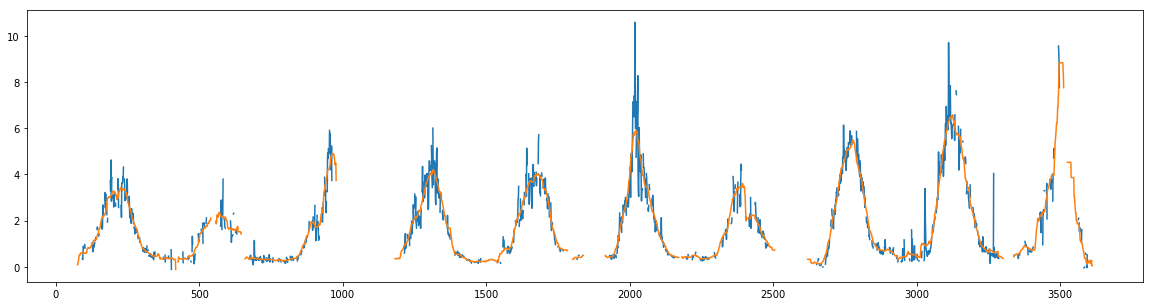

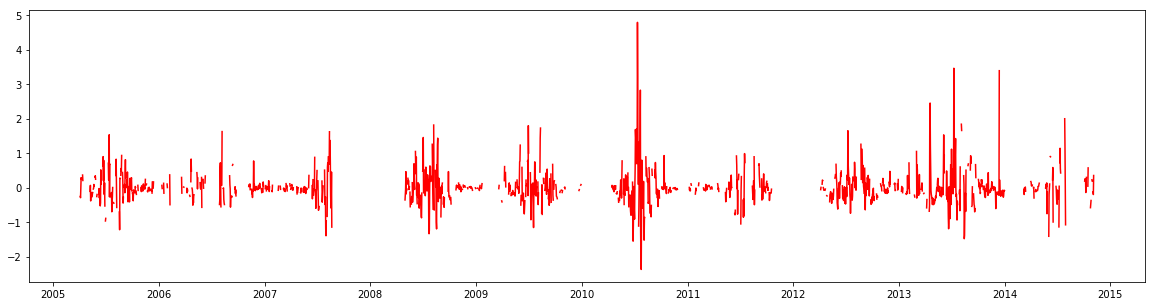

In [7]:
nanMA(table2['methane_flux'].copy(deep=True), 31, 1);

In [6]:
# Apply the moving window function
win = 31 
data = table2.copy(deep=True)
newData = data.apply(nanMA, axis=0, win=win, ploton=0) # 
newData.head(5)

,T_air,Rh,R,T_-5cm,T_-10cm,T_-20cm,T_-35cm,T_-50cm,WT,NEE,...,P_4_day,P_5_day,P_6_day,P_7_day,H2O_2_day,H2O_3_day,H2O_4_day,H2O_5_day,H2O_6_day,H2O_7_day
Year_Month_Day,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Evaluate autocorrelation functions.

In [11]:
count = 0
for column in newData:
    (r, sig_thr) = nanacf(newData.loc[:,column].values)
    #plt.figure()
    #plt.plot(r)
    #plt.plot(sig_thr, 'k--')
    #plt.plot(-sig_thr, 'k--')
    #plt.xlabel('lag')
    #plt.ylabel('autocorrelation')
    #plt.title(newData.columns[count])
    count = count + 1
    above_thr = r-sig_thr
    not_corr = np.where(above_thr<0)
    if np.min(np.size(not_corr))>0:
        
        per = not_corr[0][0]
    else:
        per = 999
    #print(np.size(per))
    if per <= 18: #Print out variables that have a period deemed acceptable for avoiding pseudoreplication (albeit subjective)
        print(column)
        print(per)

T_air
5
Rh
4
R
3
T_-5cm
6
T_-10cm
6
T_-20cm
7
T_-35cm
8
T_-50cm
9
WT
6
NEE
3
Reco
5
GPP
4
methane_flux
3
P
1
H2O
4
T_air_2_day
5
T_air_3_day
5
T_air_4_day
5
T_air_5_day
5
T_air_6_day
6
T_air_7_day
6
Rh_2_day
4
Rh_3_day
4
Rh_4_day
5
Rh_5_day
5
Rh_6_day
6
Rh_7_day
6
R_2_day
4
R_3_day
4
R_4_day
4
R_5_day
5
R_6_day
5
R_7_day
6
T_-5cm_2_day
6
T_-5cm_3_day
6
T_-5cm_4_day
6
T_-5cm_5_day
6
T_-5cm_6_day
7
T_-5cm_7_day
7
T_-10cm_2_day
6
T_-10cm_3_day
6
T_-10cm_4_day
7
T_-10cm_5_day
7
T_-10cm_6_day
7
T_-10cm_7_day
7
WT_2_day
7
WT_3_day
7
WT_4_day
7
WT_5_day
7
WT_6_day
7
WT_7_day
7
NEE_2_day
4
NEE_3_day
4
NEE_4_day
4
NEE_5_day
5
NEE_6_day
5
NEE_7_day
6
Reco_2_day
5
Reco_3_day
5
Reco_4_day
5
Reco_5_day
6
Reco_6_day
6
Reco_7_day
6
GPP_2_day
5
GPP_3_day
5
GPP_4_day
5
GPP_5_day
5
GPP_6_day
6
GPP_7_day
6
P_2_day
2
P_3_day
3
P_4_day
4
P_5_day
4
P_6_day
5
P_7_day
5
H2O_2_day
4
H2O_3_day
4
H2O_4_day
4
H2O_5_day
5
H2O_6_day
5
H2O_7_day
6


### Evaluate histograms

In [ ]:
count = 0
for column in newData:
    pylab.figure()
    pylab.hist((newData.loc[~np.isnan(newData[column]), column]))
    pylab.title(newData.columns[count])
    count = count + 1

## TE, Nontransformed, t-1

In [7]:
# Adjust input for TE 
Table = copy.deepcopy(newData)
numVr =  Table.shape[1] #3
data = copy.deepcopy(Table.iloc[:,np.arange(numVr)])
SourN = np.r_[np.arange(1,13), 14:numVr+1]# ,10)] transformed, np.arange(15, 18)]  # np.array([2,3])
SinN = np.array([13]) #18 transformed # transformed methane flux
LabelC = np.r_[np.array(['DateTime']),np.array(data.columns)]
DataM = pd.np.column_stack((data.index.astype(str), data.values))
print(np.r_[np.array([LabelC[0]]), np.array(LabelC[SinN]), np.array(LabelC[SourN])])
#LabelC, DataM[0:5,2], (data.shape)

['DateTime' 'methane_flux' 'T_air' 'Rh' 'R' 'T_-5cm' 'T_-10cm' 'T_-20cm'
 'T_-35cm' 'T_-50cm' 'WT' 'NEE' 'Reco' 'GPP' 'P' 'H2O' 'T_air_2_day'
 'T_air_3_day' 'T_air_4_day' 'T_air_5_day' 'T_air_6_day' 'T_air_7_day'
 'Rh_2_day' 'Rh_3_day' 'Rh_4_day' 'Rh_5_day' 'Rh_6_day' 'Rh_7_day'
 'R_2_day' 'R_3_day' 'R_4_day' 'R_5_day' 'R_6_day' 'R_7_day' 'T_-5cm_2_day'
 'T_-5cm_3_day' 'T_-5cm_4_day' 'T_-5cm_5_day' 'T_-5cm_6_day' 'T_-5cm_7_day'
 'T_-10cm_2_day' 'T_-10cm_3_day' 'T_-10cm_4_day' 'T_-10cm_5_day'
 'T_-10cm_6_day' 'T_-10cm_7_day' 'WT_2_day' 'WT_3_day' 'WT_4_day'
 'WT_5_day' 'WT_6_day' 'WT_7_day' 'NEE_2_day' 'NEE_3_day' 'NEE_4_day'
 'NEE_5_day' 'NEE_6_day' 'NEE_7_day' 'Reco_2_day' 'Reco_3_day' 'Reco_4_day'
 'Reco_5_day' 'Reco_6_day' 'Reco_7_day' 'GPP_2_day' 'GPP_3_day' 'GPP_4_day'
 'GPP_5_day' 'GPP_6_day' 'GPP_7_day' 'P_2_day' 'P_3_day' 'P_4_day'
 'P_5_day' 'P_6_day' 'P_7_day' 'H2O_2_day' 'H2O_3_day' 'H2O_4_day'
 'H2O_5_day' 'H2O_6_day' 'H2O_7_day']


In [26]:
#SCRATCH

#!/usr/bin/env python
# coding: utf-8

# ## This module contains the TE code translation from Matlab
# 
#       (MatLab version written by Laurel L. and modified by Dino B. Translation to Python by Edom M.)
# (Updated 2/25/20 by Laurel to accept inputs with NaNs.) 
# Subsequent major update on 3/9/20 by Laurel L. to calculate the TE significance threshold on M rather than Mshort. Previously, the truncated dataset (Mshort) was reshuffled and then relagged, which shortened the dataset further. Now, the data are shuffled and then resampled, lagged, and truncated as in the calculation of TE on the full dataset. Thus, different datapoints may go into the computation of TE for the shuffled probability distribution, but the number of datapoints is the same as in the original TE calculation. 

#Also new in this version: Resampling the data matrices based on the source data's autocorrelation function. This makes the computation more appropriate for information transfer due to low-frequency signals (e.g., day-of-year anomalies, as opposed to high-frequency anomalies calculated from moving average filters) because each feature of the signal is theoretically only sampled once. This avoids pseudoreplication.To turn this feature off, specify a period of 1 instead of per in the functions that are called internally in the RunNewTEVarsSer codes, but this is not recommended.


# The following functions are included in this module:
# 
# 1. Mutual information
# 
#     1. mutinfo_new(M, nbins) - Calculates mutual information I(x,y).
#     
#     
# 2. Tranfer entropy
# 
#     1. transen_new(M, lag, nbins) - Calculates transfer information - TE(x,y) x to y. x source M[:,0] and y the sink M[:,1].
#     
#     
# 3. Intermediate functions
# 
#     1. LagData_new - shifts a matrix so that it is rearranged to be ready for TE calculation as in Knutt et al., 2005
#     2. jointentropy_new(M, nbins) - Calculates the joint entropy H(x,y) 
#     3. jointentropy3_new(M, nbins) - Calculates the joint entropy for three variables H(x,y,z)
#     4. shuffle( M ) - shuffles the entries of the matrix M in time while keeping NaNs (blank data values) NaNs. So that, Monte Carlo is possible
#     5. transenshuffle_new(M, lag, nbins) - Calculates the transfer entropy for a shuffled time series that has already been lined up with LagData
#     
#     
# 4. Monte Carlo analysis of mutual information and transfer entropy
# 
#     1. mutinfo_crit_new( M, nbins, alpha, numiter) - Finds critical values of mutual information statistics that needs to be exceeded for statistical significance
#     2. transen_crit_new( M, lag, alpha, numiter, nbins) - Finds the critical value of the transfer entropy statistic that needs to be exceeded for statistical signficance
#     
# 
# 5. All in one code
#     1. RunNewTE2VarsSer(DataMatrix, LabelCell, SinkNodes, SourceNodes, resultsDir, maxLag, minSamples, numShuffles, sigLevel, numBins) - runs all together in serial mode.
#     2. RunNewTE2VarsSer2(DataMatrix, LabelCell, SinkNodes, SourceNodes, resultsDir, maxLag, minSamples, numShuffles, sigLevel, numBins) - runs all together in serial mode. Sink lag fixed at lag 1 for self optimality.


get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import copy
import os
np.random.seed(50)
from scipy.stats import norm


# In[2]:


def checkMakeDir2(dirName):  # 
    result = dirName
    result2 = dirName*2
    return result, result2


# In[4]:


# def checkMakeDir(dirName):
    


# ### Mutual information

# In[9]:


def mutinfo_new(M, nbins):
    # Calculates mutual information
    # M is an array with two columns [ source, sink]
    # nbins list of number of bins in 1D, 2D and 3D, with three elements
    ths = 1e-5
    this_col1 = M[:,0]
    counts1, binEdges1=np.histogram(this_col1[~np.isnan(this_col1)],bins=nbins[1]) # Source Variable. Figure out bin edges without NaNs.
    binEdges1[0] = binEdges1[0]-ths
    binEdges1[len(binEdges1)-1]=binEdges1[len(binEdges1)-1]+ths
    col1cat = np.digitize(M[:,0], binEdges1, right=False) #Bin index for each entry. NaN values are assigned to index = nbins + 1
    
    this_col2 = M[:,1]
    counts2, binEdges2=np.histogram(this_col2[~np.isnan(this_col2)],bins=nbins[1]) # Sink Variable
    binEdges2[0] = binEdges2[0]-ths
    binEdges2[len(binEdges2)-1]=binEdges2[len(binEdges2)-1]+ths
    col2cat = np.digitize(M[:,1], binEdges2, right=False)  # which bin (ID) is the data located. NaN values are assigned to index = nbins + 1
    #Now assign the NaN values to bin 0
    col1cat[col1cat==nbins[1]+1] = 0
    col2cat[col2cat==nbins[1]+1] = 0
    col1cat[col2cat==0] = 0 #If there is an NaN for any row, assign the other column in that row to the NaN bin too
    col2cat[col1cat==0] = 0 #If there is an NaN for any row, assign the other column in that row to the NaN bin too
    
    #print(col1cat)
    # convert 1D histogram to a 2D histogram
    jointentcat = (col1cat-1)*nbins[1]+col2cat #This classifies the joint entropy bin into a number between 1 and nbins^2. 0 is assigned to rows with misisng data.
    nbins_2 = nbins[1]**2
    N = np.bincount(jointentcat[jointentcat>0]) # Number of datapoints within each joint entropy bin, not including NaN bins.
    p = N/sum(N); # Vector of probabilities
    
    # 1D probability/histogram
    N1, binEdges1d1=np.histogram(this_col1[~np.isnan(this_col1)],bins=nbins[0]) # Which bin the first data column is in
    N2, binEdges1d2=np.histogram(this_col2[~np.isnan(this_col2)],bins=nbins[0]) #Which bin the second data column is in
    
    p1 = N1/sum(N1)
    p2 = N2/sum(N2)
    
    
    # Shanon entropy
    pgt0 = p[p>0]    # px,y
    p1gt0 = p1[p1>0] # px
    p2gt0 = p2[p2>0] # py
    
    
    log2p2gt0 = np.log2(p2gt0)
    #Shannon entropy of the sink variable. Used to normalize mutual informaiton in the next line.
    Hy = (-sum(p2gt0*log2p2gt0))
    # Mutual information, in bits. Joint entropy is scaled to the number of bins in a single dimension.
    I = ( (-sum(p1gt0*np.log2(p1gt0)) - sum(p2gt0*log2p2gt0) ) + (sum(pgt0*np.log2(pgt0)))*np.log2(nbins[0])/np.log2(nbins[1]))/Hy 
    # double integral in the last component is done as a 1D. 
        
    #return nbins_2, jointentcat,p , sum(N), I, Hy
    return I
    
    


# ## Intermediate functions

# In[13]:

def PickSampleInterval(X, maxlag=365, alpha=0.05): #Dynamically selects the appropriate interval for sampling the data, based on the autocorrelation function. Nans are OK. Alpha is the significance level for assessing the significance of the autocorrelation function.
    nX = len(X)
    r = np.zeros(maxlag)
    sig_thr = np.zeros(maxlag)
    for ii in range(maxlag):
        if ii == 0:
            Y = X
            Z = X
        else:
            Y = X[:-ii].copy()
            Z = X[ii:].copy()
        Y[np.isnan(Z)]=np.nan
        Z[np.isnan(Y)]=np.nan
            
        r[ii] = np.corrcoef(Y[~np.isnan(Y)], Z[~np.isnan(Z)])[0,1]
        sig_thr[ii] = norm.ppf(1-alpha/2)/np.sqrt(np.sum(~np.isnan(Y)))
 #   plt.plot(r)
 #   plt.xlabel('Lag')
 #   plt.ylabel('Autocorrelation')
    above_thr = r-sig_thr
    not_corr = np.where(above_thr<0)
    if np.min(np.size(not_corr))>0:
        
        per = not_corr[0][0] # "per" is the period. The data should be sampled once per period.
    else:
        per = maxlag
    return per


def LagData_new( M_unlagged, shift ):
    # LagData Shifts two time-series so that a matrix is generated that allows easy computation of Knutt et al 2005 based TE computation
    # M_unlagged is a matrix [X Y..n], where X and Y are column vectors of the
    # variables to be compared. shift is a row vector that says how much each
    # variable in M_unlagged is to be shifted by.
    
    nR,nC = np.shape(M_unlagged)
    maxShift = max(shift)
    minShift = min(shift)
    newlength = nR - maxShift + minShift
    M_lagged = np.nan*np.ones([newlength, nC]) #[source_lagged(1:n-lag), sink_unlagged(lag:n), sink_lagged(1:n-lag)]
    
    #@@@@@@@@@@@@@@######## Dino's verson uses shift of [0, 0, -lag ] for the shuffle case of transfer entropy (transenshuffle_new)
    for ii in range(np.shape(M_lagged)[1]):
        M_lagged[:,ii] = M_unlagged[(shift[ii]-minShift):(np.shape(M_unlagged)[0]-maxShift+shift[ii]), ii]
    
    return M_lagged

def ResampleLagged(M_lagged, per): #Resample the data in M to avoid pseudoreplication. Per is the output of PickSampleInterval.
    M_lagged = M_lagged[::per][:]
    return M_lagged

# Alternatively
#     lag = np.abs(shift[0])
#     M_lagged[:,0] = M_unlagged[0:(nR-lag), 0]
#     M_lagged[:,1] = M_unlagged[lag:(nR),1]
#     M_lagged[:,2] = M_unlagged[0:(nR-lag),2]
#    return M_lagged


# In[27]:


def jointentropy_new(M, nbins):
    # Calculates the joint entropy H(x,y)
    # M is two dimensional column matrix for which joint entropy is to be computed
    # H is the normalized joint entropy
    # nvalidpoints is the number of rows (samples) used to calculate the joint entropy
    
    ths = 1e-5 #tolerance
    this_col = M[:,0]
    counts1, binEdges1=np.histogram(this_col[~np.isnan(this_col)],bins=nbins) # Source Variable [ ]
    binEdges1[0] = binEdges1[0]-ths
    binEdges1[len(binEdges1)-1]=binEdges1[len(binEdges1)-1]+ths
    col1cat = np.digitize(M[:,0], binEdges1, right=False) #NaNs will be in bin nbins+1
    
    this_col = M[:,1]
    counts2, binEdges2=np.histogram(this_col[~np.isnan(this_col)],bins=nbins) # Sink Variable
    binEdges2[0] = binEdges2[0]-ths
    binEdges2[len(binEdges2)-1]=binEdges2[len(binEdges2)-1]+ths
    col2cat = np.digitize(M[:,1], binEdges2, right=False)  # which bin (ID) is the data located
    
    #Now assign the NaN values to bin 0
    col1cat[col1cat==nbins+1] = 0
    col2cat[col2cat==nbins+1] = 0
    col1cat[col2cat==0] = 0 #If there is an NaN for any row, assign the other column in that row to the NaN bin too
    col2cat[col1cat==0] = 0 #If there is an NaN for any row, assign the other column in that row to the NaN bin too
    
    #print(col1cat)
    # convert 1D histogram to a 2D histogram
    jointentcat = (col1cat-1)*nbins+col2cat #This classifies the joint entropy bin into a number between 1 and nbins^2. 0 is assigned to rows with misisng data.
    nbins_2 = nbins**2
    N = np.bincount(jointentcat[jointentcat>0]) # Number of datapoints within each joint entropy bin, not including NaN bins.
    p = N/sum(N); # Vector of probabilities
    
    pgt0 = p[p>0]    # p(x,y)
    H = -sum(pgt0*np.log2(pgt0))
    nvalidpoints = sum(N)
    
    return H, nvalidpoints


# In[29]:


def jointentropy3_new(M, nbins):
    # Calculates the joint entropy for three variables H(x,y,z)
    # M is a three-column matrix that contains the input vectors of data.
    # nvalidpoints is the number of rows (samples) used to calculate the joint entropy
    
    ths = 1e-5 #tolerance
    this_col = M[:,0] #Source variable
    counts1, binEdges1=np.histogram(this_col[~np.isnan(this_col)],bins=nbins) # Determine bin edges from non-NaN dataset
    binEdges1[0] = binEdges1[0]-ths
    binEdges1[len(binEdges1)-1]=binEdges1[len(binEdges1)-1]+ths
    col1cat = np.digitize(M[:,0], binEdges1, right=False)
    
    this_col = M[:,1] #Sink variable
    counts2, binEdges2=np.histogram(this_col[~np.isnan(this_col)],bins=nbins) # Determine bin edges from non-NaN dataset
    binEdges2[0] = binEdges2[0]-ths
    binEdges2[len(binEdges2)-1]=binEdges2[len(binEdges2)-1]+ths
    col2cat = np.digitize(M[:,1], binEdges2, right=False)  # which bin (ID) is the data located
    
    this_col = M[:,2] # Source variable
    counts3, binEdges3=np.histogram(this_col[~np.isnan(this_col)],bins=nbins) #  Determine bin edges from non-NaN dataset
    binEdges3[0] = binEdges3[0]-ths
    binEdges3[len(binEdges3)-1]=binEdges3[len(binEdges3)-1]+ths
    col3cat = np.digitize(M[:,2], binEdges3, right=False)
    
    #Now assign the NaN values to bin 0
    col1cat[col1cat==nbins+1] = 0
    col2cat[col2cat==nbins+1] = 0
    col3cat[col3cat==nbins+1] = 0
    #If there is an NaN for any row, assign the other column in that row to the NaN bin too
    col1cat[col2cat==0] = 0
    col1cat[col3cat==0] = 0
    col2cat[col1cat==0] = 0
    col3cat[col1cat==0] = 0
    
    # This classifies the joint entropy bin into a number between 1 and nbins^2. 0 is assigned to rows with misisng data.
    jointentcat = (col1cat-1)*nbins**2 + (col2cat-1)*nbins + col3cat 
    
    #print(np.asarray((jointentcat,col1cat,col2cat, col3cat)).T)
    
    nbins_3 = nbins**3
    N = np.bincount(jointentcat[jointentcat>0]) # Number of datapoints within each joint entropy bin.
    sumN = sum(N)
    
    
    p = N/sumN  # Vector of probabilities
    pgt0 = p[p>0]
    H = -sum(pgt0*np.log2(pgt0))
    nvalidpoints = sumN
    
    
    return H, nvalidpoints 


# In[32]:


def shuffle( M ):
    # shuffles the entries of the matrix M in time while keeping NaNs (blank data values) NaNs.
    # M is the matrix where the columns are individual variables and the rows are entries in time
    
    Mss = np.ones(np.shape(M))*np.nan # Initialize
    
    for n in range(np.shape(M)[1]): # Columns are shuffled separately
        notnans = np.argwhere(~np.isnan(M[:,n]))
        R = np.random.rand(np.shape(notnans)[0],1) #np.random.rand(5,1)
        I = np.argsort(R,axis=0)
        #print(notnans[:,0])
        #print(notnans[I,0])
        #print('a',M[notnans[:,0],n])
        Mss[notnans[:,0],n] = M[notnans[I[:],0],n].reshape(np.shape(notnans)[0],) #In the last version, the argument of np.shape() was M. This is not correct. It should be notnans. (Updated 2/25/20)
        
    return  Mss
    


# ## Transfer entropy

# In[34]:


def transen_new(M, lag, nbins, per=1, resample_on=0):
    # Calculates transfer information
    # M is an array with two columns [ source, sink]
    # nbins list of number of bins in 1D, 2D and 3D, with three elements
    # lag is the time lag of interest. 
    # per is the period for resampling (from PickSampleInterval)
    # resample_on is binary, indicating whether resampling in accordance with per should be done.It should be off for determining critical values, as that subroutine is passed an already-resampled matrix.
    # M4 is the lagged subset of data transfer entropy was run on. 
    
    M4 = LagData_new(np.column_stack((M, M[:,1])), [-lag, 0, -lag]) # source, sink, sink is input then 
    #  M4 becomes [source_lagged(1:n-lag), sink_unlagged(lag:n), sink_lagged(1:n-lag)]  => H(Xt-T, Yt, Yt-T)
    
    M4[np.argwhere(np.isnan(np.sum(M4,axis=1))), :] = np.nan # Reset rows with any NaN entry to NaN.
    M4 = ResampleLagged(M4, per) #Resample the lagged M by the autocorrelation-determined "period" to avoid pseudoreplication
    
    M1 = M4[:,(0,2)]  # [source_lagged(1:n-lag), sink_lagged(1:n-lag)]  =>H(Xt-T,Yt-T)
    M2 = M4[:,(1,2)] # [sink_unlagged(lag:n), sink_lagged(1:n-lag)]    =>H(Yt,Yt-T)
    
    #@@@@@@@@@@@@@@######## Dino uses M4[:,1]  to be predicted 
    M3 = M4[:,2]      # [sink_unlagged(lag:n)] to be predicted is used with DINO. BUT, need CORRECTION =>H(Yt) should be corrected to H(Yt-T) M[:,2]. Laurel's note: These two will have approximately the same entropy. The lagged version will just be the entropy over a partially truncated time series.
                      # Knutt et al indicates lagged being used H(Yt-T). Thus, M4[:,2]
    # Now calculate the joint and marginal entropy components:
    T1, n_valid_pairs1 = jointentropy_new(M1,nbins[1])
    T2, n_valid_pairs2 = jointentropy_new(M2,nbins[1])
    
    # Entropy for the single predictor
    n3, valueatn = np.histogram(M3[~np.isnan(M3)], nbins[0]) # results in count [n3] and the corresponding value. Updated 2/25/20 to do this just over non-NaNs.
    n3gt0 = n3[n3>0]
    sumn3gt0 = sum(n3gt0)
    T3 = -sum((n3gt0/sumn3gt0)*(np.log2(n3gt0/sumn3gt0))) # Nonnormalized Shannon entropy of variable Y
    
    # Three variable entropy
    T4, n_valid_pairs4 = jointentropy3_new(M4,nbins[2])
    
    Tn = T3 # This is the Shannon entropy of Y, used to normalize the value of transfer entropy obtained below.
    
    log2nbins1 = np.log2(nbins[0])
    log2nbins2 = np.log2(nbins[1])
    log2nbins3 = np.log2(nbins[2])
    log2nbins1_2 = log2nbins1/log2nbins2
    log2nbins1_3 = log2nbins1/log2nbins3
    T1 = T1*log2nbins1_2
    T2 = T2*log2nbins1_2
    T4 = T4*log2nbins1_3
    
    T = (T1+T2-T3-T4)/Tn # Knuth formulation of transfer entropy
    
    N = min([n_valid_pairs1, n_valid_pairs2, n_valid_pairs4]) # Number of valid matched pairs used in the calculation
    
    return T, N
    


# In[42]:


def transen_new2(M, shift, nbins, per): # with shift as an input different lags btween source and sink are possible
    # shift [-lag of source, 0, - lag of sink] # lag of sink usually being 1
    # Calculates transfer information
    # M is an array with two columns [ source, sink]
    # nbins list of number of bins in 1D, 2D and 3D, with three elements
    # lag is the time lag of interest. 
    # per is the period for resampling (from PickSampleInterval)
    # M4 is the lagged subset of data transfer entropy was run on. 
    
    checkM = copy.deepcopy(M)
    checkM[np.argwhere(np.isnan(np.sum(checkM,axis=1))), :] = np.nan
    print('M valid length before lagging is ', np.sum(~np.isnan(checkM), 0)[0])
    M4 = LagData_new(np.column_stack((M, M[:,1])), shift) # source, sink, sink is input then 
    #  M4 becomes [source_lagged(1:n-lag), sink_unlagged(lag:n), sink_lagged(1:n-lag)]  => H(Xt-T, Yt, Yt-T)
    
    M4[np.argwhere(np.isnan(np.sum(M4,axis=1))), :] = np.nan # Reset rows with any NaN entry to NaN.
    print('M4 valid length before resampling is ', np.sum(~np.isnan(M4), 0)[0])
    M4 = ResampleLagged(M4, per) #Resample the lagged M by the autocorrelation-determined "period" to avoid pseudoreplication
    print('M4 valid length after resampling is ', np.sum(~np.isnan(M4),0)[0])
    
    M1 = M4[:,(0,2)]  # [source_lagged(1:n-lag), sink_lagged(1:n-lag)]  =>H(Xt-T,Yt-T)
    M2 = M4[:,(1,2)] # [sink_unlagged(lag:n), sink_lagged(1:n-lag)]    =>H(Yt,Yt-T)
    
    #@@@@@@@@@@@@@@######## Dino uses M4[:,1]  to be predicted 
    M3 = M4[:,2]      # [sink_unlagged(lag:n)] to be predicted is used with DINO. BUT, need CORRECTION =>H(Yt) should be corrected to H(Yt-T) M[:,2]
                      # Knutt et al indicates lagged being used H(Yt-T). Thus, M4[:,2]
    # Now calculate the joint and marginal entropy components:
    T1, n_valid_pairs1 = jointentropy_new(M1,nbins[1])
    T2, n_valid_pairs2 = jointentropy_new(M2,nbins[1])
    
    # Entropy for the single predictor
    n3, valueatn = np.histogram(M3[~np.isnan(M3)], nbins[0]) # results in count [n3] and the corresponding value
    n3gt0 = n3[n3>0]
    sumn3gt0 = sum(n3gt0)
    T3 = -sum((n3gt0/sumn3gt0)*(np.log2(n3gt0/sumn3gt0))) # Nonnormalized Shannon entropy of variable Y
    
    # Three variable entropy
    T4, n_valid_pairs4 = jointentropy3_new(M4,nbins[2])
    
    Tn = T3 # This is the Shannon entropy of Y, used to normalize the value of transfer entropy obtained below.
    
    log2nbins1 = np.log2(nbins[0])
    log2nbins2 = np.log2(nbins[1])
    log2nbins3 = np.log2(nbins[2])
    log2nbins1_2 = log2nbins1/log2nbins2
    log2nbins1_3 = log2nbins1/log2nbins3
    T1 = T1*log2nbins1_2
    T2 = T2*log2nbins1_2
    T4 = T4*log2nbins1_3
    
    T = (T1+T2-T3-T4)/Tn # Knuth formulation of transfer entropy
    
    N = min([n_valid_pairs1, n_valid_pairs2, n_valid_pairs4]) # Number of valid matched pairs used in the calculation
    print('N is ', N)
    
    return T, N
    


# In[44]:


def transenshuffle_new(M, lag, nbins, per):
    
    # Calculates the transfer entropy for a shuffled time series that has already been lined up with LagData
    
    # Calculates the transfer entropy of X>Y, the amount by which knowledge
    #   of variable X at a time lag reduces the uncertainty in variable Y. M =
    #   [X Y], and lag is the time lag of interest. nbins is the number of bins
    #   used to discretize the probability distributions.
    # per is the period for resampling (from PickSampleInterval)
    
    
    Minput = shuffle(M[:,(0,1)])
    T, N = transen_new(Minput, lag, nbins, per)
   
    
    return T, N


# In[59]:


def transenshuffle_new2(M, shift, nbins, per):
    
    # Calculates the transfer entropy for a shuffled time series that has already been lined up with LagData
    
    # Calculates the transfer entropy of X>Y, the amount by which knowledge
    #   of variable X at a time lag reduces the uncertainty in variable Y. M =
    #   [X Y], and lag is the time lag of interest. nbins is the number of bins
    #   used to discretize the probability distributions.
    # per is the period for resampling (from PickSampleInterval)
    
    
    Minput = shuffle(M[:,(0,1)])
    T, N = transen_new2(Minput, shift, nbins, per)
   
    
    return T, N


# ## Critical values of Mutual information and Transfer entropy

# In[65]:


def mutinfo_crit_new( M, nbins, alpha, numiter):
    # Finds critical values of mutual information statistics that needs to be exceeded for statistical significance
    # M is the matrix where columns are the individual variables and rows ae the values in time.
    # nbins - number of bins 
    # alpha - is the significance level
    # numiter - is the number of Monte Carlo simulations for shuffling
    
    MIss = np.ones([numiter])*np.nan
    
    for ii in range(numiter):
        Mss = shuffle(M)
        MIss[ii] = mutinfo_new(Mss,nbins)
        #print(MIss.shape)
    
    MIss = np.sort(MIss)
    MIcrit = MIss[round((1-alpha)*numiter)] # develop a histogram and peak the 95% quantile significance level with alpha = 0.05
    
    return MIcrit


# In[67]:


def transen_crit_new( M, lag, alpha, numiter, nbins, per):
    
    # Finds the critical value of the transfer entropy statistic
    # that needs to be exceeded for statistical signficance.
    # M = matrix of unshifted variables, e.g., [X Y] for calculating the X>Y transfer entropy. 
    # lag = time lag. 
    # alpha = significance level. 
    # numiter = number of Monte Carlo shufflings to perform. 
    # nbins = number of bins to use to discretize the probability distributions.
    # per is the period for resampling (from PickSampleInterval)
    
    
    Tss = np.ones([numiter])*np.nan # Initializing shuffled transfer entropy table
    #print(Tss)
    
    for ii in range(numiter):
        Tss[ii], a = transenshuffle_new(M, lag, nbins, per) # Calculates TE for each Monte Carlo Shuffling
    
    #print(Tss)
    
    Tss = np.sort(Tss)
    Tcrit = Tss[round((1-alpha)*numiter)] # develop a histogram and peaks the 1-aplpha (95%) quantile significance level with alpha (= 0.05)
    
    return Tcrit
    


# In[68]:


def transen_crit_new2( M, shift, alpha, numiter, nbins, per):
    
    # Finds the critical value of the transfer entropy statistic
    # that needs to be exceeded for statistical signficance.
    # M = matrix of unshifted variables, e.g., [X Y] for calculating the X>Y transfer entropy. 
    # lag = time lag. 
    # alpha = significance level. 
    # numiter = number of Monte Carlo shufflings to perform. 
    # nbins = number of bins to use to discretize the probability distributions.
    # per is the period for resampling (from PickSampleInterval)
    
    
    Tss = np.ones([numiter])*np.nan # Initializing shuffled transfer entropy table
    #print(Tss)
    
    for ii in range(numiter):
        Tss[ii], a = transenshuffle_new2(M, shift, nbins, per) # Calculates TE for each Monte Carlo Shuffling
    
    #print(Tss)
    
    Tss = np.sort(Tss)
    Tcrit = Tss[round((1-alpha)*numiter)] # develop a histogram and peaks the 1-aplpha (95%) quantile significance level with alpha (= 0.05)
    
    return Tcrit

In [27]:
print(SinkNodes)

[13]


In [30]:
#SCRATCH
sf = [-1, 0, -1]
DataMatrix= DataM
LabelCell=LabelC
SinkNodes= SinN
SourceNodes=SourN
maxLag=60
shift=sf

nSources = len(SourceNodes)
nSinks = len(SinkNodes)
    
dataMat = np.column_stack((DataMatrix[:,0], DataMatrix[:,SinkNodes], DataMatrix[:,SourceNodes])) # date, sink, sources
labCell = np.r_[[np.array(LabelCell[0])], np.array(LabelCell[SinkNodes]), np.array(LabelCell[SourceNodes])]    
mySinkIter = 0
mySinkNum = SinkNodes[mySinkIter]
mySinkInd = 1 + mySinkIter  # exclude time
        
        
        # extract sub-matrices for the ease of computation
Ivec = Imat[mySinkIter,:]
Icritvec = Icritmat[mySinkIter,:]
Tfirstvec = Tfirstmat[mySinkIter,:]
Tbiggestvec = Tbiggestmat[mySinkIter,:]
Tmat_store = np.reshape(Tcube_store[mySinkIter,:,:],[nSources,maxLag])
Tcritmat_store = np.reshape(Tcritcube_store[mySinkIter,:,:], [nSources,maxLag])
sinkName = labCell[mySinkInd] # Text name of the Sink variable
MmySink = dataMat[:,mySinkInd]
mySourceIter = 0
mySourceNum = SourceNodes[mySourceIter]
mySourceInd = 1 + nSinks + mySourceIter
Mmysource = dataMat[:,mySourceInd] # Select source variables
sourceName = labCell[mySourceInd]  # Name of the source variable
print('Source node ', mySourceNum-1, sourceName, ':=>',  'Sink node ', mySinkNum, sinkName)
print('Lag ', 'Sink', 'Source')
            
per = PickSampleInterval(np.float64(Mmysource), maxLag, 0.01) #Pick the sample interval based on autocorrelation. New 3/8/20
print(per)
            
M = np.column_stack((Mmysource, MmySink)) # Source followed by Sink
M = M.astype('float')
print(np.shape(M))
            #print(M.shape)
            # MUTUAL INFORMATION
Mmut = ResampleLagged(M, per) #Resample to avoid pseudoreplication
print(np.shape(Mmut))

T = np.ones([maxLag])*np.nan # intialize the TE vector over the range of lags examined
Tcrit = copy.deepcopy(T) # Initialize the vector of the critical TE
lag = 1
t, N = transen_new2(M=M, shift=[-lag,shift[1],shift[2]], nbins=[11,11,11], per=2)

Source node  0 T_air :=> Sink node  13 methane_flux
Lag  Sink Source
5
(3652, 2)
(731, 2)
M valid length before lagging is  1234
M4 valid length before resampling is  909
M4 valid length after resampling is  454
N is  454


In [ ]:

importlib.reload(TEpython3)

sf = [-1,0,-1] #Uncomment this and run when want to use lag of 1. Set shift = sf in the function call.(RunNewTE2VarsSer2 only; when use T-lag, use RuneNewTEVarsSer instead)
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer2(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=60,shift=sf)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 0 0
50 0 0
51 0 0
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 0 0
Source node  1 Rh :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
12 0 1
13 0 1
14 0 1
15 0 1
16 0 1
17 0 1
18 0 1
19 0 1
20 0 1
21 0 1
22 0 1
23 0 1
24 0 1
25 0 1
26 0 1
27 0 1
28 0 1
29 0 1
30 0 1
31 0 1
32 0 1
33 0 1
34 0 1
35 0 1
36 0 1
37 0 1
38 0 1
39 0 1
40 0 1
41 0 1
42 0 1
43 0 1
44 0 1
45 0 1
46 0 1
47 0 1
48 0 1
49 0 1
50 0 1
51 0 1
52 0 1
53 0 1
54 0 1
55 0 1
56 0 1
57 0 1
58 0 1
59 0 1
So

7 0 16
8 0 16
9 0 16
10 0 16
11 0 16
12 0 16
13 0 16
14 0 16
15 0 16
16 0 16
17 0 16
18 0 16
19 0 16
20 0 16


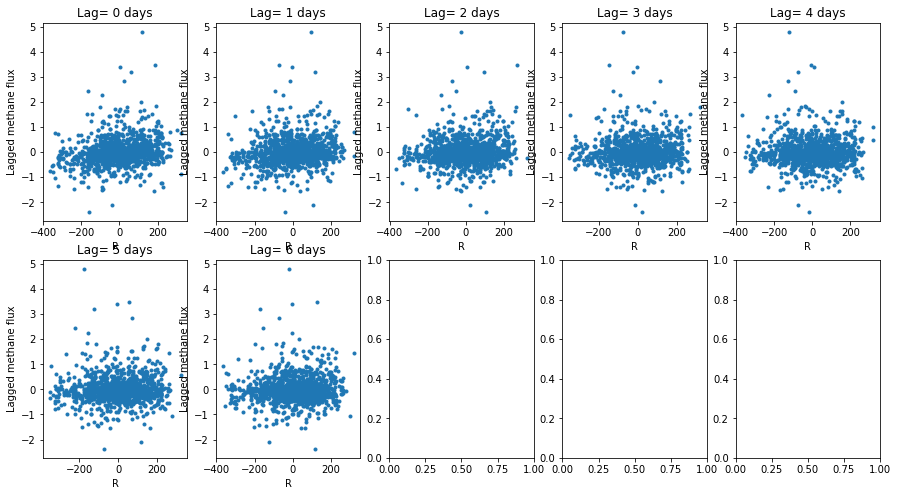

In [29]:
# Plot R vs methane flux
lag = np.arange(0, 7)
fig, axs = plt.subplots(2,5, figsize = [15, 8])
count1 = 0
count2 = 0
for n in lag:
    if n==0:
        y = np.array(Table.iloc[:]['methane_flux'])
        x = np.array(Table.iloc[:]['R'])
    else:
        y = np.array(Table.iloc[n:]['methane_flux'])
        x = np.array(Table.iloc[:-n]['R'])
    axs[count1, count2].plot(x,y, '.')
    axs[count1, count2].set_title('Lag= {} days'.format(n))
    axs[count1, count2].set_xlabel('R')
    axs[count1, count2].set_ylabel('Lagged methane flux')
    count2 = count2+1
    if count2 == 5:
        count2 = 0
        count1 = count1+1

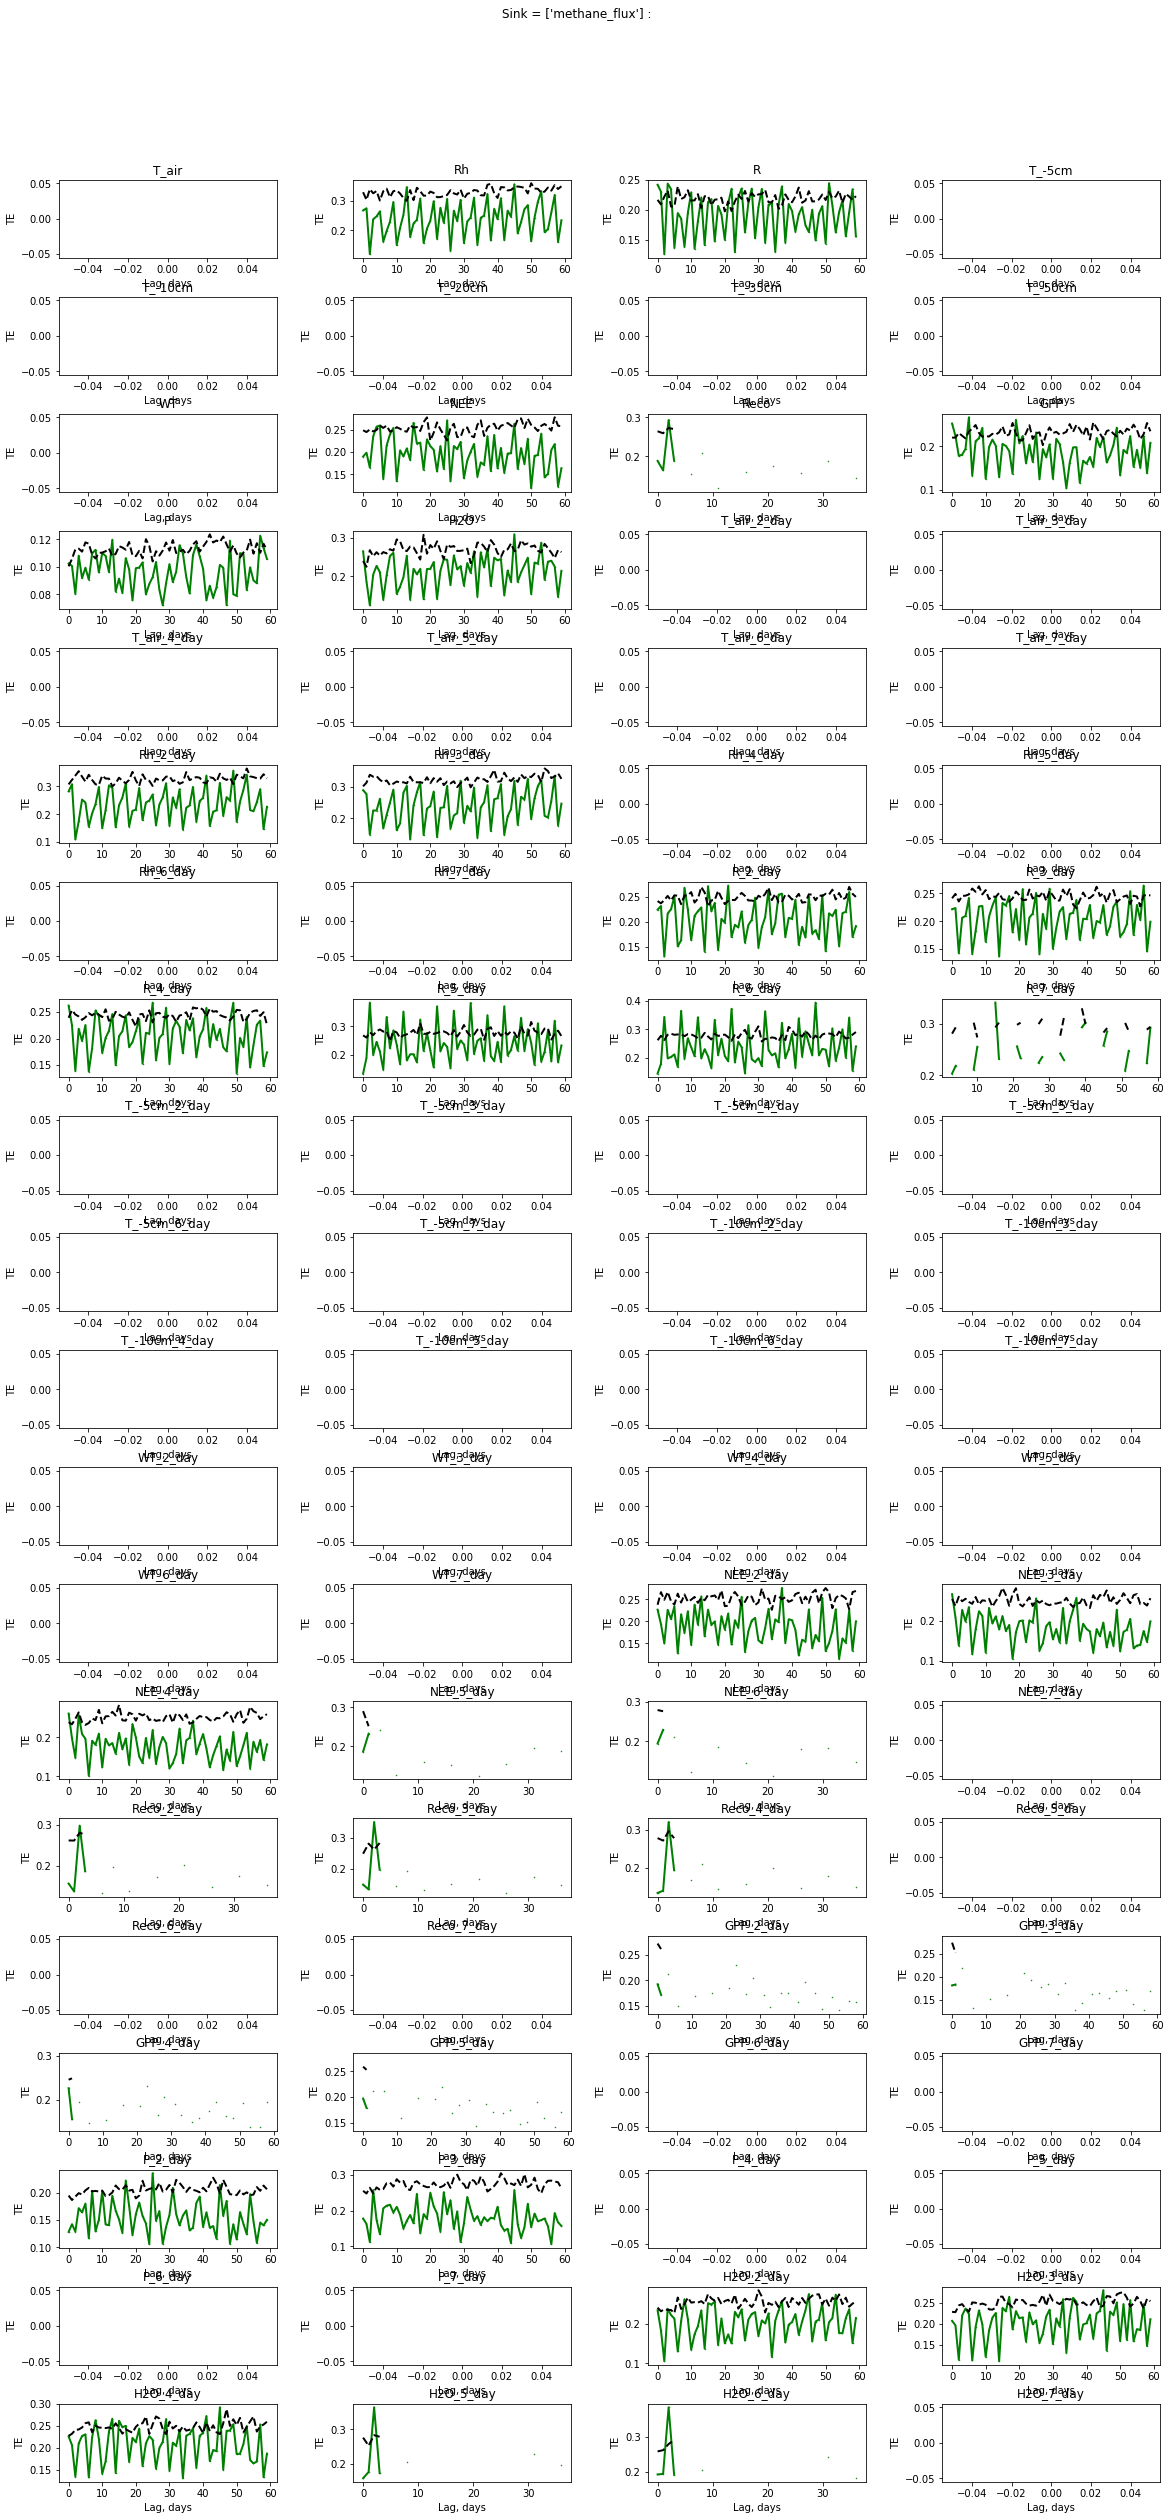

In [9]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 60

n = Tcube_store.shape[1]
plt.figure(figsize=[18,40])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
ACLabels = [] #Initialize an empty list that will contain the source variables for each row of AboveCritic
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    
    ACLabels.append(LabelC[SourN[i]])
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title(ACLabels[i])
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    if np.sum(~np.isnan(AboveCritic[i,:])):
        LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

C:\Users\Laurel Larsen\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


Text(0.5,0,'TE at Lag (days)')

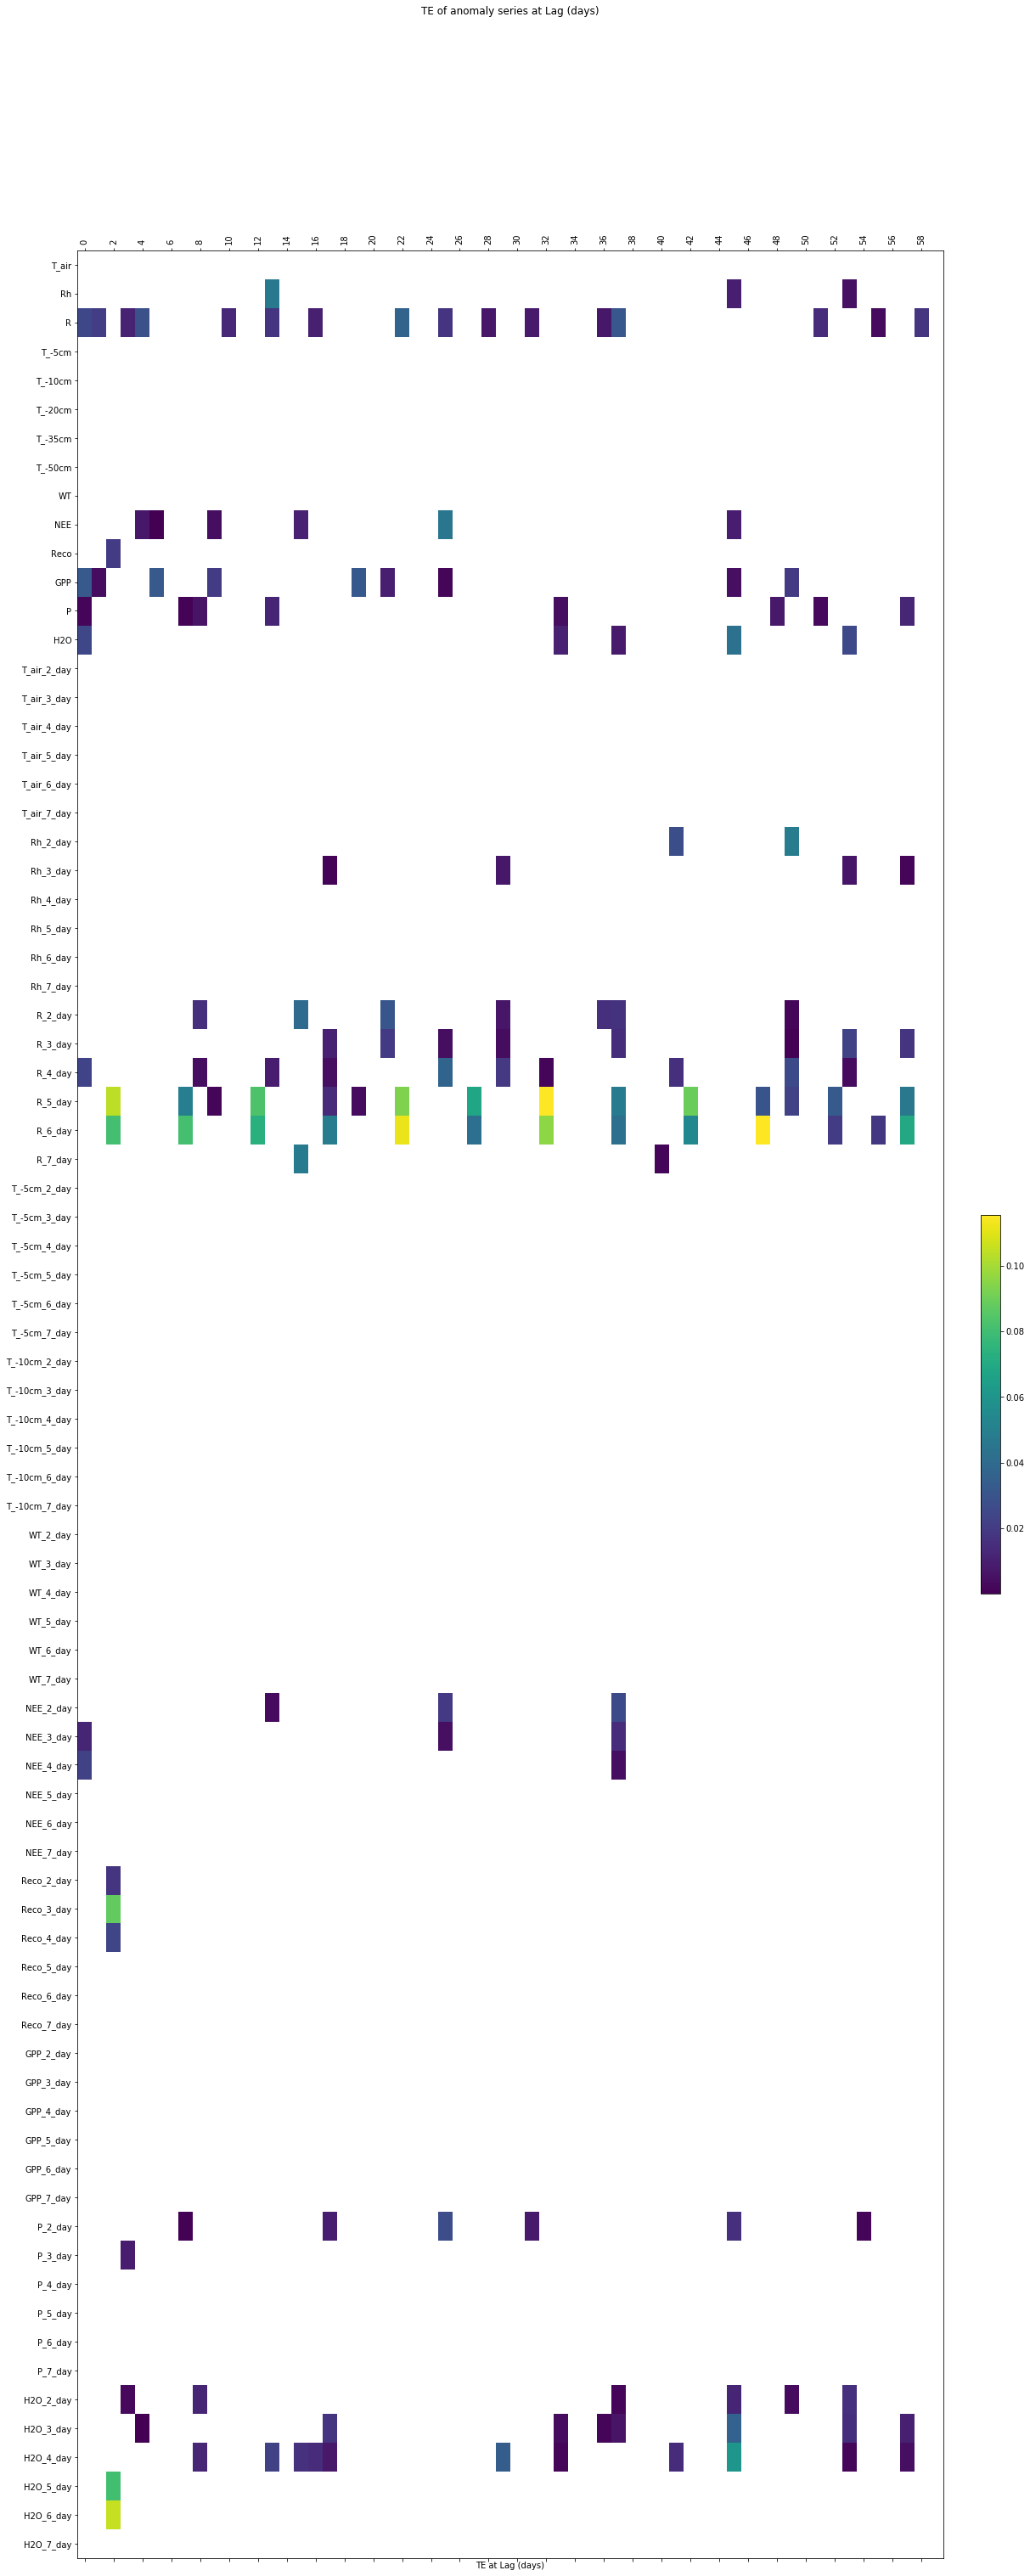

In [10]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[SourN]
minV = np.nanmin(AboveCritic)
maxV = np.nanmax(AboveCritic)

fig = plt.figure(1,figsize = (20,50)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='viridis', aspect=2) #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,2)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(ticksX)
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of anomaly series at Lag (days)',y=1.1)
plt.xlabel('TE at Lag (days)')

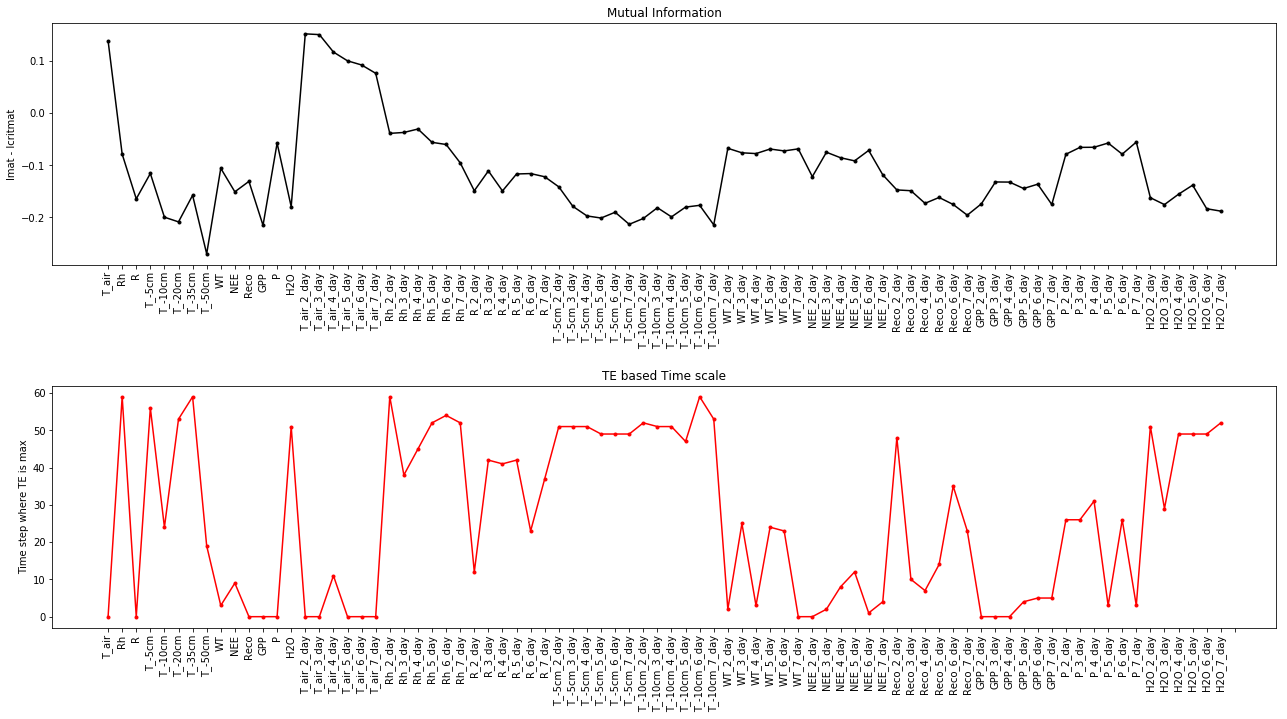

In [20]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[20,10])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('Mutual Information')
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime).T,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

## TE, nontransformed, t-lag

In [46]:
Imat, Icritmat, Tfirstmat,  Tbiggestmat,Tcube_store,  Tcritcube_store = TEpython3.RunNewTE2VarsSer(DataMatrix= DataM, LabelCell=LabelC, SinkNodes= SinN,SourceNodes=SourN, maxLag=60)

Beginning 2-variable analysis (serial) ...
Source node  0 T_air :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 0
1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 0 0
50 0 0
51 0 0
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 0 0
Source node  1 Rh :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 1
1 0 1
2 0 1
3 0 1
4 0 1
5 0 1
6 0 1
7 0 1
8 0 1
9 0 1
10 0 1
11 0 1
12 0 1
13 0 1
14 0 1
15 0 1
16 0 1
17 0 1
18 0 1
19 0 1
20 0 1
21 0 1
22 0 1
23 0 1
24 0 1
25 0 1
26 0 1
27 0 1
28 0 1
29 0 1
30 0 1
31 0 1
32 0 1
33 0 1
34 0 1
35 0 1
36 0 1
37 0 1
38 0 1
39 0 1
40 0 1
41 0 1
42 0 1
43 0 1
44 0 1
45 0 1
46 0 1
47 0 1
48 0 1
49 0 1
50 0 1
51 0 1
52 0 1
53 0 1
54 0 1
55 0 1
56 0 1
57 0 1
58 0 1
59 0 1
So

6 0 16
7 0 16
8 0 16
9 0 16
10 0 16
11 0 16
12 0 16
13 0 16
14 0 16
15 0 16
16 0 16
17 0 16
18 0 16
19 0 16
20 0 16
21 0 16
22 0 16
23 0 16
24 0 16
25 0 16
26 0 16
27 0 16
28 0 16
29 0 16
30 0 16
31 0 16
32 0 16
33 0 16
34 0 16
35 0 16
36 0 16
37 0 16
38 0 16
39 0 16
40 0 16
41 0 16
42 0 16
43 0 16
44 0 16
45 0 16
46 0 16
47 0 16
48 0 16
49 0 16
50 0 16
51 0 16
52 0 16
53 0 16
54 0 16
55 0 16
56 0 16
57 0 16
58 0 16
59 0 16
Source node  18 T_air_6_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 17
1 0 17
2 0 17
3 0 17
4 0 17
5 0 17
6 0 17
7 0 17
8 0 17
9 0 17
10 0 17
11 0 17
12 0 17
13 0 17
14 0 17
15 0 17
16 0 17
17 0 17
18 0 17
19 0 17
20 0 17
21 0 17
22 0 17
23 0 17
24 0 17
25 0 17
26 0 17
27 0 17
28 0 17
29 0 17
30 0 17
31 0 17
32 0 17
33 0 17
34 0 17
35 0 17
36 0 17
37 0 17
38 0 17
39 0 17
40 0 17
41 0 17
42 0 17
43 0 17
44 0 17
45 0 17
46 0 17
47 0 17
48 0 17
49 0 17
50 0 17
51 0 17
52 0 17
53 0 17
54 0 17
55 0 17
56 0 17
57 0 17
58 0 17
59 0 17
Source node  19 T_air_7_da

12 0 31
13 0 31
14 0 31
15 0 31
16 0 31
17 0 31
18 0 31
19 0 31
20 0 31
21 0 31
22 0 31
23 0 31
24 0 31
25 0 31
26 0 31
27 0 31
28 0 31
29 0 31
30 0 31
31 0 31
32 0 31
33 0 31
34 0 31
35 0 31
36 0 31
37 0 31
38 0 31
39 0 31
40 0 31
41 0 31
42 0 31
43 0 31
44 0 31
45 0 31
46 0 31
47 0 31
48 0 31
49 0 31
50 0 31
51 0 31
52 0 31
53 0 31
54 0 31
55 0 31
56 0 31
57 0 31
58 0 31
59 0 31
Source node  33 T_-5cm_3_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 32
1 0 32
2 0 32
3 0 32
4 0 32
5 0 32
6 0 32
7 0 32
8 0 32
9 0 32
10 0 32
11 0 32
12 0 32
13 0 32
14 0 32
15 0 32
16 0 32
17 0 32
18 0 32
19 0 32
20 0 32
21 0 32
22 0 32
23 0 32
24 0 32
25 0 32
26 0 32
27 0 32
28 0 32
29 0 32
30 0 32
31 0 32
32 0 32
33 0 32
34 0 32
35 0 32
36 0 32
37 0 32
38 0 32
39 0 32
40 0 32
41 0 32
42 0 32
43 0 32
44 0 32
45 0 32
46 0 32
47 0 32
48 0 32
49 0 32
50 0 32
51 0 32
52 0 32
53 0 32
54 0 32
55 0 32
56 0 32
57 0 32
58 0 32
59 0 32
Source node  34 T_-5cm_4_day :=> Sink node  13 methane_flux
Lag  Sink

12 0 46
13 0 46
14 0 46
15 0 46
16 0 46
17 0 46
18 0 46
19 0 46
20 0 46
21 0 46
22 0 46
23 0 46
24 0 46
25 0 46
26 0 46
27 0 46
28 0 46
29 0 46
30 0 46
31 0 46
32 0 46
33 0 46
34 0 46
35 0 46
36 0 46
37 0 46
38 0 46
39 0 46
40 0 46
41 0 46
42 0 46
43 0 46
44 0 46
45 0 46
46 0 46
47 0 46
48 0 46
49 0 46
50 0 46
51 0 46
52 0 46
53 0 46
54 0 46
55 0 46
56 0 46
57 0 46
58 0 46
59 0 46
Source node  48 WT_6_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 47
1 0 47
2 0 47
3 0 47
4 0 47
5 0 47
6 0 47
7 0 47
8 0 47
9 0 47
10 0 47
11 0 47
12 0 47
13 0 47
14 0 47
15 0 47
16 0 47
17 0 47
18 0 47
19 0 47
20 0 47
21 0 47
22 0 47
23 0 47
24 0 47
25 0 47
26 0 47
27 0 47
28 0 47
29 0 47
30 0 47
31 0 47
32 0 47
33 0 47
34 0 47
35 0 47
36 0 47
37 0 47
38 0 47
39 0 47
40 0 47
41 0 47
42 0 47
43 0 47
44 0 47
45 0 47
46 0 47
47 0 47
48 0 47
49 0 47
50 0 47
51 0 47
52 0 47
53 0 47
54 0 47
55 0 47
56 0 47
57 0 47
58 0 47
59 0 47
Source node  49 WT_7_day :=> Sink node  13 methane_flux
Lag  Sink Source


17 0 61
18 0 61
19 0 61
20 0 61
21 0 61
22 0 61
23 0 61
24 0 61
25 0 61
26 0 61
27 0 61
28 0 61
29 0 61
30 0 61
31 0 61
32 0 61
33 0 61
34 0 61
35 0 61
36 0 61
37 0 61
38 0 61
39 0 61
40 0 61
41 0 61
42 0 61
43 0 61
44 0 61
45 0 61
46 0 61
47 0 61
48 0 61
49 0 61
50 0 61
51 0 61
52 0 61
53 0 61
54 0 61
55 0 61
56 0 61
57 0 61
58 0 61
59 0 61
Source node  63 GPP_3_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 62
1 0 62
2 0 62
3 0 62
4 0 62
5 0 62
6 0 62
7 0 62
8 0 62
9 0 62
10 0 62
11 0 62
12 0 62
13 0 62
14 0 62
15 0 62
16 0 62
17 0 62
18 0 62
19 0 62
20 0 62
21 0 62
22 0 62
23 0 62
24 0 62
25 0 62
26 0 62
27 0 62
28 0 62
29 0 62
30 0 62
31 0 62
32 0 62
33 0 62
34 0 62
35 0 62
36 0 62
37 0 62
38 0 62
39 0 62
40 0 62
41 0 62
42 0 62
43 0 62
44 0 62
45 0 62
46 0 62
47 0 62
48 0 62
49 0 62
50 0 62
51 0 62
52 0 62
53 0 62
54 0 62
55 0 62
56 0 62
57 0 62
58 0 62
59 0 62
Source node  64 GPP_4_day :=> Sink node  13 methane_flux
Lag  Sink Source
0 0 63
1 0 63
2 0 63
3 0 63
4 0 63
5 0

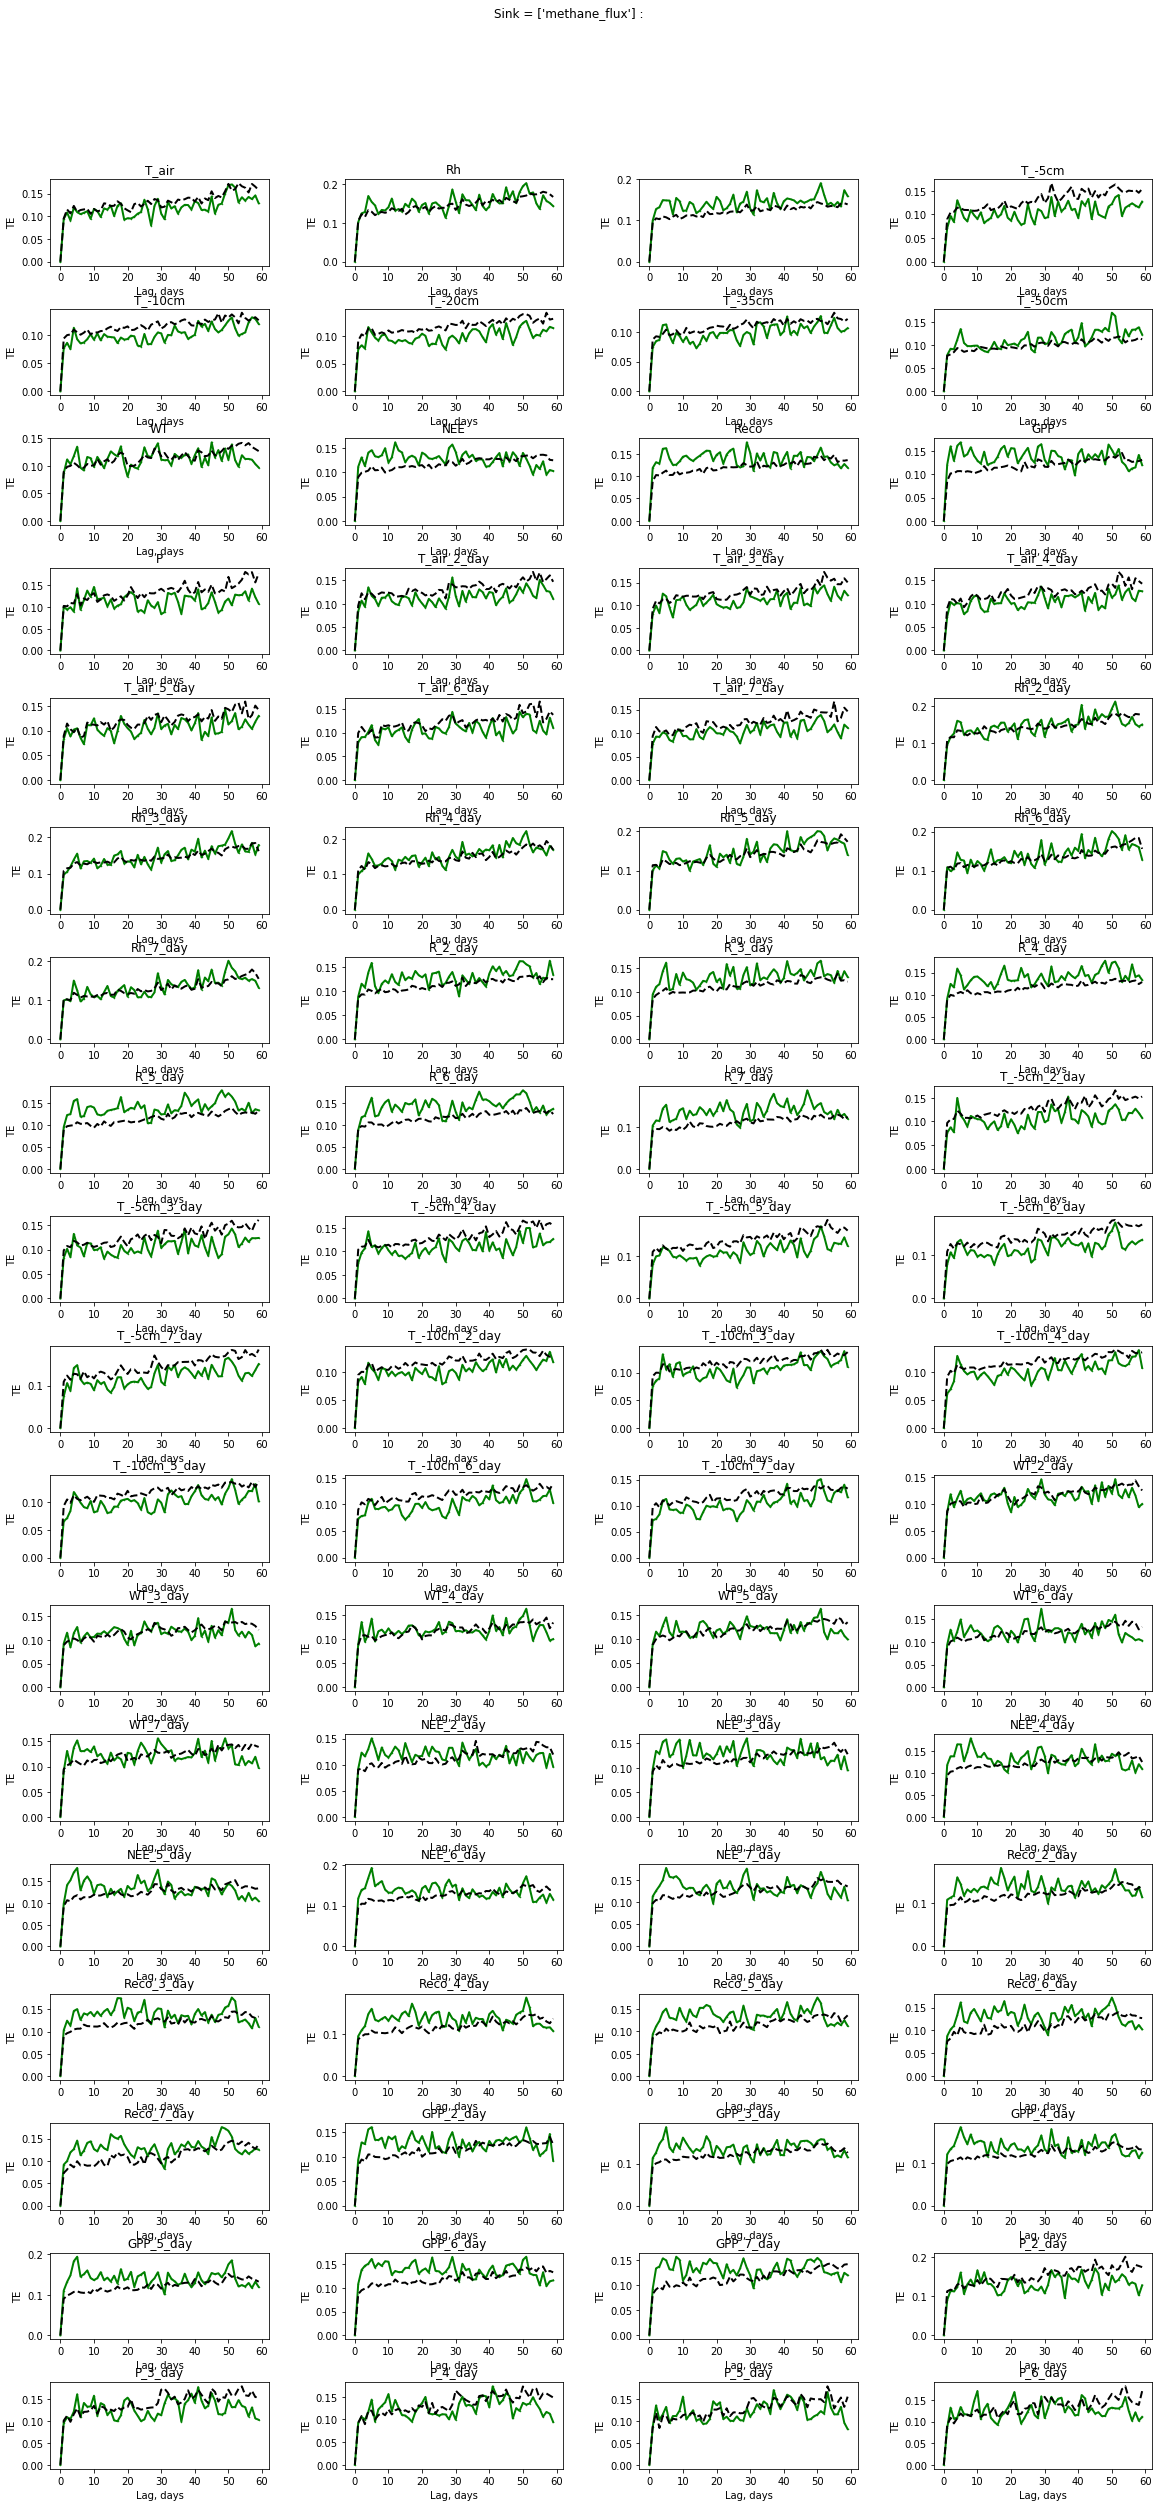

In [47]:
# Step 1/3 
# plotting results of TE one variable at a time
maxLag = 60

n = Tcube_store.shape[1]
plt.figure(figsize=[18,40])
AboveCritic = np.nan*np.ones([n,maxLag])
LagTime = np.nan*np.ones([n])
ACLabels = [] #Initialize an empty list that will contain the source variables for each row of AboveCritic
for i in np.arange(n):
    #i = 0  # Source id

    plt.subplot((int(n/4)+1), 4, i+1)
    plt.plot(np.arange(maxLag), Tcube_store[0,i,:].reshape(maxLag), color='green', marker='o', linewidth=2, markersize=0.5)
    plt.xlabel('Lag, days')
    plt.ylabel('TE')    

    plt.plot(np.arange(maxLag), Tcritcube_store[0,i,:].reshape(maxLag), color = 'black', linewidth=2, linestyle='dashed')
    #plt.title([LabelC[2], 'vs', LabelC[3]]) 
    plt.suptitle('Sink = %s :'%(LabelC[SinN]))
    
    ACLabels.append(LabelC[SourN[i]])
    #plt.title('Source = %s :'%(LabelC[i+2]))
    plt.title(ACLabels[i])
    
    #plt.title('Source = %s : Sink = %s'%(LabelC[i+2],LabelC[1]))
    
    #plt.legend(('TE Estimated','TE Critical' ),loc='lower right')

    
    # Locating the critical Time/Delay
    AboveCritic[i,:] = (Tcube_store[0,i,:] - Tcritcube_store[0,i,:]).reshape(maxLag)
    LagTime[i] = np.argwhere(AboveCritic[i,:] == np.nanmax(AboveCritic[i,:]))[0]
    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)

Text(0.5,0,'TE at Lag (days)')

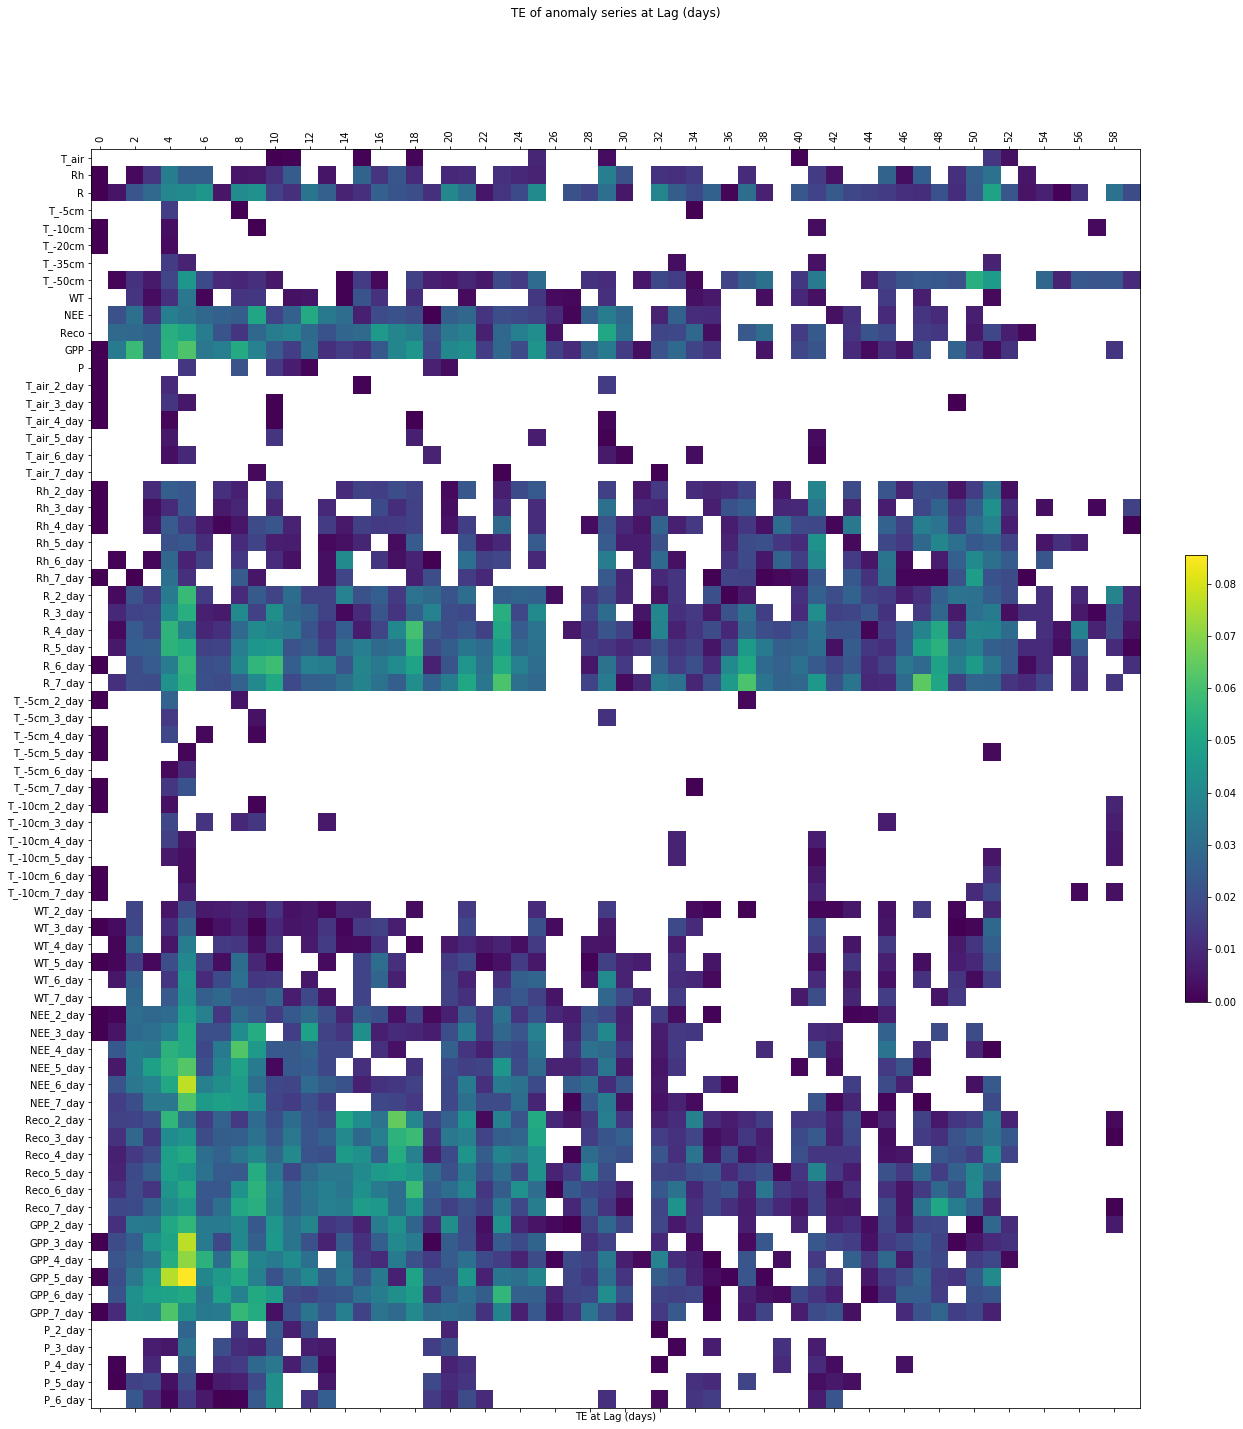

In [48]:
# Step 2/3
# Comparison accross variables
# Assign values less than critical to Nan
indNan = np.argwhere(AboveCritic<0)
AboveCritic[indNan[:,0],indNan[:,1]] = np.nan

names = LabelC[SourN]
minV = np.nanmin(AboveCritic)
maxV = np.nanmax(AboveCritic)

fig = plt.figure(1,figsize = (20,50)) 
ax = fig.add_subplot(111)
cax = ax.matshow(AboveCritic, vmin=minV, vmax=maxV,cmap='viridis', aspect=1) #cmap='ivaris'
ticksY = np.arange(0,names.shape[0],1)
ticksX = np.arange(0,maxLag,2)
ax.set_xticks(ticksX)
ax.set_yticks(ticksY)
ax.set_xticklabels(ticksX)
ax.set_yticklabels(names)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90)
plt.colorbar(cax,fraction=0.02, pad=0.04)
plt.title('TE of anomaly series at Lag (days)',y=1.1)
plt.xlabel('TE at Lag (days)')

In [ ]:
# Step 3/3
# Plotting Critical timescale and Mutual information. Mutual information in this excercise does not include lag. 
plt.figure(figsize=[20,5])
plt.subplot(2,1,1)
plt.plot((Imat-Icritmat).T,'k.-')
plt.ylabel('Imat - Icritmat')
plt.xticks(np.arange(numVr)," ")
plt.title('Mutual Information')
# plt.xticks([]) # hides the tick marks

plt.subplot(2,1,2)
plt.plot((LagTime).T,'r.-')
plt.ylabel('Time step where TE is max')
plt.xticks(np.arange(numVr),names)
plt.xticks(rotation=90)
plt.title('TE based Time scale')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5,wspace=0.35)